In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/cephfs/users/nrad/work/i3kiss/")

import utils
from utils import cscd_utils
from utils.cscd_utils import get_hist_and_plot, variables, samples, get_hists



/cephfs/users/nrad/work/i3kiss/utils/__init__.py:1: UserWarning: The recommended fonts to use plothist were not found. You can install them by typing 'install_latin_modern_fonts' in your terminal. If it still does not work, please check the documentation at https://plothist.readthedocs.io/en/latest/usage/font_installation.html
  from utils.plotting_utils import *


ltime_pass2_burn = 32715420.04


In [2]:
# def __get_pred_hist__tocomplicated(df, var, bins, pred_name=None, min_pred=0.001, pred_weights=None, weight_cols='weights', apply_truth='truth'):
def get_pred_hist__tocomplicated(df, var, bins, pred_name=None, min_pred=0.001, pred_weights=None, weight_cols='weights', extra_weights=None, apply_truth='truth',store_pred=False):
    """
        Sample the dataframe with probabilities given by the <pred_name> column and make
        histogram of the <var> column with the given <bins> and weight columns <weight_cols>


    """

    random_sampling = False

    if pred_name is None:
        pred = np.ones(len(df))
        hist_name = "nominal"
    elif isinstance(pred_name, float):
        # raise NotImplementedError("Not implemented yet")
        """
            drawing sample from a uniform distribution is not the same as drawing
            a sample using a coin toss in this case!
            The coin-toss is going to have 
        """
        assert 0 <= pred_name <= 1
        random_sampling = True
        pred_prob = pred_name
        # pred = np.random.rand(len(df)) < pred_prob
        # pred = pred.astype(int) * pred_prob
        df = df.sample(frac=pred_name)
        pred = np.ones(len(df))
        hist_name = f"random_pred_{pred_prob}"
    elif isinstance(pred_name, (list,pd.core.series.Series,np.ndarray)):
        pred = pred_name
        hist_name = getattr(pred_name, 'name', 'custom_pred')
    elif isinstance(pred_name, str):
        pred = df[pred_name]
        hist_name = f"{pred_name}"
    else:
        raise ValueError(f"<pred_name> should be either None, float, list, pd.Series or str. Got {type(pred_name)}")

    if min_pred:
        hist_name = f"{pred_name}_{min_pred}"
        pred = np.where(pred > min_pred, pred, min_pred)
        hist_name += f"_{min_pred}"

    if store_pred:
        df[hist_name] = pred 
    pred_weights_, pred_mask = speedup_utils.get_weight_from_pred(pred)
    # print(f"{pred = }")
    # print(f"{pred_weights = }")
    if not pred_weights is None:
        print("WARNING Overwriting weights from pred with the given pred_weights!!")
    else:
        pred_weights = pred_weights_

    if not extra_weights is None:
        pred_weights *= extra_weights

    if random_sampling:
        pred_weights = np.ones(len(df)) / pred_name

    weights = utils.combine_weight_columns(df,weight_cols)
    if apply_truth:
        truth_mask = df[apply_truth] == 1
        mask = pred_mask & truth_mask
    else:
        mask = pred_mask
    h = utils.make_hist(df[mask][var], 
                        weights=weights[mask] * pred_weights[mask], 
                        bins=bins) 
    return h






def get_pred_hist(df, var, bins, pred_name, weight_cols, **kwargs):
    """
        creates a histogram of the <var> column with the given <bins> and weight columns <weight_cols>
        Rejection Sampling is applied using the probabilities given by the <pred_name> column.
        bin contents are given by sum(weights) 
        and bin errors are given by sqrt(sum(weights**2) * (1/pred) )
    
    """
    pred = df[pred_name].astype('float128')
    weights = utils.combine_weight_columns(df,weight_cols)
    weights = weights.astype('float128')

    bc, bin_edges = np.histogram(df[var], bins=bins, weights=weights, **kwargs) 
    bv, bin_edges = np.histogram(df[var], bins=bins, weights=weights**2 * (1.0/df[pred_name]) , **kwargs)
    h = utils.make_hist([], weights=[], bins=bins)
    for i, (v, e) in enumerate(zip(bc, bv)):
        h[i] = [v, e]
    return h




In [ ]:
##
## Add Corsika Sample to the Cscd Samples
##

fname_train = "/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/train.hdf5"
fname_test = "/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/test.hdf5"

fname = fname_train

dfs = []
w_fracs = []
for fname, w_frac in [ (fname_test, 0.1) , 
                       (fname_train,0.9)
                        ]:
    df = pd.read_hdf(fname)
    dfs.append(df)
    w_fracs.append(w_frac)

df_corsika  = pd.concat(dfs)
df_corsika['weights'] = (df_corsika['sel_flux_weights'] * 1.0/sum(w_fracs)).astype('float128')
df_corsika['selection_weights'] = (df_corsika['selection_weights'] * 1.0/sum(w_fracs)).astype('float128')

samples.update(**{
    "corsika": dict(df=df_corsika, 
                    weights='weights',
                    label='atm $\mu$ (Corsika)',
                    color='purple',
                    ),
})

#for sname, sinfo in samples.items():
for sname in ['corsika']:
    sinfo = samples[sname]
    df_ = sinfo['df']
    df_['cscdSBU_MonopodFit4_cos_zenith'] = np.cos(df_['cscdSBU_MonopodFit4_zenith'])
    # df_ = cscd_utils.apply_sel(df_)

df_corsika.reset_index(inplace=True)
df_corsika = df_corsika.query('mu')


/tmp/ipykernel_1440933/2441785453.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corsika['weights'] = (df_corsika['sel_flux_weights'] * 1.0/sum(w_fracs)).astype('float128')
/tmp/ipykernel_1440933/2441785453.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_['cscdSBU_MonopodFit4_cos_zenith'] = np.cos(df_['cscdSBU_MonopodFit4_zenith'])
/tmp/ipykernel_1440933/2441785453.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [11]:
df_corsika['mu1_energy']

df_corsika.query('(mu1_energy > 100_000) & (MuonFilter_13==1)')

index  Run     Event  SubEvent  SubEventStream  exists  \
10           978  0.0   77956.0       0.0             0.0     1.0   
81         15218  0.0   96607.0       0.0             0.0     1.0   
959       260786  0.0  139999.0       0.0             0.0     1.0   
1374      109286  0.0  182535.0       0.0             0.0     1.0   
1515       20918  0.0  190315.0       0.0             0.0     1.0   
...          ...  ...       ...       ...             ...     ...   
2687894   787716  0.0  116981.0       0.0             0.0     1.0   
2687959   955582  0.0  194306.0       0.0             0.0     1.0   
2688072  2038393  0.0  204951.0       0.0             0.0     1.0   
2688169  1181018  0.0  193087.0       0.0             0.0     1.0   
2688768   948915  0.0   26840.0       0.0             0.0     1.0   

              energy    minorID       majorID   azimuth  ...  \
10       294076416.0   178521.0  4.090528e+18  1.409188  ...   
81        24120484.0  1287674.0  2.850057e+18  1.895542  ...   
959       63983040.0   112281.0  1.306703e+19  1.819184  ...   
1374      22475496.0   606966.0  4.942127e+18  3.762439  ...   
1515       6910923.0   314965.0  1.019602e+17  3.675965  ...   
...              ...        ...           ...       ...  ...   
2687894   17426296.0   824522.0  1.543048e+19  4.464894  ...   
2687959  429873600.0    63512.0  1.672232e+19  5.782568  ...   
2688072   23842570.0  1161115.0  5.217511e+18  3.918839  ...   
2688169   37857452.0   367495.0  1.438088e+19  2.702892  ...   
2688768  244466848.0   248203.0  3.145507e+18  1.894290  ...   

         balanced_weights_CscdBDT  balanced_proc_weights_CscdBDT  \
10                       0.074545                       0.074545   
81                       0.009784                       0.000102   
959                      0.005792                       0.000060   
1374                     0.010523                       0.000110   
1515                     0.048566                       0.000507   
...                           ...                            ...   
2687894                  0.001531                       0.001599   
2687959                  0.000482                       0.000005   
2688072                  0.001099                       0.000011   
2688169                  0.000673                       0.000007   
2688768                  0.000378                       0.000004   

         balanced_weights_squared_CscdBDT  \
10                           2.154633e-05   
81                           7.872018e-06   
959                          2.758969e-06   
1374                         9.105457e-06   
1515                         1.939644e-04   
...                                   ...   
2687894                      1.739202e-06   
2687959                      1.721124e-07   
2688072                      8.954172e-07   
2688169                      3.358439e-07   
2688768                      1.062954e-07   

         balanced_proc_weights_squared_CscdBDT  balanced_weights  \
10                                2.154633e-05          0.074545   
81                                8.003772e-10          0.009784   
959                               2.805146e-10          0.005792   
1374                              9.257855e-10          0.010523   
1515                              1.972108e-08          0.048566   
...                                        ...               ...   
2687894                           1.768750e-06          0.001531   
2687959                           1.750364e-11          0.000482   
2688072                           9.106296e-11          0.001099   
2688169                           3.415496e-11          0.000673   
2688768                           1.081012e-11          0.000378   

         balanced_weights_squared  truth  sel_flux_weights       weights  \
10                   2.154633e-05    1.0      9.275957e-10  9.275957e-10   
81                   7.872018e-06    0.0      3.630554e-09  3.630554e-09   
959       

{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}
{'dpi': 100, 'bbox_inches': 'tight'}
plot saved in: /afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse3.png
directory /afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse3.png --> 
https://www-zeuthen.desy.de/~nrad/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse3.png


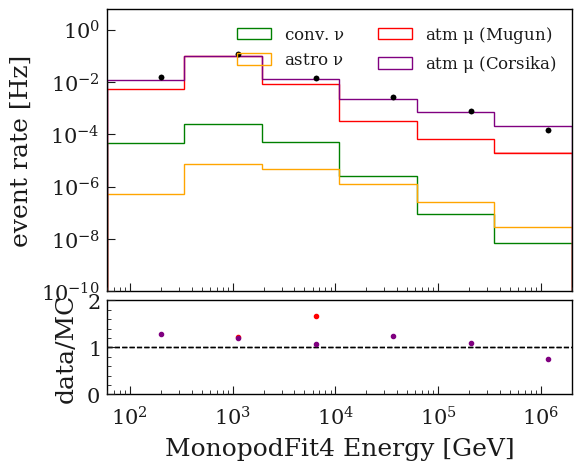

In [12]:
plot_dir = "/data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/"
plot_dir = "/afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/"

variables_names = ['monopod_energy', 'monopod_energy_coarse2']
#variables_names = ['monopod_energy']
variables_names = ['monopod_energy', 'monopod_energy_coarse', 'monopod_energy_coarse2', 'monopod_energy_coarse3']
variables_names = ['monopod_energy_coarse3']
#variables_names = ['monopod_energy_coarse']


variables.update(  {  "monopod_energy_coarse3" : dict(var="cscdSBU_MonopodFit4_energy", 
                            # bins=np.logspace(0, 6, 10), 
                            bins=np.geomspace(60,2E6, 7),
                            label="MonopodFit4 Energy [GeV]",
                            xscale='log',
                            ),})

for var_name in variables_names:
    res = get_hist_and_plot(**variables[var_name],
                            plot_path=os.path.join(plot_dir, f"{var_name}.png"),
                            samples=samples,
                            )

# Smart Sampling

## load models

In [5]:
from utils import tf_utils
from ModelFactory import ModelFactory
from MuModelFactory import MuModelFactory
from utils import speedup_utils


model_infos = [
    dict(version_tag='Cscd_v0.0.2_mupos', model_tag='simple_v0.0', model_name='base_large_v0.1', label="MLP"),
    #dict(version_tag="Cscd_v0.0.2_mupos", model_tag="muemb_v0.0", model_name="base_1028_v0.0", label="MuEmb1"),
    # dict(version_tag="Cscd_v0.0.2_mupos", model_tag="muemb_v0.0", model_name="muemb_v0.2", label="MuEmb2"),
    dict(version_tag="Cscd_v0.0.2_mupos", model_tag="muemb_v0.0", model_name="muemb_v0.3", label="MuEmb3"),
    # dict(version_tag="Cscd_v0.0.2_mupos", model_tag="MuEmb_ManualHP_D", model_name="D16_M256_E64_C64", label="MuEmbHP"),
    dict(version_tag="Cscd_v0.0.2_mupos", model_tag="MuEmb_ManualHP_E", model_name="D16_M256_E64_C64", label="MuEmbHP2"),
]

mfs = {}

df = samples['corsika']['df']

model_names = []

for model_info in model_infos:
    model_label = model_info.pop("label")
    model_name = model_info['model_name']
    model_tag = model_info.get('model_tag', "")
    version_tag = model_info.get('version_tag', "")
    # model_label = model_name + (f"_{model_tag}" if model_tag else "")
    print(model_info)
    if 'muemb' in model_tag.lower():
        mf = MuModelFactory.load_model(model_name, model_tag=model_tag, version_tag=version_tag)
    else:
        mf = ModelFactory.load_model(model_name, model_tag=model_tag, version_tag=version_tag)
    mfs[model_label] = mf

    # mf._df_test = df_test
    # mf._df_train = df_train
    # df[model_label] = mf.model.predict(df[mf.features], batch_size=mf.batch_size)

    X = df[mf.features] if not hasattr(mf, "xy_maker") else mf.xy_maker(mf, df)['x']
    df[model_label] = mf.model.predict(X, batch_size=mf.batch_size) 
    print(model_name)
    model_names.append(model_label)

df = df_corsika
speedup_utils.add_pseudo_preds(df, truth_label='CscdBDT')

model_name = 'nominal'
model_names.append(model_name)
df[model_name] = 1.0

2025-02-20 16:58:43.291709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 16:58:46.491252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 16:58:47.355842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 16:58:52.536284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 16:59:00.454334: W tensorflow/comp

{'version_tag': 'Cscd_v0.0.2_mupos', 'model_tag': 'simple_v0.0', 'model_name': 'base_large_v0.1'}
loading model from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/simple_v0.0/base_large_v0.1/model.keras
define_flexible_model
<function define_flexible_model at 0x7f9a2f8b3ec0>
MODEL <Sequential name=sequential, built=True>
loading weights from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/simple_v0.0/base_large_v0.1/base_large_v0.1.weights.h5


I0000 00:00:1740067153.156055  183264 service.cc:146] XLA service 0x7f9698007de0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740067153.156234  183264 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-02-20 16:59:13.811927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740067156.157615  183264 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


/tmp/ipykernel_181931/4103291929.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[model_label] = mf.model.predict(X, batch_size=mf.batch_size)


base_large_v0.1
{'version_tag': 'Cscd_v0.0.2_mupos', 'model_tag': 'muemb_v0.0', 'model_name': 'muemb_v0.3'}
loading model from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/muemb_v0.0/muemb_v0.3/model.keras
define_muemb_model
<function define_muemb_model at 0x7f9a2f8d2020>
MODEL <Functional name=CombinedModel, built=True>
loading weights from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/muemb_v0.0/muemb_v0.3/muemb_v0.3.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step


/tmp/ipykernel_181931/4103291929.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[model_label] = mf.model.predict(X, batch_size=mf.batch_size)


muemb_v0.3
{'version_tag': 'Cscd_v0.0.2_mupos', 'model_tag': 'MuEmb_ManualHP_E', 'model_name': 'D16_M256_E64_C64'}
loading model from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/MuEmb_ManualHP_E/D16_M256_E64_C64/model.keras
define_muemb_model
<function define_muemb_model at 0x7f9a2f8d2020>
MODEL <Functional name=CombinedModel, built=True>
loading weights from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/MuEmb_ManualHP_E/D16_M256_E64_C64/D16_M256_E64_C64.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
D16_M256_E64_C64


/tmp/ipykernel_181931/4103291929.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[model_label] = mf.model.predict(X, batch_size=mf.batch_size)
/cephfs/users/nrad/work/i3kiss/utils/speedup_utils.py:472: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[cls0, name] = pdf_neg.rvs(cls0.sum())
/cephfs/users/nrad/work/i3kiss/utils/speedup_utils.py:498: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [6]:
def weighted_qcut(values, weights, q, **kwargs):
    from pandas._libs.lib import is_integer
    'Return weighted quantile cuts from a given series, values.'
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()




/tmp/ipykernel_181931/967358701.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corsika['primary_energy_bin'] = weighted_qcut(df_corsika['energy'], df_corsika['sel_flux_weights'], q=4, labels=primary_energy_labels )
/tmp/ipykernel_181931/967358701.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_blues = plt.cm.get_cmap('Blues', len(primary_energy_labels))
/tmp/ipykernel_181931/967358701.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get

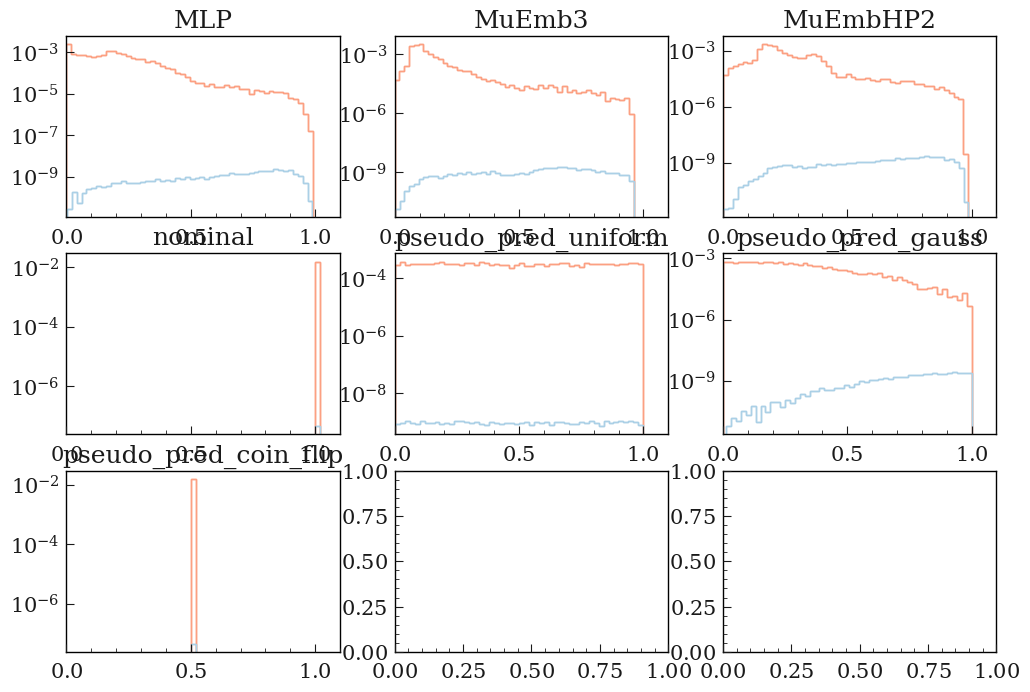

In [7]:
bin_var = 'energy'
primary_energy_labels = ["low", "mid", "high", "vhigh"]
# df_corsika['primary_energy_bin'] = pd.qcut(df_corsika[bin_var], q=4, labels=primary_energy_labels )

df_corsika['primary_energy_bin'] = weighted_qcut(df_corsika['energy'], df_corsika['sel_flux_weights'], q=4, labels=primary_energy_labels )

cmap_blues = plt.cm.get_cmap('Blues', len(primary_energy_labels))
cmap_reds = plt.cm.get_cmap('Reds', len(primary_energy_labels))

model_names_all = model_names + ['pseudo_pred_uniform', 'pseudo_pred_gauss'] + ['pseudo_pred_coin_flip']

fig, axs = plt.subplots(figsize=(12, 8), nrows=3, ncols= len(model_names_all)//3+1)

iax = 0
df = df_corsika.sample(frac=0.1)
for model_name in model_names_all:
    # print(model_name)
    # for selection in selections:
    # df = df_corsika.query(selection)
    ax = axs.flatten()[iax]
    iax += 1
    
    for i, energy_label in enumerate(primary_energy_labels):
        # df = df_corsika.query(f"primary_energy_bin == '{energy_label}'")
        
        cls0 = df[mf.labels[0]]==0
        cls1 = df[mf.labels[0]]==1
        weights = df['sel_flux_weights']

        alpha = (i+1)/len(primary_energy_labels)
        hkw = dict(bins=50, histtype='step', alpha=alpha, lw=2)
        ax.hist(df[cls0][model_name], weights=weights[cls0]/len(df), color=cmap_reds(1), **hkw)
        ax.hist(df[cls1][model_name], weights=weights[cls1]/len(df), color=cmap_blues(1),  **hkw) 
        title = model_name #+"\n"+selection
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_xlim(0,1.1)
        continue

## Get Model Histograms 

In [8]:

#for p, model_name, min_pred in ( (pred, 'pred_0.6', 0.6), (pred, 'pred_0.2', 0.2), ):

pseudo_preds = [k for k in df.columns if 'pseudo_pred' in k]
pseudo_preds = ['pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']
print(f"{pseudo_preds = }")

hists_pred = {}
var_info = variables[var_name]
var  = var_info['var']
bins = var_info['bins']
print(f"""
{var_name = }
{var = }
{bins = }
      """)
# centers = (bins[1:] + bins[:-1])/2
selections = [ f"{var}>%s & {var} <=%s"%(bins[i], bins[i+1]) for i in range(len(bins)-1)]


def get_n_photons(df, weights_columns=['weights', 'selection_weights'], selection=None):
    if selection is not None:
        df = df.query(selection)
    weights = []
    for w in weights_columns:
        if isinstance(w,str):
            if w in df.columns:                
                weights.append(df[w])
            else:
                raise ValueError(f"{w} not in df.columns")
        else:
            weights.append(w)
    return np.sum(df['n_photons'] * np.prod(weights) )

n_simulated_photons = {}

truth_mask = df_corsika[mf.labels[0]]==1


min_preds = [0.001]
pred_names = []

for model_name in model_names[:] + pseudo_preds:
    #for min_pred in [0.2,0.5]:
    min_preds_ = min_preds
    if model_name in ['nominal'] + pseudo_preds:
        min_preds_ = [0]
        
    for min_pred in min_preds_:

        pred_name = "%s_%s"%(model_name, min_pred) if model_name not in ['nominal']+pseudo_preds else model_name
        pred_names.append( pred_name)
        print(pred_name, model_name, min_pred)
        pred = df_corsika[model_name]
        pred = np.where(pred > min_pred, pred, min_pred)
        df_corsika[pred_name] = pred 

        do_actual_sampling = False
        # do_actual_sampling = True
        if do_actual_sampling:
            pred_weights, pred_mask = speedup_utils.get_weight_from_pred(pred)
            weights = df_corsika['weights'] # * pred_weights
            h = utils.make_hist(df_corsika[pred_mask & truth_mask][var], 
                                weights=(weights[pred_mask & truth_mask] * pred_weights[pred_mask & truth_mask]).astype('float128'), 
                                bins=bins) 
            hists_pred[pred_name] = h
        else:
            h = get_pred_hist(df_corsika[truth_mask], var, bins, pred_name, 'weights')
            hists_pred[pred_name] = h


    simulated_photons = df_corsika['n_photons'] * df_corsika['selection_weights'] * pred
    n_simulated_photons[pred_name] = np.sum( simulated_photons )
        


pseudo_preds = ['pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']

var_name = 'monopod_energy_coarse3'
var = 'cscdSBU_MonopodFit4_energy'
bins = array([6.00000000e+01, 3.40380267e+02, 1.93097877e+03, 1.09544512e+04,
       6.21446501e+04, 3.52546877e+05, 2.00000000e+06])
      
MLP_0.001 MLP 0.001


/tmp/ipykernel_181931/2940661190.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corsika[pred_name] = pred


MuEmb3_0.001 MuEmb3 0.001


/tmp/ipykernel_181931/2940661190.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corsika[pred_name] = pred


MuEmbHP2_0.001 MuEmbHP2 0.001


/tmp/ipykernel_181931/2940661190.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corsika[pred_name] = pred


nominal nominal 0
pseudo_pred_uniform pseudo_pred_uniform 0
pseudo_pred_coin_flip pseudo_pred_coin_flip 0
pseudo_pred_gauss pseudo_pred_gauss 0


In [9]:

if False:
    """ reduce the nominal to the computational cost of the other models
    """
    n_gamma_factors = {k:v/n_simulated_photons['nominal'] for k, v in n_simulated_photons.items()}

    n_simulated_photons_nom = {}
    hists_pred_nom = {}
    for pred_name in model_names[:] + ['pseudo_pred_uniform']:
        #for min_pred in [0.2,0.5]:
        min_preds_ = min_preds
        if pred_name in ['nominal', 'pseudo_pred_uniform']:
            min_preds_ = [0]

        for min_pred in min_preds_:
            print(pred_name, min_pred)
            hist_name_orig = "%s_%s"%(pred_name, min_pred) if pred_name not in ['nominal', 'pseudo_pred_uniform'] else pred_name
            hist_name = f"nominal_{hist_name_orig}"
            # pred_name = 'nominal'
            df_ = df_corsika.sample(frac=n_gamma_factors[hist_name_orig])
            pred = df_['nominal']
            pred = np.where(pred > min_pred, pred, min_pred)
            pred_weights, pred_mask = speedup_utils.get_weight_from_pred(pred)

            weights = df_['weights'] # * pred_weights
            # h = utils.make_hist(df_sel[var], weights=weights * pred, bins=bins) # from the whole population
            h = utils.make_hist(df_[pred_mask][var], 
                                weights=weights[pred_mask] * pred_weights[pred_mask] * 1.0/n_gamma_factors[hist_name_orig], 
                                # weights=weights[pred_mask & truth_mask], 
                                bins=bins) # from the whole population
            hists_pred_nom[hist_name_orig] = h

            #simulated_photons = df_corsika['n_photons'] * weights * pred
            simulated_photons = df_['n_photons'] * df_['selection_weights'] * pred
            n_simulated_photons_nom[hist_name_orig] = np.sum( simulated_photons )



/tmp/ipykernel_181931/2704638596.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_181931/2704638596.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors_base[imodel])


(0.0, 3.4)

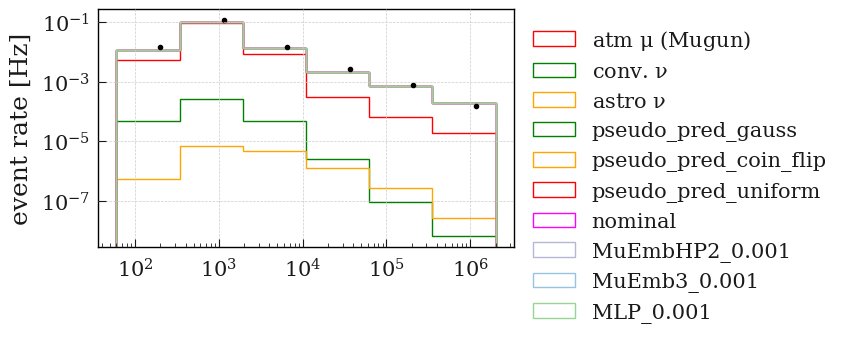

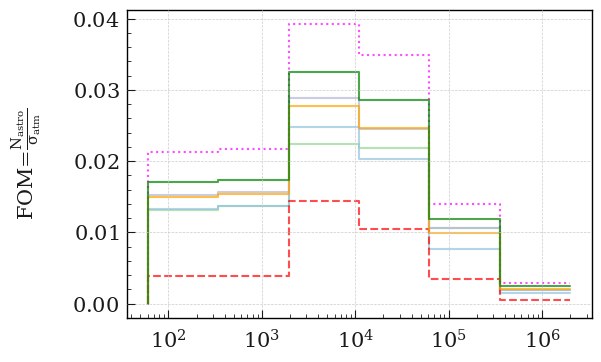

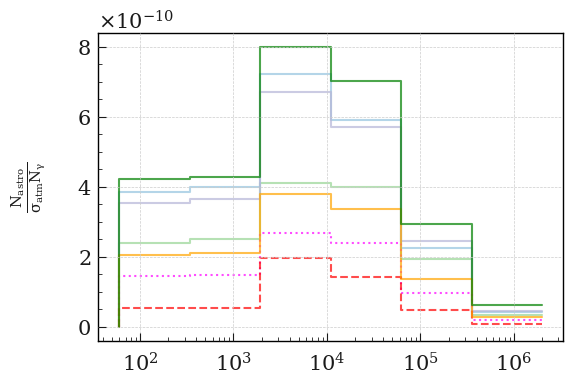

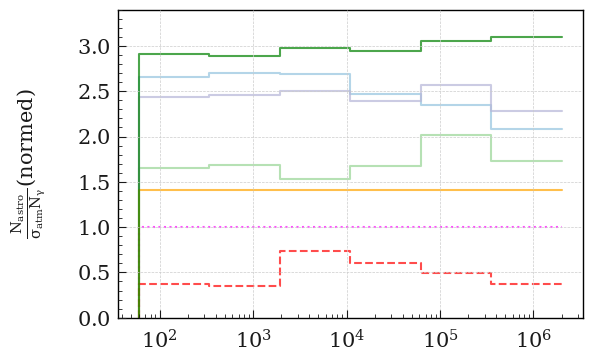

In [10]:
import textwrap
import matplotlib.pyplot as plt


def wraplabel(text, width=25):
    return "\n".join(textwrap.wrap(text, width=width))

def make_label(hname):
    if not 'pseudo' in hname:
        if "_" in hname:
            label = "_".join(hname.split("_")[3:-2])
        else:
            return hname
    else:
        label = hname
    return wraplabel(label, 15)

hists = get_hists(**var_info, samples=samples)


fig, ax_main = plt.subplots()
fig.tight_layout(pad=3)

#ax_main = axs[0]
hkw = dict(ax=ax_main, histtype='step', lw=1.5)
snames = [ 'astro', 'atm_conv', 'mugun']


utils.plot_hist( [hists[sname] for sname in snames],
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

snames_comp = ['corsika', 'mugun']

utils.plot_error_hist(hists['data'], 
                ax_main, color='black')


cmap = plt.cm.get_cmap('Blues')

colors = {
    # 'pseudo_pred_gauss_0.2': 'green',
    'pseudo_pred_uniform': 'red',
    'pseudo_pred_coin_flip': 'orange',
    'pseudo_pred_gauss' : 'green',
    # 'nominal': samples['corsika']['color'], 
    'nominal': 'magenta'
}


colors_base = ['green', 'blue', 'magenta' ]
colors_base = ['Greens', 'Blues', 'Purples', "Oranges", "Grays"]

for imodel, model_name in enumerate(model_names[:]):
    min_preds_ = min_preds
    if model_name in ['nominal', 'pseudo_pred_uniform']:
        min_preds_ = [0]
        continue
    cmap = plt.cm.get_cmap(colors_base[imodel])
    for ipred, min_pred in enumerate(min_preds_):
        pred_name = "%s_%s"%(model_name, min_pred) if min_pred else model_name
        colors[pred_name] = cmap( (ipred+0.8)/(len(min_preds_)+1) )
        #print(pred_name)
        # color = list( plt.cm.colors.to_rgba(colors_base[imodel]) )
        # color[-1] = (ipred+1)/len(min_preds_)
        #color[-1] = 0.1
        #colors[pred_name] = tuple(color)

line_styles = {'nominal':':', 'pseudo_pred_uniform':'--'}


utils.plot_hist([h for h in hists_pred.values()], 
                color=[colors[h] for h in hists_pred],
                #color=[]
                #label=[make_label(h) for h in hists_pred],
                label=[h for h in hists_pred][:],
                #line_style=[line_styles.get(h, '' ) for h in hists_pred],
                ax=ax_main,
                fill=False,
                histtype='step',                    
                )

fig, ax1 = plt.subplots()

foms = {}
for k,h in hists_pred.items():
    fom = cscd_utils.calc_fom(hists['astro'], h)
    fom = np.array(fom)

    label = make_label(k)
    label = wraplabel(label, 30)

    foms[k] = fom
    ax1.step(x=h.axes[0].edges[:], y=[0]+list(fom), label=label, color=colors[k], alpha=0.7, ls=line_styles.get(k))
    ax1.set_ylabel(r"FOM=$\frac{N_{astro}}{\sigma_{atm}}$", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)

from copy import deepcopy
foms2 = deepcopy(foms)


fig, ax2 = plt.subplots()

for k, fom in foms.items():
    # fom = cscd_utils.calc_fom(hists['astro'], h)
    fom /= (n_simulated_photons[k] * 5E-9 )
    # fom /= 
    label = make_label(k)
    label = wraplabel(label, 30)

    ax2.step(x=h.axes[0].edges[:], y=[0]+list(fom), label=label, color=colors[k], alpha=0.7, ls=line_styles.get(k) )
    ax2.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} }$", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)


fig, ax3 = plt.subplots()
for k,h in hists_pred.items():
    
    fom = foms[k]
    # fom /= foms['nominal']

    label = make_label(k)
    label = wraplabel(label, 30)

    #ax_r.scatter(x=h.axes[0].centers, y=fom, label=label, color=colors[k], alpha=0.5)
    ax3.step(x=h.axes[0].edges[:], y=[0]+list(fom/foms['nominal']), label=label, color=colors[k], alpha=0.7, ls=line_styles.get(k))
    ax3.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} } (normed)$", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)


yscale = var_info.get('yscale', 'log')
xscale = var_info.get('xscale', 'linear')
ax_main.set_yscale(yscale)
ax_main.set_xscale(xscale)

legend_kwargs = dict(ncol=1, 
                     fontsize=15, 
                     loc='upper left', 
                     #bbox_to_anchor=(0.5, 1.15),
                     bbox_to_anchor=(1, 1),
                     )

leg = ax_main.legend(**legend_kwargs)


for artist in leg.legend_handles:
    artist.set_alpha(1)
    #artist.set_linewidth(2)


ax_main.set_ylabel("event rate [Hz]")
# ax_main.set_ylim(1E-8, 1E-1)

# ax_r1.set_xlabel(var)
# ax_r1.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} }$", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)
# ax_r2.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} } $", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)
# plt.subplots_adjust(right=0.7)

# ax_r.set_ylim(0.5, 3.5)
ax_main.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
# ax_r1.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)
# ax_r2.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

# ax_r2.set_ylim(0.5, 3.5)
for ax in [ax_main, ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)


ax3.set_ylim(0, 3.4)

In [11]:
import uncertainties
from uncertainties import ufloat

uncertainties.__version__

from uncertainties import unumpy
varr = unumpy.uarray([1, 2], [0.1, 0.2])

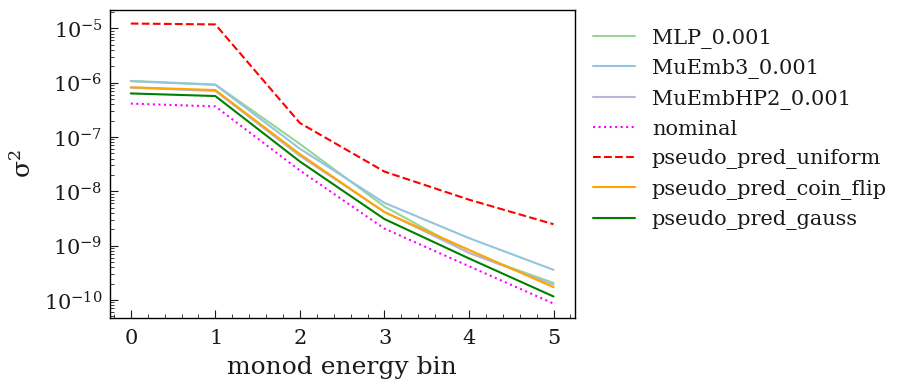

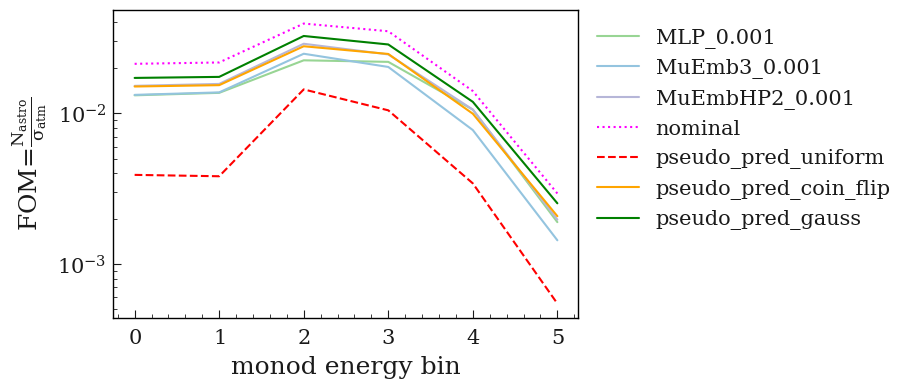

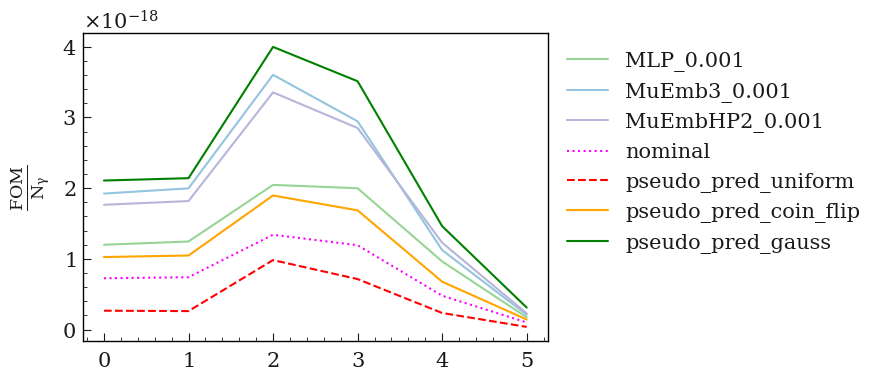

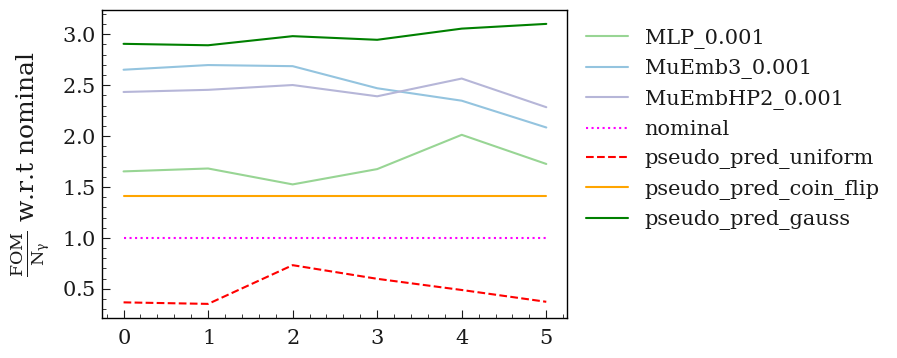

In [12]:

from uncertainties import unumpy

def reverse_cumsum(x):
    return np.cumsum(x[::-1])[::-1]
def convert_hist_to_uarray(h):
    from uncertainties import unumpy
    return unumpy.uarray(h.values(), std_devs=np.sqrt(h.variances() ))


renamefunc = lambda x: 'NOM_'+x
def fix_ax(ax, xlabel='monod energy bin', ylabel="", legend_kwargs=legend_kwargs, yscale='log', xscale='linear'):
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(**legend_kwargs)
    return ax


line_styles = {'nominal':':', 'pseudo_pred_uniform':'--'}

plt_kwargs = dict(color=[colors[h] for h in pred_names], 
             style=[line_styles.get(h, '') for h in pred_names])

plt_kwargs2 = dict(color=[colors[h] for h in pred_names], 
             style=[line_styles.get(h, '--') for h in pred_names])

legend_kwargs = dict(ncol=1, 
                     fontsize=15, 
                     loc='upper left', 
                     #bbox_to_anchor=(0.5, 1.15),
                     bbox_to_anchor=(1, 1),
                     )

di = {hname: convert_hist_to_uarray(h) for hname, h in hists.items()}
#pd.DataFrame( )

df_hists = pd.DataFrame(di)
#df_hists.head().style.format("{:.3e}")


di = {hname: convert_hist_to_uarray(h) for hname, h in hists_pred.items()}
df_hists_pred = pd.DataFrame(di)
# df_hists_pred.head().style.format("{:.2e}")


df_n_sim_gamma = pd.Series(n_simulated_photons)
df_cpu_hour = df_n_sim_gamma * 5E-9/3600

## STD and Variances
df_std = reverse_cumsum(df_hists_pred).map(lambda x: x.std_dev)
df_variances = df_std**2


ax = df_variances.plot(**plt_kwargs)
fix_ax(ax, ylabel=r"$\sigma^2$")


## FOM:

signal = reverse_cumsum(df_hists['astro']).apply(lambda x: x.nominal_value )
df_foms = reverse_cumsum(df_hists_pred).apply(lambda x: signal/x.apply(lambda y: y.std_dev)  )
# plt.plot(df_foms)

# df_foms_nom = reverse_cumsum(df_hists_pred_nom).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )
# df_foms_nom.rename(columns=renamefunc, inplace=True)

ax = df_foms.plot(**plt_kwargs)
fix_ax(ax, ylabel=r"FOM=$\frac{N_{astro}}{\sigma_{atm}}$")
#ax.legend(**legend_kwargs)



df_foms_per_sim_gamma = df_foms/df_n_sim_gamma.T

ax = df_foms_per_sim_gamma.plot(**plt_kwargs, ylabel=r"$\frac{FOM}{N_{\gamma}}$")
ax.legend(**legend_kwargs, )

df_fom_gain = df_foms_per_sim_gamma.apply(lambda x: x/x['nominal'], axis=1)
ax = df_fom_gain.plot(**plt_kwargs, ylabel=r"$\frac{FOM}{N_{\gamma}}$ w.r.t nominal")
ax.legend(**legend_kwargs, )





# CPU Uncertainty


In [13]:


df_truth = df_corsika[truth_mask]


label_cpu_gain = r"$\frac{\sigma^2_{nom} }{\sigma^2_{model}} \cdot \frac{ N^{\gamma}_{nom} }{ N^{\gamma}_{model} }$"
marker_kwargs = dict(marker="o", lw=1, markersize=4)


def get_cpu_gain_plot(df, var, bins, pred_names=pred_names, frac=0.5, plot=False):
    if frac:
        df = df.sample(frac=frac)

    hists_pred = {}
    for pred_name in pred_names:
        # if pred_name in ['pseudo_pred_gauss']:
        #     continue
        h = get_pred_hist(df, var, bins, pred_name, 'weights')
        hists_pred[pred_name] = h

    di = {hname: convert_hist_to_uarray(h) for hname, h in hists_pred.items()}
    df_hists_pred = pd.DataFrame(di)

    df_std = reverse_cumsum(df_hists_pred).map(lambda x: x.std_dev)
    df_variances = df_std**2


    # ax = df_variances.plot(**plt_kwargs)
    #a = ( (df_foms.T/df_foms['nominal']).T )**2 * df_n_sim_gamma['nominal']/df_n_sim_gamma
    res = ( 1.0/(df_variances.T/df_variances['nominal']).T ) * df_n_sim_gamma['nominal']/df_n_sim_gamma
    if plot:
        ax = res.plot(**plt_kwargs)
    return res
    # fix_ax(ax)






In [8]:

print(pred_names)

frac = 1.0

results = []
for i in range(1):
    res = get_cpu_gain_plot(df_truth, var, bins, frac=1.0) 
    results.append(res)

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear', ylabel=label_cpu_gain)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)

ax.set_title('frac = {}'.format(frac))







NameError: name 'pred_names' is not defined

['MLP_0.001', 'MuEmb3_0.001', 'MuEmbHP2_0.001', 'nominal', 'pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']


Text(0.5, 1.0, 'frac = 0.9')

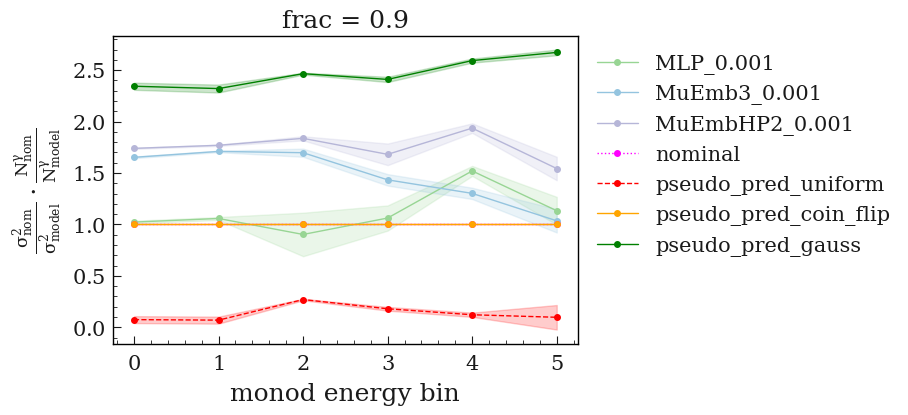

In [ ]:

print(pred_names)

frac = 0.9

results = []
for i in range(100):
    res = get_cpu_gain_plot(df_truth, var, bins, frac=frac) 
    results.append(res)

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear', ylabel=label_cpu_gain)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)

ax.set_title('frac = {}'.format(frac))







['MLP_0.001', 'MuEmb3_0.001', 'MuEmbHP2_0.001', 'nominal', 'pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']


Text(0.5, 1.0, 'frac = 0.5')

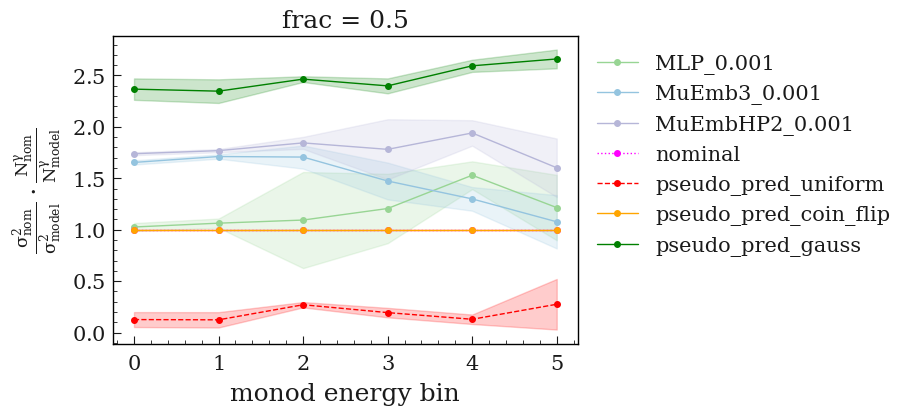

In [172]:
marker_kwargs = dict(marker="o", lw=1, markersize=4)

print(pred_names)

frac = 0.5

results = []
for i in range(100):
    res = get_cpu_gain_plot(df_truth, var, bins, frac=frac) 
    results.append(res)

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear', ylabel=label_cpu_gain)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)
ax.set_title('frac = {}'.format(frac))


In [2]:
(df_variances['nominal'] / df_variances.T).T

NameError: name 'df_variances' is not defined

['MLP_0.001', 'MuEmb3_0.001', 'MuEmbHP2_0.001', 'nominal', 'pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']


Text(0.5, 1.0, 'frac = 0.25')

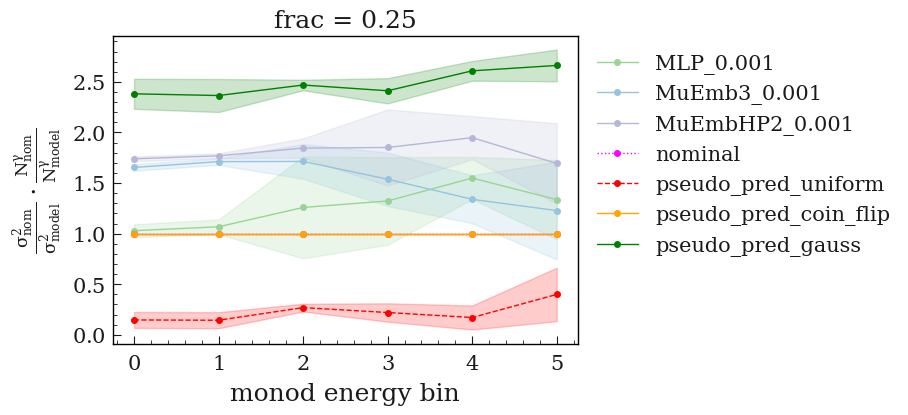

In [14]:
marker_kwargs = dict(marker="o", lw=1, markersize=4)

print(pred_names)

frac = 0.25

results = []
for i in range(100):
    res = get_cpu_gain_plot(df_truth, var, bins, frac=frac) 
    results.append(res)

res = ( 1.0/(df_variances.T/df_variances['nominal']).T ) * 1.0/(df_n_sim_gamma/df_n_sim_gamma['nominal'])
res = (df_variances['nominal'] / df_variances.T).T * 1.0/(df_n_sim_gamma/df_n_sim_gamma['nominal']) 
df_means = res


g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear', ylabel=label_cpu_gain)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)
ax.set_title('frac = {}'.format(frac))


In [1]:
marker_kwargs = dict(marker="o", lw=1, markersize=4)

print(pred_names)

frac = 0.25

results = []
for i in range(100):
    res = get_cpu_gain_plot(df_truth, var, bins, frac=frac) 
    results.append(res)

res = ( 1.0/(df_variances.T/df_variances['nominal']).T ) * 1.0/(df_n_sim_gamma/df_n_sim_gamma['nominal'])
res = (df_variances['nominal'] / df_variances.T).T * 1.0/(df_n_sim_gamma/df_n_sim_gamma['nominal']) 
df_means = res


g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear', ylabel=label_cpu_gain)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)
ax.set_title('frac = {}'.format(frac))


NameError: name 'pred_names' is not defined

In [159]:
df_variances

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001       nominal  \
0  1.075337e-06  1.060770e-06    8.050797e-07  4.110174e-07   
1  9.218681e-07  9.092396e-07    7.019871e-07  3.645985e-07   
2  7.431054e-08  6.079984e-08    4.482295e-08  2.418465e-08   
3  5.247313e-09  6.130826e-09    4.181045e-09  2.060843e-09   
4  7.386102e-10  1.377452e-09    7.372911e-10  4.183033e-10   
5  2.063591e-10  3.591028e-10    1.912108e-10  8.598676e-11   

   pseudo_pred_uniform  pseudo_pred_coin_flip  pseudo_pred_gauss  
0         1.220876e-05           8.220347e-07       6.322237e-07  
1         1.177012e-05           7.291970e-07       5.662970e-07  
2         1.806304e-07           4.836929e-08       3.534378e-08  
3         2.305174e-08           4.121685e-09       3.085220e-09  
4         7.015276e-09           8.366065e-10       5.820673e-10  
5         2.478562e-09           1.719735e-10       1.160912e-10

<Axes: >

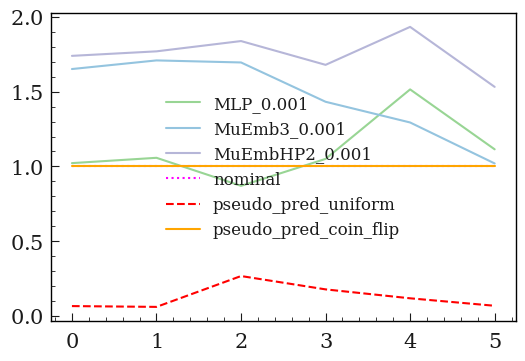

In [13]:
a = ( (df_foms.T/df_foms['nominal']).T )**2 * df_n_sim_gamma['nominal']/df_n_sim_gamma
a.plot(**plt_kwargs)

In [22]:
1.0/( df_foms.T/df_foms['nominal'] ).T**2

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform  \
0   2.616282      2.580839        1.958749      1.0            29.703764   
1   2.528447      2.493811        1.925370      1.0            32.282418   
2   3.072633      2.513985        1.853364      1.0             7.468804   
3   2.546198      2.974912        2.028804      1.0            11.185592   
4   1.765729      3.292951        1.762575      1.0            16.770790   
5   2.399894      4.176257        2.223724      1.0            28.824932   

   pseudo_pred_coin_flip  
0                    2.0  
1                    2.0  
2                    2.0  
3                    2.0  
4                    2.0  
5                    2.0

In [18]:
(df_variances.T/df_variances['nominal'].T).T

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform  \
0   2.616282      2.580839        1.958749      1.0            29.703764   
1   2.528447      2.493811        1.925370      1.0            32.282418   
2   3.072633      2.513985        1.853364      1.0             7.468804   
3   2.546198      2.974912        2.028804      1.0            11.185592   
4   1.765729      3.292951        1.762575      1.0            16.770790   
5   2.399894      4.176257        2.223724      1.0            28.824932   

   pseudo_pred_coin_flip  
0                    2.0  
1                    2.0  
2                    2.0  
3                    2.0  
4                    2.0  
5                    2.0

<Axes: >

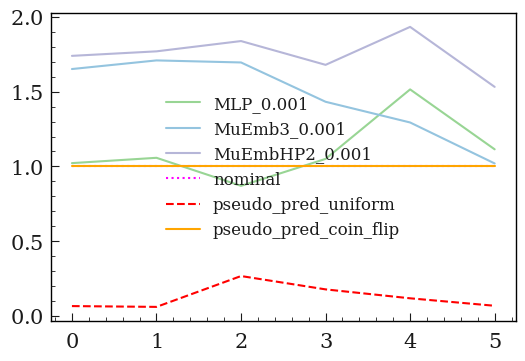

In [15]:
a = ( 1.0/(df_variances.T/df_variances['nominal']).T ) * df_n_sim_gamma['nominal']/df_n_sim_gamma
a.plot(**plt_kwargs)

In [27]:
df_n_sim_gamma['nominal'] / df_n_sim_gamma['pseudo_pred_coin_flip']

2.0

In [52]:
1.220876e-05/1.220876e-05


1.0

In [57]:
df_variances_increase = df_variances.apply(lambda x: x/x['nominal'], axis=1)
df_variances_increase

df_nominal_factor


MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   0.382221      0.387471        0.510530      1.0             0.033666
1   0.395499      0.400993        0.519381      1.0             0.030977
2   0.325453      0.397775        0.539559      1.0             0.133890
3   0.392742      0.336144        0.492901      1.0             0.089401
4   0.566337      0.303679        0.567352      1.0             0.059627
5   0.416684      0.239449        0.449696      1.0             0.034692

In [58]:
df_variances.apply(lambda x: x['nominal']/x, axis=1)

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   0.382221      0.387471        0.510530      1.0             0.033666
1   0.395499      0.400993        0.519381      1.0             0.030977
2   0.325453      0.397775        0.539559      1.0             0.133890
3   0.392742      0.336144        0.492901      1.0             0.089401
4   0.566337      0.303679        0.567352      1.0             0.059627
5   0.416684      0.239449        0.449696      1.0             0.034692

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   6.997956     10.995900        6.671445      1.0            59.473954
1   6.763017     10.625108        6.557760      1.0            64.637029
2   8.218597     10.711059        6.312509      1.0            14.954311
3   6.810495     12.674883        6.910053      1.0            22.396198
4   4.722917     14.029919        6.003287      1.0            33.579084
5   6.419165     17.793315        7.573947      1.0            57.714324

In [88]:
( df_n_sim_gamma['nominal']/df_variances['nominal'] )


0    7.132867e+22
1    8.040988e+22
2    1.212229e+24
3    1.422589e+25
4    7.008629e+25
5    3.409516e+26
Name: nominal, dtype: float64

In [141]:
1.0/df_nominal_factor

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   1.617495      1.606500        1.399553      1.0             5.450116
1   1.590111      1.579181        1.387577      1.0             5.681762
2   1.752896      1.585555        1.361383      1.0             2.732911
3   1.595683      1.724794        1.424361      1.0             3.344487
4   1.328808      1.814650        1.327620      1.0             4.095215
5   1.549161      2.043589        1.491216      1.0             5.368886

In [158]:
df_variances

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001       nominal  \
0  1.075340e-06  1.060770e-06    8.050795e-07  4.110174e-07   
1  9.218704e-07  9.092402e-07    7.019869e-07  3.645985e-07   
2  7.431080e-08  6.079986e-08    4.482295e-08  2.418465e-08   
3  5.247325e-09  6.130829e-09    4.181045e-09  2.060843e-09   
4  7.386114e-10  1.377453e-09    7.372911e-10  4.183033e-10   
5  2.063596e-10  3.591029e-10    1.912108e-10  8.598676e-11   

   pseudo_pred_uniform  
0         1.220876e-05  
1         1.177012e-05  
2         1.806304e-07  
3         2.305174e-08  
4         7.015276e-09  
5         2.478562e-09

In [145]:
1.0/df_variances.apply(lambda x: x['nominal']/x, axis=1)

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   2.616289      2.580841        1.958748      1.0            29.703764
1   2.528454      2.493812        1.925370      1.0            32.282418
2   3.072643      2.513986        1.853364      1.0             7.468804
3   2.546204      2.974914        2.028804      1.0            11.185592
4   1.765732      3.292953        1.762576      1.0            16.770790
5   2.399899      4.176258        2.223724      1.0            28.824932

<Axes: >

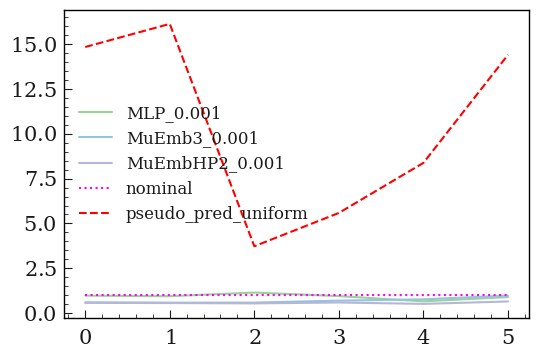

In [157]:
# ( (df_variances/df_n_sim_gamma).T * (df_n_sim_gamma['nominal']/df_variances['nominal']) ).T


df_n_sim_gamma_downsamp = df_n_sim_gamma['nominal'] * (df_variances.T/df_variances['nominal'])
df_comp_gain = 1.0/ (df_n_sim_gamma_downsamp.T/df_n_sim_gamma)
# df_comp_gain.plot(**plt_kwargs)

#sigma2_model / sigma2_nominal * 1.0/(n_gamma/n_gamma_nom)

a = df_variances.apply(lambda x: x/df_variances['nominal'] * df_n_sim_gamma[x.name]/df_n_sim_gamma['nominal'], axis=0)
#1.0/df_nominal_factor
a.plot(**plt_kwargs)

MLP_0.001                0.373865
MuEmb3_0.001             0.234709
MuEmbHP2_0.001           0.293602
nominal                  1.000000
pseudo_pred_uniform      0.499442
pseudo_pred_coin_flip    0.500000
dtype: float128


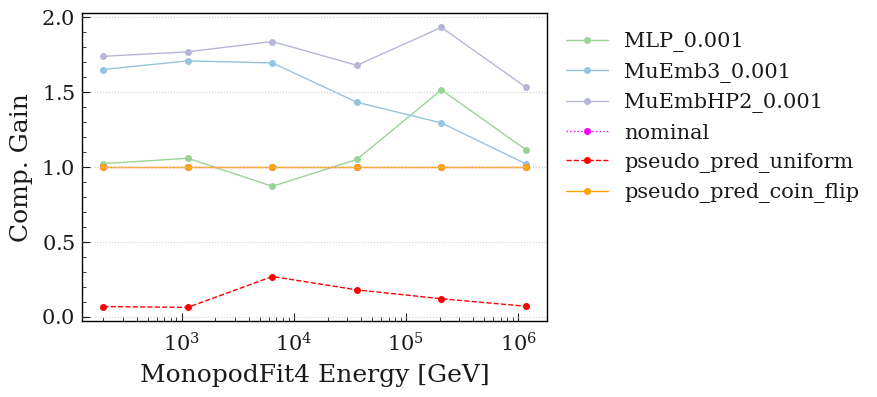

plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2



In [150]:


# print( df_n_sim_gamma )
print( df_n_sim_gamma/df_n_sim_gamma['nominal'] )


# df_variances_increase = df_variances.apply(lambda x: x/x['nominal'], axis=1)
# df_nominal_factor = 1.0/df_variances_increase
# df_nominal_factor

df_nominal_factor = df_variances.apply(lambda x: x['nominal']/x, axis=1)

h_nom = hists_pred['nominal']

df_down_sampled_nominal_gamma = df_nominal_factor / (df_n_sim_gamma/df_n_sim_gamma['nominal']) 
df_down_sampled_nominal_gamma.set_index(h_nom.axes[0].centers, inplace=True)

ax = df_down_sampled_nominal_gamma.plot(**plt_kwargs, marker="o", lw=1, markersize=4)
plt.grid(axis='y', linestyle=':', alpha=0.9)
fix_ax(ax, ylabel=r"Comp. Gain", yscale='linear', xscale='log', xlabel=var_info['label'])
plt.show()
print(f"""plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2
""")


In [237]:
np.mean(df_down_sampled_nominal_gamma['pseudo_pred_uniform'])

0.12756014501517859255

MLP_0.001              0.373865
MuEmb3_0.001           0.234709
MuEmbHP2_0.001         0.293602
nominal                1.000000
pseudo_pred_uniform    0.499442
dtype: float128

plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2
      
      



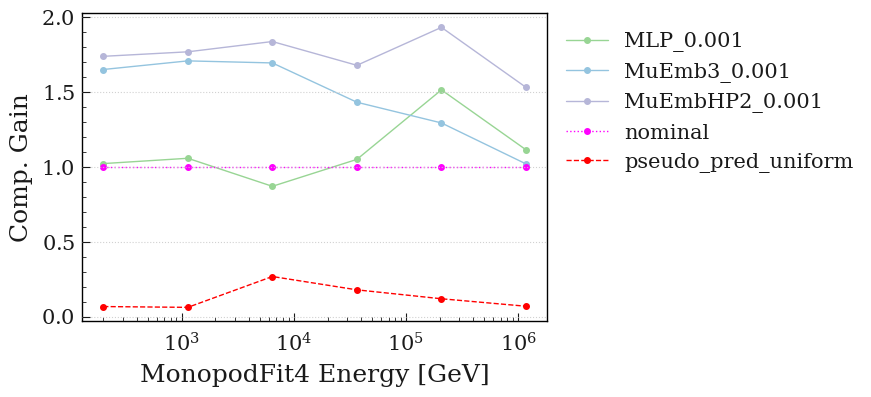

In [18]:

# print( df_n_sim_gamma )
print( df_n_sim_gamma/df_n_sim_gamma['nominal'] )

df_nominal_factor

h_nom = hists_pred['nominal']

df_down_sampled_nominal_gamma = df_nominal_factor / (df_n_sim_gamma/df_n_sim_gamma['nominal'])
df_down_sampled_nominal_gamma.set_index(h_nom.axes[0].centers, inplace=True)

ax = df_down_sampled_nominal_gamma.plot(**plt_kwargs, marker="o", lw=1, markersize=4)
plt.grid(axis='y', linestyle=':', alpha=0.9)
fix_ax(ax, ylabel=r"Comp. Gain", yscale='linear', xscale='log', xlabel=var_info['label'])
print(f"""
plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2
      
      
""")


MLP_0.001              0.373865
MuEmb3_0.001           0.234709
MuEmbHP2_0.001         0.293602
nominal                1.000000
pseudo_pred_uniform    0.499442
dtype: float64

plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2
      
      



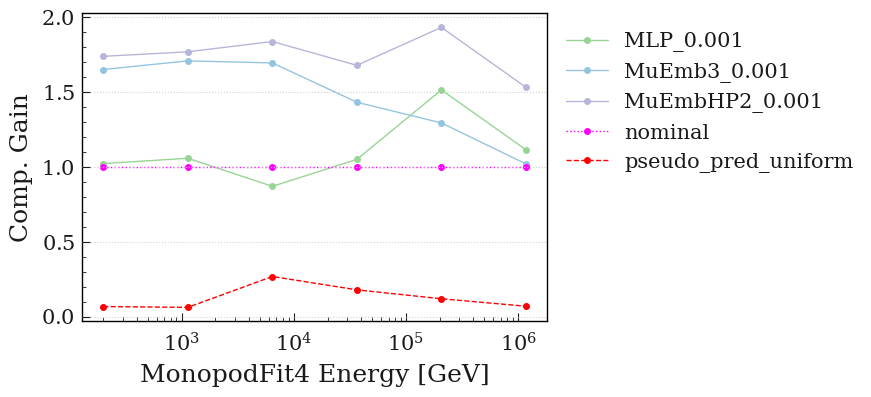


plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2



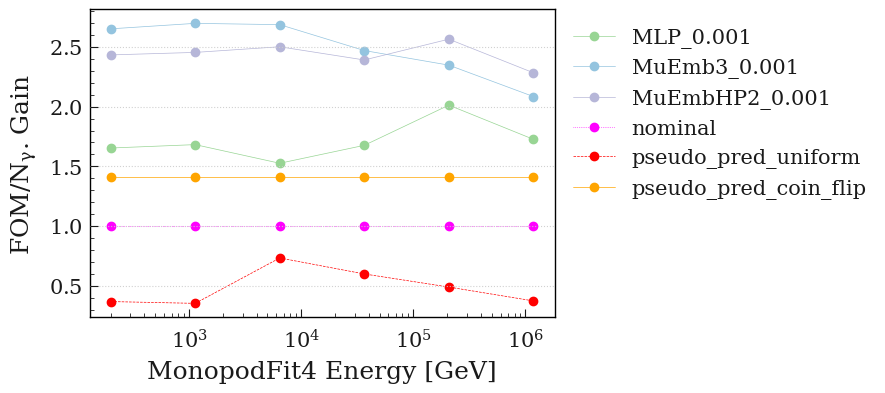

In [151]:
df_fom_gain2 = df_fom_gain.set_index(df_down_sampled_nominal_gamma.index)
ax = df_fom_gain2.plot(**plt_kwargs, marker="o", lw=0.5)
plt.grid(axis='y', linestyle=':', alpha=0.9)
fix_ax(ax, ylabel=r"FOM/$N_{\gamma}$. Gain", yscale='linear', xscale='log', xlabel=var_info['label'])
print(f"""
plot shows the gain in the computation time by down-sampling the nominal sample.
for each bin the down-sampling factor is the sigma_RejSamp^2 / sigma_nominal^2
""")


In [11]:
df_variances.apply(lambda x: x/x['nominal'], axis=1)
df_n_sim_gamma['pseudo_pred_coin_flip']/df_n_sim_gamma['nominal']

NameError: name 'df_variances' is not defined

In [135]:
df_corsika['pseudo_pred_cointoss'] = 0.5

0          0.151841
1          0.206174
2          0.663995
3          0.301688
4          0.603410
             ...   
2688843    0.300920
2688844    0.814915
2688845    0.709057
2688846    0.045391
2688847    0.021594
Name: pseudo_pred_uniform, Length: 2688848, dtype: float64

In [138]:
# hnomnom = utils.make_hist(df_corsika[var], bins=bins,  weights=df_corsika['weights'].astype('float128') )
var = 'cscdSBU_MonopodFit4_energy'

hnom = get_pred_hist(df_corsika, var, bins=bins, pred_name='nominal', weight_cols='weights')
huni = get_pred_hist(df_corsika, var, bins=bins, pred_name='pseudo_pred_uniform', weight_cols='weights')
# df_corsika['pseudo_pred_cointoss'] = 0.5
hcoin = get_pred_hist(df_corsika, var, bins=bins, pred_name='pseudo_pred_coin_flip', weight_cols='weights')

# upred = np.random.uniform(size=len(df_corsika))
# df_corsika['upred'] = upred
# huni2 = get_pred_hist(df_corsika, var, bins=bins, pred_name='upred', weight_cols='weights')


unom = convert_hist_to_uarray(hnom)
uuni = convert_hist_to_uarray(huni)
ucoin = convert_hist_to_uarray(hcoin)
# uuni2 = convert_hist_to_uarray(huni2)

print( unumpy.nominal_values(ucoin)/unumpy.nominal_values(unom) )
print( unumpy.std_devs(ucoin)/unumpy.std_devs(unom) )
print( unumpy.std_devs(ucoin)**2/unumpy.std_devs(unom)**2 )



# print(unom, uuni)

# print( unumpy.nominal_values(uuni)/unumpy.nominal_values(unom) )
# print( unumpy.std_devs(uuni)/unumpy.std_devs(unom) )
# print( unumpy.std_devs(uuni)**2/unumpy.std_devs(unom)**2 )


[1. 1. 1. 1. 1. 1.]
[1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356]
[2. 2. 2. 2. 2. 2.]


In [84]:
print( unumpy.nominal_values(uuni)/unumpy.nominal_values(unom) )
print( unumpy.std_devs(uuni)/unumpy.std_devs(unom) )

[1. 1. 1. 1. 1. 1.]
[3.07402701 5.83483485 2.668817   3.12461435 3.69482614 5.36892786]


In [92]:
upred = np.random.uniform(size=len(df_corsika))
df_corsika['upred'] = upred
huni2 = get_pred_hist(df_corsika, var, bins=bins, pred_name='upred', weight_cols='weights')
uuni2 = convert_hist_to_uarray(huni2)

print( unumpy.nominal_values(uuni2)/unumpy.nominal_values(unom) )
print( unumpy.std_devs(uuni2)/unumpy.std_devs(unom) )





[1. 1. 1. 1. 1. 1.]
[5.97320493 3.31586323 3.04262096 2.89861855 3.13475144 2.5672027 ]


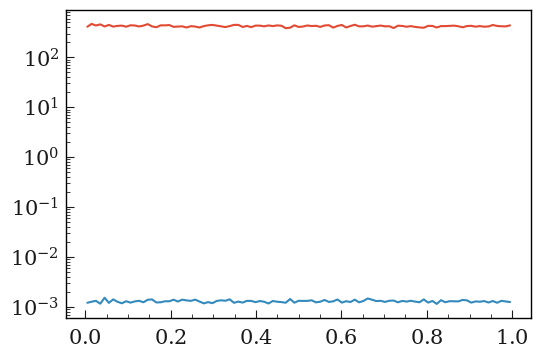

In [119]:

# m = df_corsika.sample(frac=0.5).index
# m = np.random.uniform(size=len(df_corsika)) > 0.5

w, m = speedup_utils.get_weight_from_pred(df_corsika['pseudo_pred_uniform'])

# var='pseudo_pred_uniform'
cls0 = df_corsika[mf.labels[0]]==0
cls1 = df_corsika[mf.labels[0]]==1

# m = np.ones(len(df_corsika))

h0 = get_pred_hist(df_corsika[cls0], var, bins=np.linspace(0,1,100), pred_name='pseudo_pred_uniform',     weight_cols='weights')

h1 = get_pred_hist(df_corsika[cls1], var, bins=np.linspace(0,1,100), pred_name='pseudo_pred_uniform',     weight_cols='weights')


plt.plot(h1.axes[0].centers, h1.values() )
plt.plot(h0.axes[0].centers, h0.values() )
plt.yscale('log')


In [120]:
np.mean(h1.values()), np.mean(h0.values())

(0.0012890989187612015, 423.1652896569674)

In [118]:
np.mean(h1.values()), np.mean(h0.values())

(0.0012840852653977887, 420.02773627844243)

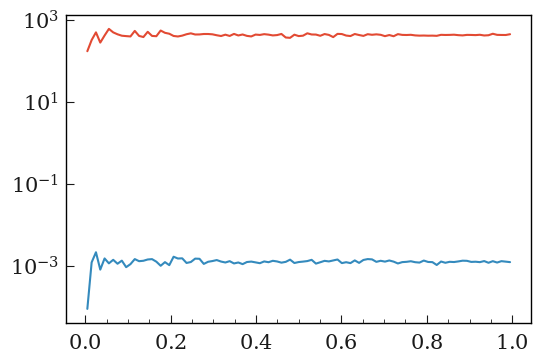

In [115]:

# m = df_corsika.sample(frac=0.5).index
# m = np.random.uniform(size=len(df_corsika)) > 0.5

w, m = speedup_utils.get_weight_from_pred(df_corsika['pseudo_pred_uniform'])

# var='pseudo_pred_uniform'
cls0 = df_corsika[mf.labels[0]]==0
cls1 = df_corsika[mf.labels[0]]==1

# m = np.ones(len(df_corsika))

h0 = utils.make_hist(df_corsika[m& cls0][var], 
                        bins=np.linspace(0,1,100), 
                        weights=df_corsika[m& cls0]['weights']*1.0/df_corsika[m& cls0]['pseudo_pred_uniform']  
                          ) 
h1 = utils.make_hist(df_corsika[m & cls1][var], 
                        bins=np.linspace(0,1,100), 
                        weights=df_corsika[m& cls1]['weights']*1.0/df_corsika[m& cls1]['pseudo_pred_uniform']
                          ) 



plt.plot(h1.axes[0].centers, h1.values() )
plt.plot(h0.axes[0].centers, h0.values() )
plt.yscale('log')


In [24]:
pred_names

['MLP',
 'MuEmb3',
 'MuEmbHP2',
 'nominal',
 'pseudo_pred_uniform',
 'pseudo_pred_gauss',
 'pseudo_pred_coin_flip']

# CPU Uncertainty

In [135]:
## estimate the uncertainty 
from uncertainties import unumpy

df_truth = df_corsika[truth_mask]




def get_cpu_gain_plot(df, var, bins, pred_names, frac=0.5, plot=False):
    if frac:
        df = df.sample(frac=frac)

    hists_pred = {}
    for pred_name in pred_names:
        # if pred_name in ['pseudo_pred_gauss']:
        #     continue
        h = get_pred_hist(df, var, bins, pred_name, 'weights')
        hists_pred[pred_name] = h

    di = {hname: convert_hist_to_uarray(h) for hname, h in hists_pred.items()}
    df_hists_pred = pd.DataFrame(di)

    df_std = reverse_cumsum(df_hists_pred).map(lambda x: x.std_dev)
    df_variances = df_std**2


    # ax = df_variances.plot(**plt_kwargs)
    #a = ( (df_foms.T/df_foms['nominal']).T )**2 * df_n_sim_gamma['nominal']/df_n_sim_gamma
    res = ( 1.0/(df_variances.T/df_variances['nominal']).T ) * df_n_sim_gamma['nominal']/df_n_sim_gamma
    if plot:
        ax = res.plot(**plt_kwargs)
    return res
    # fix_ax(ax)





In [148]:
marker_kwargs = dict(marker="o", lw=1, markersize=4)

print(pred_names)
df_stds

['MLP_0.001', 'MuEmb3_0.001', 'MuEmbHP2_0.001', 'nominal', 'pseudo_pred_uniform', 'pseudo_pred_coin_flip', 'pseudo_pred_gauss']


MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_coin_flip  \
0   0.038292      0.018622        0.013943      0.0           2.769876e-16   
1   0.043825      0.019184        0.016289      0.0           2.605456e-16   
2   0.465141      0.120362        0.068561      0.0           2.637782e-16   
3   0.319640      0.166672        0.290943      0.0           2.836958e-16   
4   0.135195      0.139107        0.125577      0.0           2.580113e-16   
5   0.350229      0.308585        0.317997      0.0           2.331244e-16   

   pseudo_pred_gauss  pseudo_pred_uniform  
0                NaN             0.075285  
1                NaN             0.076636  
2                NaN             0.019861  
3                NaN             0.049082  
4                NaN             0.066988  
5                NaN             0.246123

Text(0.5, 1.0, 'frac = 0.5')

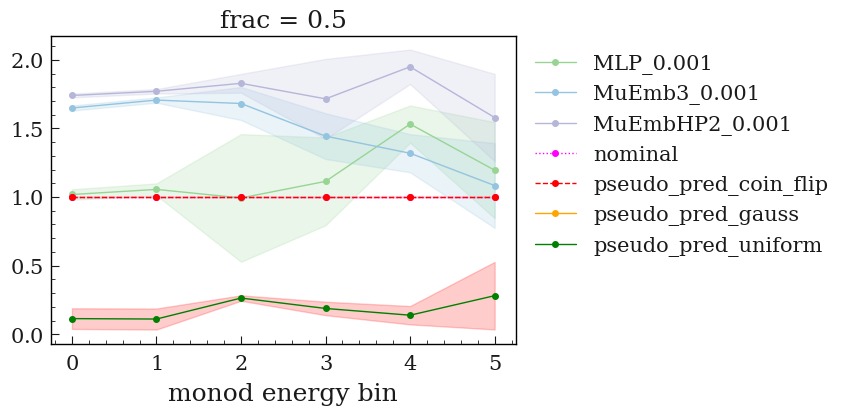

In [145]:

frac = 0.5

# results = []
# for i in range(100):
#     res = get_cpu_gain_plot(df_truth, var, bins, pred_names, frac=frac) 
#     results.append(res)

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())

ax = df_means.plot(**plt_kwargs,**marker_kwargs)
fix_ax(ax, yscale='linear')

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)
ax.set_title('frac = {}'.format(frac))


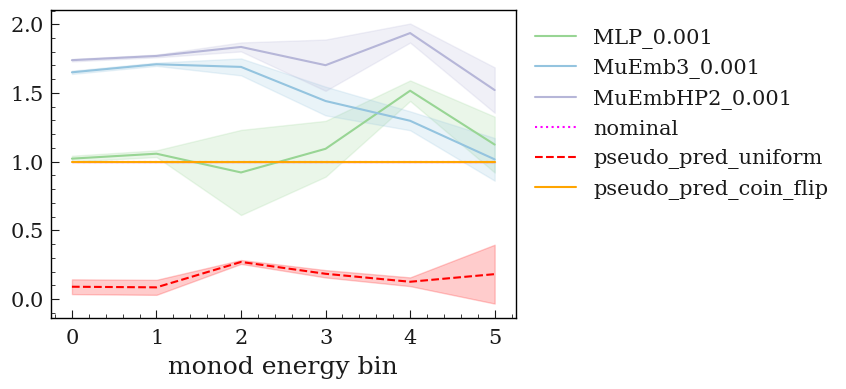

In [ ]:

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())



ax = df_means.plot(**plt_kwargs)
fix_ax(ax, yscale='linear')

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color=colors[col], alpha=0.2)
    


MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform  \
0   0.012775      0.006439        0.004958      0.0             0.044468   
1   0.014662      0.006629        0.005469      0.0             0.045137   
2   0.202468      0.039319        0.020770      0.0             0.008704   
3   0.131513      0.055317        0.104540      0.0             0.015403   
4   0.045450      0.046538        0.040909      0.0             0.018169   
5   0.137656      0.114514        0.114314      0.0             0.167666   

   pseudo_pred_coin_flip  
0           2.662550e-16  
1           2.513608e-16  
2           2.826939e-16  
3           2.662615e-16  
4           2.627080e-16  
5           2.219671e-16

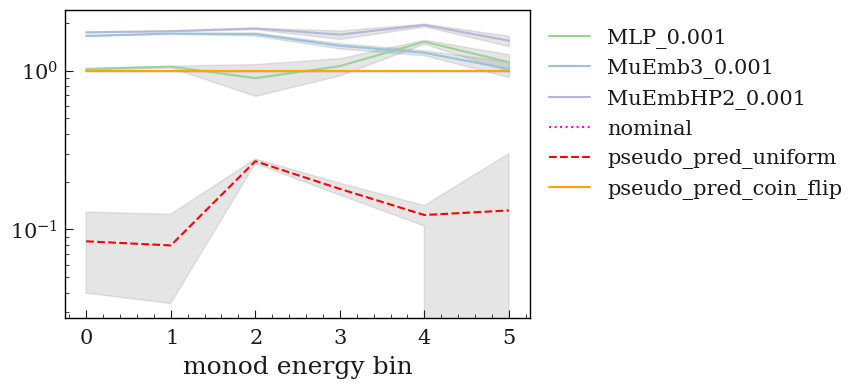

In [ ]:

g = pd.concat(results, axis=0).groupby(level=0)
df_means = g.apply(lambda x: x.mean())
df_stds = g.apply(lambda x: x.std())



ax = df_means.plot(**plt_kwargs)
fix_ax(ax)

for col in df_means.columns:
    ax.fill_between(df_means[col].index, df_means[col] - df_stds[col], df_means[col] + df_stds[col], color='gray', alpha=0.2)



In [84]:
means

array([[1.02273072, 1.65076619, 1.73886959, 1.        , 0.08233556,
        1.        ],
       [1.05820101, 1.70824942, 1.76879355, 1.        , 0.07753418,
        1.        ],
       [0.90924697, 1.69840085, 1.83961268, 1.        , 0.26755767,
        1.        ],
       [1.05772636, 1.43065903, 1.68044455, 1.        , 0.17980775,
        1.        ],
       [1.51258509, 1.28903456, 1.92808638, 1.        , 0.12062782,
        1.        ],
       [1.12446384, 1.02287877, 1.53449811, 1.        , 0.09768364,
        1.        ]], dtype=float128)

In [50]:
pred_names

['MLP',
 'MuEmb3',
 'MuEmbHP2',
 'nominal',
 'pseudo_pred_uniform',
 'pseudo_pred_gauss',
 'pseudo_pred_coin_flip']

In [42]:
# truth = df_corsika[mf.labels[0]]==1
# df_corsika[truth]['pseudo_pred_uniform'].sum()/df_corsika[truth]['nominal'].sum()

w, m = speedup_utils.get_weight_from_pred(df_corsika['pseudo_pred_uniform']) 

sum(m)/len(m)

np.sum(w) / len(w)

15.171731492971729

In [29]:
unom = convert_hist_to_uarray(hnom)
uuni = convert_hist_to_uarray(huni)

unumpy.std_devs(unom)**2/unumpy.std_devs(uuni)**2

array([0.10582411, 0.02937263, 0.14039848, 0.10242528, 0.07325073,
       0.03469164])

<Axes: xlabel='monod energy bin'>

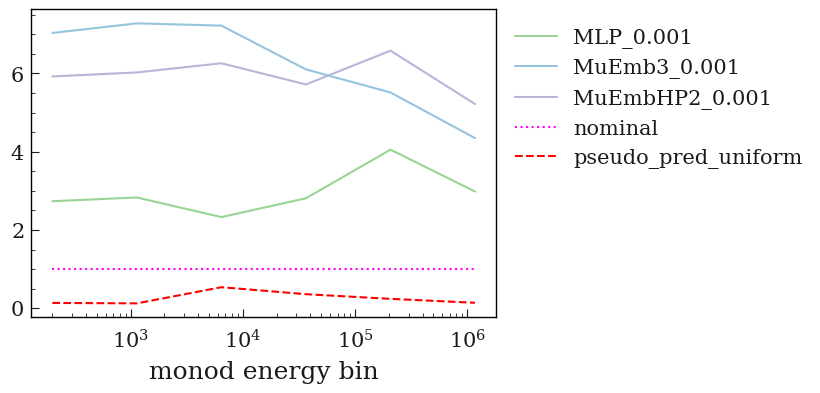

In [47]:
ax = (df_fom_gain2**2).plot(**plt_kwargs)
fix_ax(ax, xscale='log', yscale='linear')

In [69]:
np.sqrt(df_fom_gain2)

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  \
2.001901e+02   1.231278      1.602524        1.545684      1.0   
1.135680e+03   1.252925      1.644580        1.554217      1.0   
6.442715e+03   1.460110      1.662705        1.626901      1.0   
3.654955e+04   1.505993      1.789232        1.538445      1.0   
2.073458e+05   1.402682      1.758016        1.586618      1.0   
1.176273e+06   1.557216      1.512174        1.725997      1.0   

              pseudo_pred_uniform  
2.001901e+02             0.939088  
1.135680e+03             0.933083  
6.442715e+03             0.904451  
3.654955e+04             0.937414  
2.073458e+05             0.831206  
1.176273e+06             1.239673

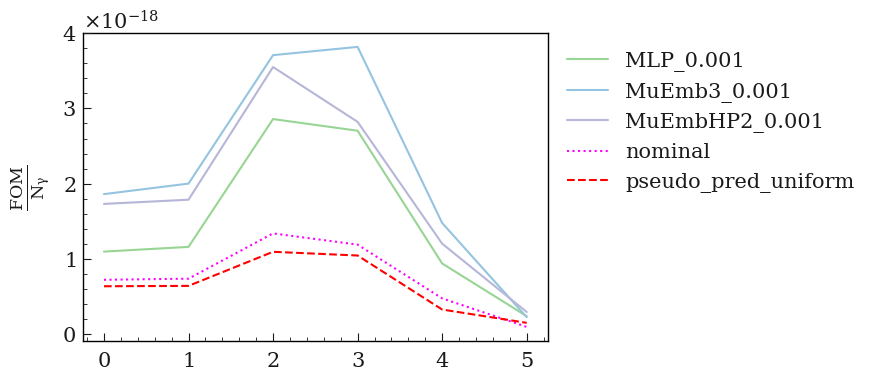

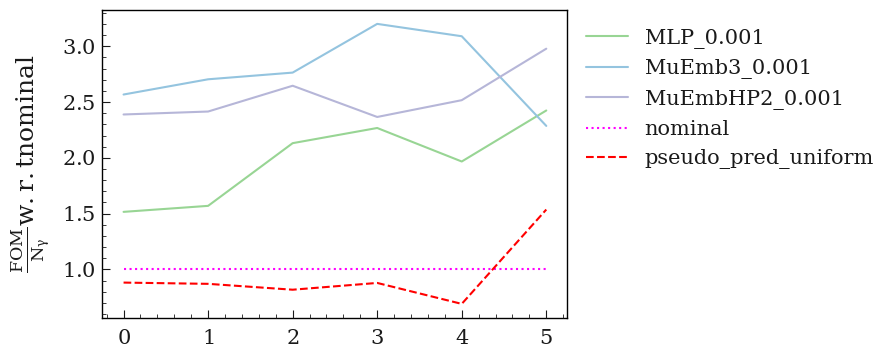

In [56]:
df_foms_per_sim_gamma = df_foms/df_n_sim_gamma.T

ax = df_foms_per_sim_gamma.plot(**plt_kwargs, ylabel=r"$\frac{FOM}{N_{\gamma}}$")
ax.legend(**legend_kwargs, )

df_fom_gain = df_foms_per_sim_gamma.apply(lambda x: x/x['nominal'], axis=1)
ax = df_fom_gain.plot(**plt_kwargs, ylabel=r"$\frac{FOM}{N_{\gamma}} w.r.t nominal$")
ax.legend(**legend_kwargs, )


# df_foms_per_sim_gamma_normed = (df_foms_per_sim_gamma.T / df_foms_per_sim_gamma['nominal']).T
# ax = df_foms_per_sim_gamma_normed.plot(**plt_kwargs)
# ax.legend(**legend_kwargs)


<Axes: xlabel='monod energy bin', ylabel='$\\sigma_{relative}^2$'>

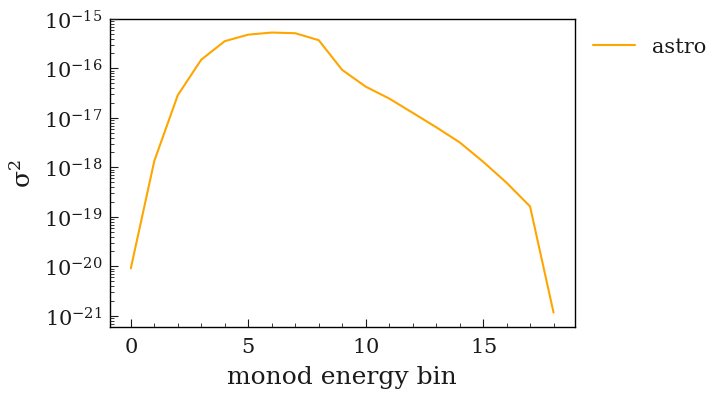

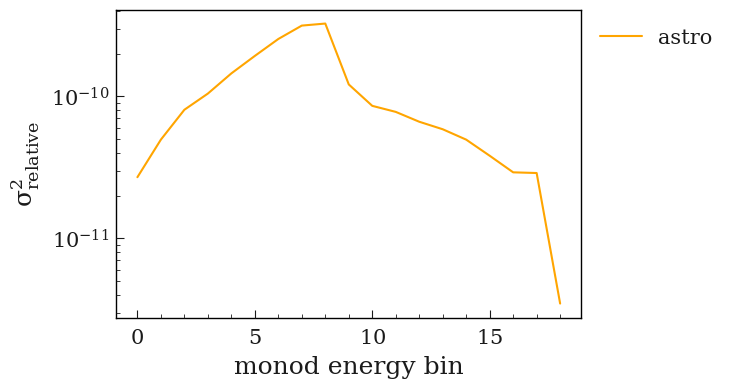

In [285]:
signal_var = hists['astro'].variances()
fig, ax = plt.subplots()
ax.plot(signal_var, label='astro', color=samples['astro']['color'])
fix_ax(ax, ylabel='$\sigma^2$')

fig, ax = plt.subplots()
ax.plot(signal_var/hists['astro'].values(), label='astro', color=samples['astro']['color'])
fix_ax(ax, ylabel='$\sigma_{relative}^2$')

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   0.566796      0.602753        0.701456      1.0             0.440451
1   0.586901      0.634805        0.709221      1.0             0.434836
2   0.797050      0.648874        0.777107      1.0             0.408559
3   0.847931      0.751387        0.694901      1.0             0.438882
4   0.735585      0.725398        0.739100      1.0             0.345066
5   0.906592      0.536703        0.874658      1.0             0.767537

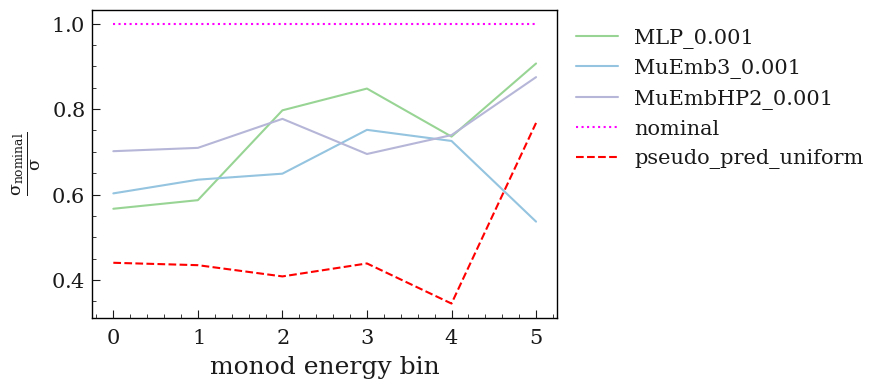

In [17]:
df_std_rel = df_std['nominal'].div(df_std.T).T
df_std_rel
ax = df_std_rel.plot(**plt_kwargs)
fix_ax(ax, ylabel=r"$\frac{\sigma_{nominal}}{\sigma}$", yscale='linear')
df_std_rel

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   0.321258      0.363312        0.492040      1.0             0.193997
1   0.344453      0.402977        0.502995      1.0             0.189082
2   0.635288      0.421038        0.603895      1.0             0.166920
3   0.718986      0.564582        0.482887      1.0             0.192618
4   0.541085      0.526202        0.546269      1.0             0.119070
5   0.821910      0.288050        0.765027      1.0             0.589112

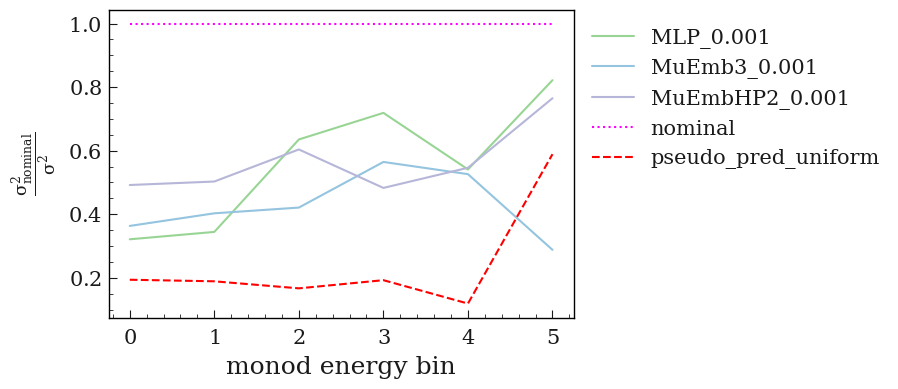

In [18]:
df_variances_rel = df_variances['nominal'].div(df_variances.T).T
df_variances_rel
ax = df_variances_rel.plot(**plt_kwargs, )
fix_ax(ax, ylabel=r"$\frac{\sigma^2_{nominal}}{\sigma^2}$", yscale='linear')
df_variances_rel


<module 'utils' from '/cephfs/users/nrad/work/i3kiss/utils/__init__.py'>

In [19]:
nom = reverse_cumsum(df_hists['astro']).apply(lambda x: x.nominal_value )
df_foms = reverse_cumsum(df_hists_pred).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )

df_foms_rel = df_foms.apply(lambda x: x['nominal']/x, axis=1)
df_foms_rel.style.format("{:.2f}")




In [20]:
df_std_rel = reverse_cumsum(df_hists_pred).apply(lambda x: x)
df_std_rel.style.format("{:.2f}")


<Axes: xlabel='monod energy bin', ylabel='$\\frac{\\sigma}{\\sigma_{nominal}}$'>

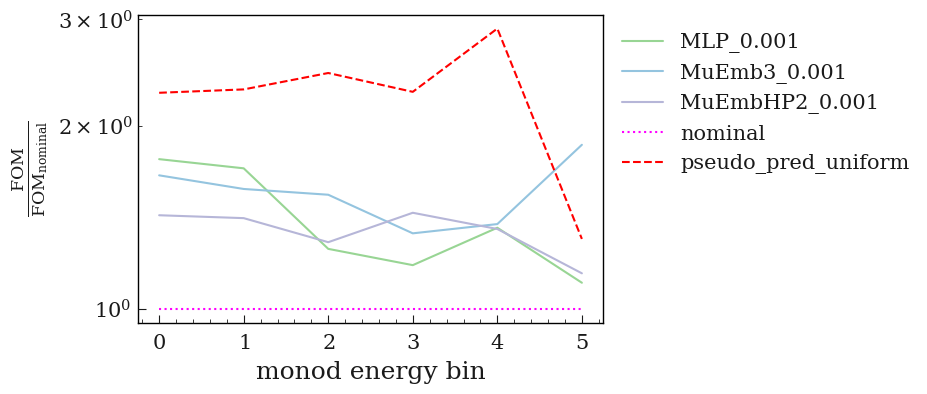

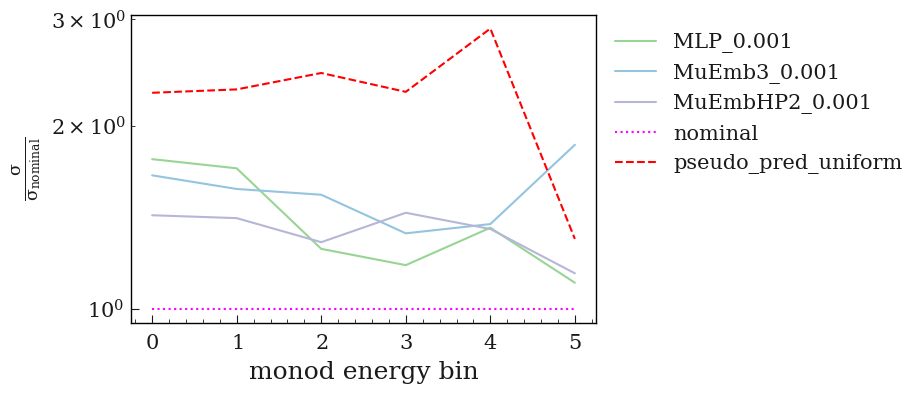

In [21]:
df_foms_rel = df_foms['nominal'].div(df_foms.T).T
ax = df_foms_rel.plot(**plt_kwargs)
fix_ax(ax, ylabel=r"$\frac{FOM}{FOM_{nominal}}$")

df_sigma_rel = df_std.T.div(df_std['nominal']).T
df_sigma_rel
ax = df_sigma_rel.plot(**plt_kwargs)
fix_ax(ax, ylabel=r"$\frac{\sigma}{\sigma_{nominal}}$")

In [322]:
df_corsika['energy'].std() / (df_corsika['energy'].sample(frac=0.9).std())

0.9989464953135927

In [151]:
np.sqrt(df_variances)

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001   nominal  pseudo_pred_uniform
0   0.001131      0.001064        0.000914  0.000641             0.001456
1   0.001029      0.000951        0.000851  0.000604             0.001389
2   0.000195      0.000240        0.000200  0.000156             0.000381
3   0.000054      0.000060        0.000065  0.000045             0.000103
4   0.000028      0.000028        0.000028  0.000020             0.000059
5   0.000010      0.000017        0.000011  0.000009             0.000012

In [287]:

df_variances_increase = df_variances.apply(lambda x: x/x['nominal'], axis=1)
df_variances_increase




MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0    2.535208      2.549919        1.912707      1.0             6.326848
1    2.534865      2.549628        1.913041      1.0             6.327959
2    2.540285      2.543772        1.908190      1.0             6.348509
3    2.442712      2.510308        1.885518      1.0             6.501583
4    2.256127      2.391152        1.808000      1.0             4.584033
5    1.799657      2.129539        1.754357      1.0             5.153515
6    1.661929      2.059175        1.868101      1.0             7.342655
7    1.559397      2.252204        1.933864      1.0            11.313840
8    1.716140      2.391348        2.049884      1.0            19.963443
9    1.488617      2.488221        2.249163      1.0            31.956737
10   1.462657      2.410201        2.555256      1.0            45.618182
11   1.463857      3.222185        3.009492      1.0            77.334902
12   1.388500      4.123807        2.883751      1.0           119.088301
13   1.404541      3.308752        3.558925      1.0             3.136107
14   1.445334      4.544318        4.899883      1.0             2.136524
15   1.279349      5.712073        7.091921      1.0             1.633227
16   1.622027      1.943681       11.073885      1.0             1.453611
17   1.716801      1.438753        2.027444      1.0             1.495567
18   1.794624      1.758571        1.166733      1.0             0.901088

In [323]:
1.0/np.sqrt(df_variances_increase[pname])

0    0.457449
1    0.464000
2    0.481882
3    0.361336
4    0.189671
5    0.507072
Name: pseudo_pred_uniform, dtype: float64

array([0.50707184, 0.50707184, 0.50707184, ..., 0.50707184, 0.50707184,
       0.50707184])

## resample nominal to match variances



/tmp/ipykernel_707790/2077921428.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[hist_name] = pred


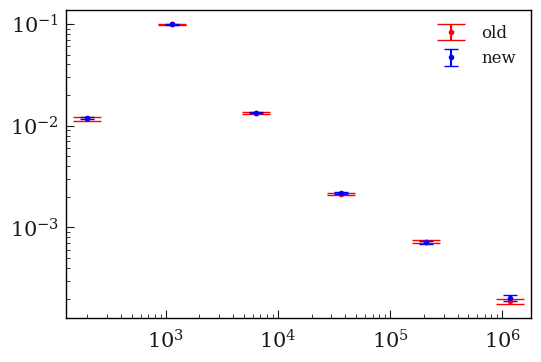

In [22]:
h = get_pred_hist(df_corsika, var, bins, pred_name='MLP', min_pred=0.001)

fig, ax = plt.subplots()
utils.plot_error_hist(hists_pred['MLP_0.001'], ax, color='red', label='old', capsize=10)
utils.plot_error_hist(h, ax, color='blue', label='new', capsize=5)

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

In [60]:
pname = 'MLP_0.001'
pname = 'pseudo_pred_uniform'


hs = []
hvals = []
n_trials = 10
for i in range(n_trials):
    #h = get_pred_hist(df_corsika, var, bins, pred_name='pseudo_pred_uniform', min_pred=None, )
    h = get_pred_hist(df_corsika, var, bins, pred_name='pseudo_pred_uniform', min_pred=None, )

    hs.append(h)
    hvals.append(h.values())

hvals = np.array(hvals)





fig, axs = utils.plt_subplots()
#utils.plot_error_hist(hists_pred['MLP_0.001'], ax, color='red', label='old', capsize=10)
ax = axs[0]
utils.plot_error_hist(hists_pred[pname], ax, color='red', label=pname, capsize=10)
utils.plot_error_hist(h, ax, color='blue', label='new', capsize=5)
ax.errorbar(h.axes[0].centers*1.3, 
            y=hvals.mean(axis=0), 
            yerr=hvals.std(axis=0), 
            fmt='o', 
            color='green', 
            label='sampling error (N=%s)'%n_trials, 
            markersize=1, 
            alpha=0.5)

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

axr = axs[1]

vals = []
for h in hs:
    vals.append( np.sqrt(h.variances()/hists_pred[pname].variances())   )
vals = np.array(vals)
means = vals.mean(axis=0)
stds = vals.std(axis=0)


axr.errorbar(x=h.axes[0].centers, y=vals.mean(axis=0), yerr=vals.std(axis=0), fmt='o')
axr.set_xlim(xmin=h.axes[0].edges[0])
axr.set_ylabel("$\sigma_{new}/\sigma_{old}$")
axr.set_ylim(0,2)
axr.hlines([0.5,1,1.5], *axr.get_xlim(), linestyle='--', color='gray', lw=1, alpha=0.5)
#plt.grid(axis="x")


<ErrorbarContainer object of 3 artists>

In [148]:
1/np.sqrt(0.25)

2.0

{'nrows': 3, 'height_ratios': [2, 1, 1], 'figsize': (6, 5), 'sharex': True, 'gridspec_kw': {'hspace': 0.05}, 'ncols': 1}


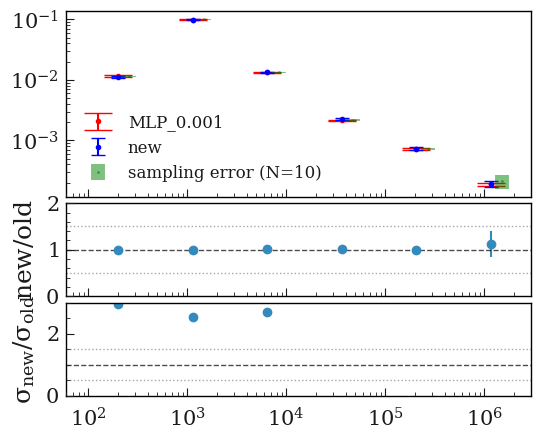

In [176]:
pname = 'MLP_0.001'
#pname = 'pseudo_pred_uniform'


hs = []
hvals = []
n_trials = 10
for i in range(n_trials):
    frac = 1.0/3.1
    df_ = df_corsika.sample(frac=frac)

    if False:
        h = get_pred_hist(df_, var, bins, pred_name='MLP', min_pred=0.001, 
                        extra_weights=np.ones(len(df_))/np.sqrt(frac),
                        ) ## keeps the same std_err as the orig sample, but the actual value is reduced
    h = get_pred_hist(df_, var, bins, pred_name='MLP', min_pred=0.001, 
                       extra_weights=np.ones(len(df_))/(frac),
                       ) ## keeps the same std_err as the orig sample, but the actual value is reduced



    hs.append(h)
    hvals.append(h.values())

hvals = np.array(hvals)


fig, axs = utils.plt_subplots(nrows=3, height_ratios=[2,1,1])
#utils.plot_error_hist(hists_pred['MLP_0.001'], ax, color='red', label='old', capsize=10)
ax = axs[0]
utils.plot_error_hist(hists_pred[pname], ax, color='red', label=pname, capsize=10)
utils.plot_error_hist(h, ax, color='blue', label='new', capsize=5)
ax.errorbar(h.axes[0].centers*1.3, 
            y=hvals.mean(axis=0), 
            yerr=hvals.std(axis=0), 
            fmt='o', 
            color='green', 
            label='sampling error (N=%s)'%n_trials, 
            markersize=1, 
            lw=10,
            alpha=0.5)

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

variance_ratios = []
value_ratios = []
for h in hs:
    variance_ratios.append( h.variances()/hists_pred[pname].variances()   )
    value_ratios.append( h.values()/hists_pred[pname].values()   )

value_ratios = np.array(value_ratios)
value_ratios_mean = value_ratios.mean(axis=0)
value_ratios_std = value_ratios.std(axis=0)

variance_ratios = np.array(variance_ratios)
variance_ratios_mean = vals.mean(axis=0)
variance_ratios_std = vals.std(axis=0)


ax1 =  axs[1]

ax1.errorbar(x=h.axes[0].centers, y=value_ratios_mean, yerr=value_ratios_std, fmt='o')
ax1.set_xlim(xmin=h.axes[0].edges[0])
ax1.set_ylabel("$new/old$")

ax1.hlines([0.5, 1.5], *axr.get_xlim(), linestyle=':', color='gray', lw=1, alpha=0.7)
ax1.hlines([1], *axr.get_xlim(), linestyle='--', color='black', lw=1, alpha=0.7)
ax1.set_ylim(0, 2)


axr = axs[2]



axr.errorbar(x=h.axes[0].centers, y=variance_ratios_mean, yerr=variance_ratios_std, fmt='o')
axr.set_xlim(xmin=h.axes[0].edges[0])
axr.set_ylabel("$\sigma_{new}/\sigma_{old}$")

axr.set_ylim( 0, max(2, min(3, np.max(variance_ratios_mean)+np.max(variance_ratios_std)) ) )

# axr.set_ylim
# axr.set_ylim(0, 3)

axr.hlines([0.5, 1.5], *axr.get_xlim(), linestyle=':', color='gray', lw=1, alpha=0.7)
axr.hlines([1], *axr.get_xlim(), linestyle='--', color='black', lw=1, alpha=0.7)



In [171]:
unumpy.nominal_values(convert_hist_to_uarray(hists_pred[pname])) / unumpy.nominal_values(convert_hist_to_uarray(h))




array([0.98023902, 0.99149209, 1.00438892, 1.01053213, 0.96450317,
       0.9080425 ])

In [146]:
from uncertainties import ufloat
for ibin in range(len(h.axes[0].centers)):
    ve = ufloat(h.values()[ibin], np.sqrt(h.variances()[ibin]))

    print(f'new: {ve.nominal_value:0.2e} old: {hists_pred[pname].values()[ibin]:0.2e} || new: {ve.std_dev:0.2e} old: {np.sqrt(hists_pred[pname].variances()[ibin]):0.2e} ')
    print(f'std ratio: {ve.std_dev/np.sqrt(hists_pred[pname].variances()[ibin]):0.2f}')


new: 6.73e-03 old: 1.16e-02 || new: 3.78e-04 old: 4.70e-04 
std ratio: 0.80
new: 5.40e-02 old: 9.94e-02 || new: 9.05e-04 old: 1.01e-03 
std ratio: 0.90
new: 7.15e-03 old: 1.33e-02 || new: 1.73e-04 old: 1.88e-04 
std ratio: 0.92
new: 1.13e-03 old: 2.13e-03 || new: 4.03e-05 old: 4.58e-05 
std ratio: 0.88
new: 3.93e-04 old: 7.25e-04 || new: 2.02e-05 old: 2.59e-05 
std ratio: 0.78
new: 1.05e-04 old: 1.88e-04 || new: 1.06e-05 old: 1.02e-05 
std ratio: 1.03


In [183]:
np.sqrt(df_variances_increase)



MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   1.617495      1.606500        1.399553      1.0             5.450116
1   1.590111      1.579181        1.387577      1.0             5.681762
2   1.752896      1.585555        1.361383      1.0             2.732911
3   1.595683      1.724794        1.424361      1.0             3.344487
4   1.328808      1.814650        1.327620      1.0             4.095215
5   1.549161      2.043589        1.491216      1.0             5.368886

In [181]:
(np.sqrt( df_variances.T )/ np.sqrt( df_variances['nominal'] )).T

MLP_0.001  MuEmb3_0.001  MuEmbHP2_0.001  nominal  pseudo_pred_uniform
0   1.617495      1.606500        1.399553      1.0             5.450116
1   1.590111      1.579181        1.387577      1.0             5.681762
2   1.752896      1.585555        1.361383      1.0             2.732911
3   1.595683      1.724794        1.424361      1.0             3.344487
4   1.328808      1.814650        1.327620      1.0             4.095215
5   1.549161      2.043589        1.491216      1.0             5.368886

## Per Bin

In [218]:
df = df_corsika
hnom = utils.make_hist(df[var], bins=bins, weights=df['weights'])
unom = convert_hist_to_uarray(hnom)

frac = (0.3)**2
print(frac)
df = df_corsika.sample(frac=frac )
hsamp = utils.make_hist(df[var], bins=bins, weights=df['weights'])
usamp = convert_hist_to_uarray(hsamp)


0.09


In [224]:
# 0.3822207972060211
1.0/(df_variances[pname]/df_variances['nominal'])

0    0.382221
1    0.395499
2    0.325453
3    0.392742
4    0.566337
5    0.416684
dtype: float64

In [220]:
# [ f"{v:0.2ue}" for v in vals]
# df_hists_pred.style.format("{:.2ue}")

from uncertainties import ufloat


pname = 'pseudo_pred_uniform'
pname = 'MLP_0.001'
hactual = hists_pred[pname]

# variance_loss = 1.0/np.sqrt(df_variances_increase[pname])

variance_increases = df_variances_increase[pname]
print(f"{variance_increases = }")

down_sampled_hist = []
for ibin, variance_increase in enumerate(variance_increases):
    # df = df_corsika.sample(frac=sample_fraction)
    # # df = df.query(f'{var} > {bins[ibin]} & {var} <= {bins[ibin+1]}')

    # # pred = np.ones(len(df))
    # # h = get_pred_hist(df, var, bins, pred_name=pred, pred_weights=pred*sample_fraction, min_pred=None)
    # h = get_pred_hist(df, var, bins, pred_name="MLP", min_pred=0.001, extra_weights=np.ones(len(df))/np.sqrt(sample_fraction)) 

    print("===============")
    # sample_fraction = 1.0/np.sqrt(variance_increase)
    sample_fraction = 1.0/(variance_increase)
    # sample_fraction = 0.5
    # sample_fraction = 1.0 
    print(f"{ibin = } {sample_fraction = }")
    
    df_ = df_corsika.sample(frac=sample_fraction)
    if False:
        h = get_pred_hist(df_, var, bins, pred_name='MLP', min_pred=0.001, 
                        extra_weights=np.ones(len(df_))/np.sqrt(frac),
                        ) ## keeps the same std_err as the orig sample, but the actual value is reduced
    if False:
        h = get_pred_hist(df_, var, bins, pred_name='MLP', min_pred=0.001, 
                       extra_weights=np.ones(len(df_))/(sample_fraction),
                       ) ## std_err and value matches the original but why?!!        
    # h = get_pred_hist__tocomplicated(df_, var, bins, pred_name='nominal', min_pred=None, 
    #                    extra_weights=np.ones(len(df_)),
    # )
    h = get_pred_hist(df_, var, bins, 'nominal', 'weights')

    

#     break
# for ibin, sample_fraction in enumerate(variance_loss):
    # print(h)

    ve = ufloat(h.values()[ibin], np.sqrt(h.variances()[ibin]) )
    down_sampled_hist.append(ve)

    print(f'new: {ve.nominal_value:0.2e} old: {hists_pred[pname].values()[ibin]:0.2e} || new: {ve.std_dev:0.2e} old: {np.sqrt(hists_pred[pname].variances()[ibin]):0.2e} ')
    print(f'val ratio: {ve.nominal_value/hists_pred[pname].values()[ibin]:0.2f} ')
    print(f'std ratio: {ve.std_dev/np.sqrt(hists_pred[pname].variances()[ibin]):0.2f} ')
    print(f'variance ratio: {ve.std_dev**2/hists_pred[pname].variances()[ibin]:0.2f} ')

# hnom = get_pred_hist(df_corsika, var, bins, pred_name='nominal', min_pred=None, 
#                     extra_weights=np.ones(len(df_corsika)),
# )


ha = convert_hist_to_uarray(hactual)
he = convert_hist_to_uarray(h)
# hn = convert_hist_to_uarray(hnom)
print( unumpy.nominal_values(ha)/unumpy.nominal_values(he) )
print( unumpy.std_devs(ha)/unumpy.std_devs(he) )

# print('--sanity--')
# print( unumpy.nominal_values(hn)/unumpy.nominal_values(ha) )
# print( unumpy.std_devs(hn)/unumpy.std_devs(ha) )

variance_increases = 0    2.616289
1    2.528454
2    3.072643
3    2.546204
4    1.765732
5    2.399899
Name: MLP_0.001, dtype: float64
ibin = 0 sample_fraction = 0.3822207972060211
new: 4.64e-03 old: 1.18e-02 || new: 1.37e-04 old: 3.92e-04 
val ratio: 0.39 
std ratio: 0.35 
variance ratio: 0.12 
ibin = 1 sample_fraction = 0.39549866488938895
new: 3.91e-02 old: 9.91e-02 || new: 3.65e-04 old: 9.21e-04 
val ratio: 0.39 
std ratio: 0.40 
variance ratio: 0.16 
ibin = 2 sample_fraction = 0.3254526705129317
new: 4.31e-03 old: 1.34e-02 || new: 8.48e-05 old: 2.63e-04 
val ratio: 0.32 
std ratio: 0.32 
variance ratio: 0.10 
ibin = 3 sample_fraction = 0.3927415364260539
new: 8.87e-04 old: 2.19e-03 || new: 2.75e-05 old: 6.71e-05 
val ratio: 0.41 
std ratio: 0.41 
variance ratio: 0.17 
ibin = 4 sample_fraction = 0.5663374065492994
new: 4.12e-04 old: 7.16e-04 || new: 1.37e-05 old: 2.31e-05 
val ratio: 0.58 
std ratio: 0.59 
variance ratio: 0.35 
ibin = 5 sample_fraction = 0.4166841466750925
new: 8

In [245]:
df_ = df_corsika.sample(frac=(0.1)**2 )
h_down = get_pred_hist(df_, var, bins, pred_name='nominal', min_pred=None, 
                    extra_weights=np.ones(len(df_)),
)

h_nom = get_pred_hist(df_corsika, var, bins, pred_name='nominal', min_pred=None, 
                    extra_weights=np.ones(len(df_corsika)),
)   

u_down = convert_hist_to_uarray(h_down)
u_nom = convert_hist_to_uarray(h_nom)

print( unumpy.nominal_values(u_down)/unumpy.nominal_values(u_nom) )
print( unumpy.std_devs(u_down)/unumpy.std_devs(u_nom) )
print( unumpy.std_devs(u_down)**2/unumpy.std_devs(u_nom)**2 )

# print( unumpy.nominal_values(hn)/unumpy.nominal_values(he) )
# print( unumpy.std_devs(hn)/unumpy.std_devs(he) )

[0.01000626 0.00929255 0.00776352 0.00864609 0.01364047 0.00264457]
[0.09515576 0.09480937 0.07785932 0.10543139 0.12149322 0.01869754]
[0.00905462 0.00898882 0.00606207 0.01111578 0.0147606  0.0003496 ]


In [238]:
np.sqrt(0.1)

0.31622776601683794

{'nrows': 3, 'height_ratios': [2, 1, 1], 'figsize': (6, 5), 'sharex': True, 'gridspec_kw': {'hspace': 0.05}, 'ncols': 1}


<Axes: xlabel='monod energy bin'>

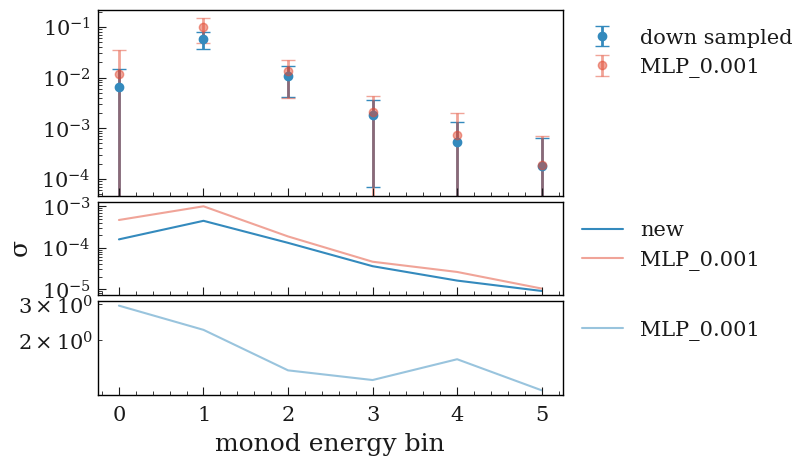

In [185]:


var_factor = 50

# he = convert_hist_to_uarray(h)
hkw = dict()

x = range(len(down_sampled_hist))

fig, axs = utils.plt_subplots(nrows=3,  height_ratios=[2, 1, 1],)




hekw = dict(fmt='o',  elinewidth=2, capsize=5)
## values and errors
ax0 = axs[0]
ax0.errorbar(x, [v.n for v in down_sampled_hist], 
            yerr=[v.s*var_factor for v in down_sampled_hist], 
            label='down sampled',
            **hekw)

ax0.errorbar(x=x, y=df_hists_pred[pname].apply(lambda x: x.nominal_value), 
             yerr=df_hists_pred[pname].apply(lambda x: var_factor*x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hekw
             )

fix_ax(ax0)

ax1 = axs[1]
ax1.plot([v.s for v in down_sampled_hist], 
        label='new',
        **hkw)


ax1.plot(df_hists_pred[pname].apply(lambda x: x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )
# axs_t.yscale('log')
fix_ax(ax=ax1, yscale='log', ylabel='$\sigma$')

ax2 = axs[2]
ax2.plot(df_hists_pred[pname].apply(lambda x: x.std_dev)/np.array([k.std_dev for k in down_sampled_hist]), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )

fix_ax(ax=ax2, yscale='log')



[1.08629631 1.10615771 1.09077757 1.08040237 1.10133277 1.05854821]
[2.30272751 1.81646394 1.32134608 1.22151924 1.46292598 1.27278811]


In [65]:
# [ f"{v:0.2ue}" for v in vals]
# df_hists_pred.style.format("{:.2ue}")

from uncertainties import ufloat

pname = 'pseudo_pred_uniform'

variance_loss = 1.0/np.sqrt(df_variances_increase[pname])
print(f"{variance_loss = }")

down_sampled_hist = []
for ibin, sample_fraction in enumerate(variance_loss):
    sample_fraction = 1.0 
    df = df_corsika.sample(frac=sample_fraction)
    # df = df_corsika.sample(frac=1.0)

    # df = df.query(f'{var} > {bins[ibin]} & {var} <= {bins[ibin+1]}')
    pred = np.ones(len(df))
    # h = get_pred_hist(df, var, bins, pred_name=pred, pred_weights=pred*sample_fraction, min_pred=None)

##
    pred_weights_, pred_mask = speedup_utils.get_weight_from_pred(pred)
    #pred_weights = pred*sample_fraction
    pred_weights = pred_weights_
    weights = utils.combine_weight_columns(df,['weights'])
    truth_mask = df['truth'] == 1
    mask = pred_mask & truth_mask
    h = utils.make_hist(df[mask][var], 
                        weights=weights[mask] * pred_weights[mask], 
                        bins=bins) 
##

    ve = ufloat(h.values()[ibin], h.variances()[ibin])
    down_sampled_hist.append(ve)
    print(f'{ve = :0.2ue}  actual = {hists_pred[pname].values()[ibin]:0.2e},{np.sqrt(hists_pred[pname].variances()[ibin]):0.2e} ')
    print(f'std ratio: {ve.std_dev/np.sqrt(hists_pred[pname].variances()[ibin]):0.2e}')





variance_loss = 0    0.440451
1    0.434836
2    0.408559
3    0.438882
4    0.345066
5    0.767537
Name: pseudo_pred_uniform, dtype: float64


/tmp/ipykernel_1709870/3916994930.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h = utils.make_hist(df_corsika[mask][var],
/tmp/ipykernel_1709870/3916994930.py:26: RangeWarning: Only 97.73% of data contained in the binning range [60.0, 2000000.0].
  h = utils.make_hist(df_corsika[mask][var],


ve = (5.793864+/-0.000019)e-03  actual = 1.13e-02,4.36e-04 
std ratio: 4.36e-05


/tmp/ipykernel_1709870/3916994930.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h = utils.make_hist(df_corsika[mask][var],
/tmp/ipykernel_1709870/3916994930.py:26: RangeWarning: Only 97.68% of data contained in the binning range [60.0, 2000000.0].
  h = utils.make_hist(df_corsika[mask][var],


ve = (5.967186+/-0.000019)e-02  actual = 9.82e-02,1.34e-03 
std ratio: 1.43e-04


/tmp/ipykernel_1709870/3916994930.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  h = utils.make_hist(df_corsika[mask][var],
/tmp/ipykernel_1709870/3916994930.py:26: RangeWarning: Only 97.79% of data contained in the binning range [60.0, 2000000.0].
  h = utils.make_hist(df_corsika[mask][var],


ve = (2.8994333+/-0.0000092)e-02  actual = 1.36e-02,3.66e-04 
std ratio: 2.51e-04


KeyboardInterrupt: 

In [70]:
len(df_corsika), len(df), len(df.sample(frac=0.3))

(2688848, 2688848, 806654)

In [365]:
print( unumpy.std_devs(convert_hist_to_uarray(hists_pred[pname]))/ unumpy.std_devs(down_sampled_hist) )


[1.16537767e+05 3.74627150e+04 1.20233815e+05 8.62589263e+05
 3.99988329e+07 1.52130665e+06]


{'nrows': 3, 'height_ratios': [2, 1, 1], 'figsize': (6, 5), 'sharex': True, 'gridspec_kw': {'hspace': 0.05}, 'ncols': 1}


<Axes: xlabel='monod energy bin'>

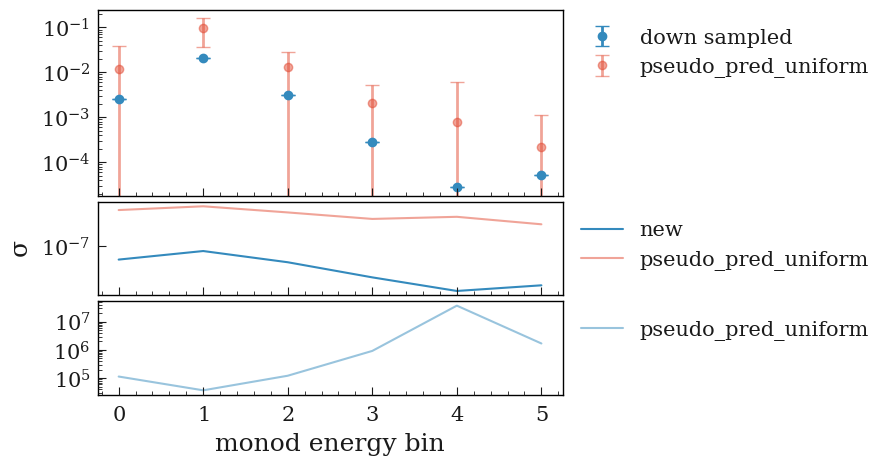

In [353]:


var_factor = 50

# he = convert_hist_to_uarray(h)
hkw = dict()

x = range(len(down_sampled_hist))

fig, axs = utils.plt_subplots(nrows=3,  height_ratios=[2, 1, 1],)




hekw = dict(fmt='o',  elinewidth=2, capsize=5)
## values and errors
ax0 = axs[0]
ax0.errorbar(x, [v.n for v in down_sampled_hist], 
            yerr=[v.s*var_factor for v in down_sampled_hist], 
            label='down sampled',
            **hekw)

ax0.errorbar(x=x, y=df_hists_pred[pname].apply(lambda x: x.nominal_value), 
             yerr=df_hists_pred[pname].apply(lambda x: var_factor*x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hekw
             )

fix_ax(ax0)

ax1 = axs[1]
ax1.plot([v.s for v in down_sampled_hist], 
        label='new',
        **hkw)


ax1.plot(df_hists_pred[pname].apply(lambda x: x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )
# axs_t.yscale('log')
fix_ax(ax=ax1, yscale='log', ylabel='$\sigma$')

ax2 = axs[2]
ax2.plot(df_hists_pred[pname].apply(lambda x: x.std_dev)/np.array([k.std_dev for k in down_sampled_hist]), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )

fix_ax(ax=ax2, yscale='log')


In [ ]:


var_factor = 50

# he = convert_hist_to_uarray(h)
hkw = dict()

x = range(len(down_sampled_hist))

fig, axs = utils.plt_subplots()

ax_t = axs[0]
ax_t.plot([v.s for v in down_sampled_hist], 
        label='new',
        **hkw)


ax_t.plot(df_hists_pred[pname].apply(lambda x: x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )
# axs_t.yscale('log')
fix_ax(ax=ax_t, yscale='log')
ax_t.legend()

ax_r = axs[1]
ax_r.plot(df_hists_pred[pname].apply(lambda x: x.std_dev)/np.array([k.std_dev for k in down_sampled_hist]), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )
fix_ax(ax=ax_r, yscale='log')


{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}


<Axes: xlabel='monod energy bin'>

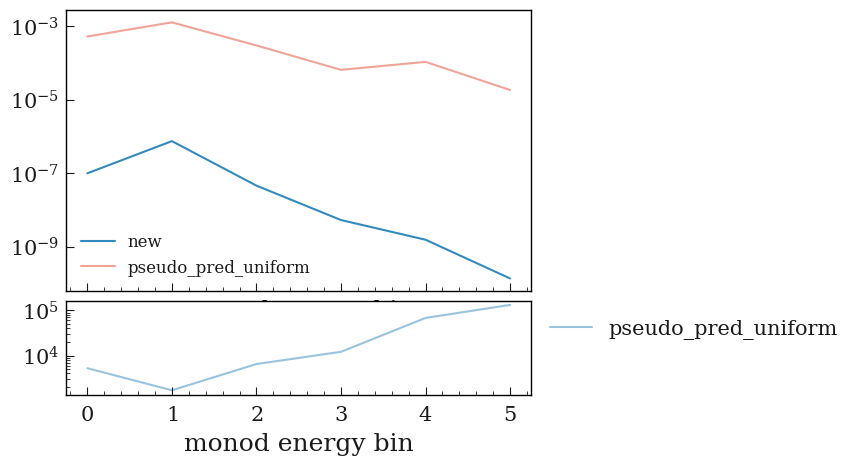

In [ ]:


var_factor = 50

# he = convert_hist_to_uarray(h)
hkw = dict()

x = range(len(down_sampled_hist))

plt.plot([v.s for v in down_sampled_hist], 
        label='new',
        **hkw)

plt.plot(df_hists_pred[pname].apply(lambda x: x.std_dev), 
             #fmt='o', capsize=5, 
             alpha=0.5, 
             label=pname,
             **hkw
             )
plt.yscale('log')


# hekw = dict(fmt='o',  elinewidth=2, capsize=5)

# plt.errorbar(x, [v.n for v in down_sampled_hist], 
#             yerr=[v.s*var_factor for v in down_sampled_hist], 
#             label='new',
#             **hekw)
# plt.errorbar(x=x, y=df_hists_pred[pname].apply(lambda x: x.nominal_value), 
#              yerr=df_hists_pred[pname].apply(lambda x: var_factor*x.std_dev), 
#              #fmt='o', capsize=5, 
#              alpha=0.5, 
#              label=pname,
#              **hekw
#              )

plt.legend()


<Axes: xlabel='monod energy bin', ylabel='$\\frac{\\sigma^2}{CPU\\ hour}$'>

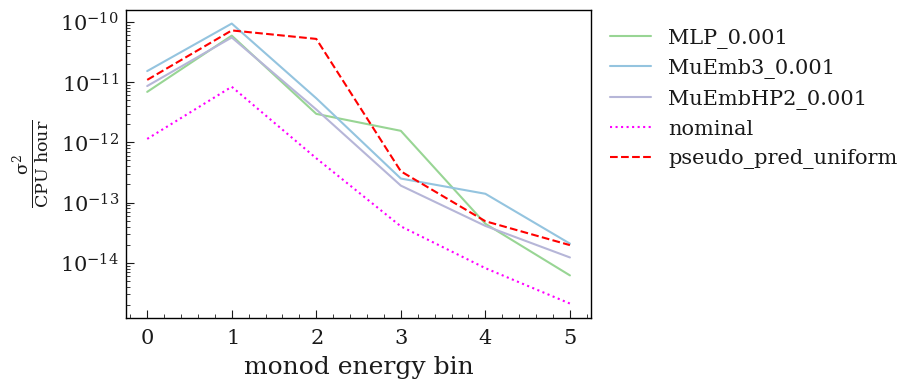

In [66]:
ax = (df_variances/df_cpu_hour).plot(**plt_kwargs)
fix_ax(ax, ylabel=r"$\frac{\sigma^2}{CPU\ hour}$")



# Test Variances

In [183]:

import pickle
from uncertainties import unumpy
# pred_name = 'pseudo_pred_uniform'
pred_name = 'MLP_0.001'
pred = df_corsika[pred_name]

n_trials = 500

pkl_name = f"hists_{pred_name}_{n_trials}_trials.pkl"

if os.path.exists(pkl_name):
    print('loading pickle %s'%pkl_name)
    # variances = pickle.load(open(pkl_name, 'rb'))
    values = pickle.load(open(pkl_name, 'rb'))
    variances = unumpy.std_devs(values)**2
else:
    variances = []
    values = []
    pred_ = pred[truth_mask]
    df_ = df_corsika[truth_mask]
    for i in range(n_trials):
        if i%50==0:
            print(i)
        pred_weights, pred_mask = speedup_utils.get_weight_from_pred(pred_)
        weights = df_['weights'] # * pred_weights
        h = utils.make_hist(df_[pred_mask][var], 
                            weights=(weights[pred_mask] * pred_weights[pred_mask]).astype('float128'), 
                            bins=bins)
        
        variances.append( h.variances() )
        values.append( convert_hist_to_uarray(h) 
                      )
    # pickle.dump(variances, open(pkl_name, 'wb'))
    pickle.dump(values, open(pkl_name, 'wb'))
    
    print('pickle saved to %s'%pkl_name)



loading pickle hists_MLP_0.001_500_trials.pkl


array([[1.28527287e-07, 7.89957752e-07, 3.44093006e-08, 3.31233503e-09,
        4.94948275e-10, 1.10933140e-10],
       [1.99807110e-07, 7.47955540e-07, 3.75866326e-08, 2.42854650e-09,
        5.10415079e-10, 1.38813104e-10],
       [1.30020486e-07, 8.73094012e-07, 3.47715459e-08, 6.22361807e-09,
        5.18404245e-10, 1.71171759e-09],
       ...,
       [1.11139145e-07, 7.42895500e-07, 4.06972986e-08, 2.18127612e-09,
        4.87016674e-10, 1.34518166e-10],
       [1.38920256e-07, 8.39127242e-07, 3.25584301e-08, 2.36865899e-09,
        5.18355988e-10, 1.33826459e-10],
       [2.66738541e-07, 8.38025462e-07, 3.51060939e-08, 2.16701840e-09,
        6.06756248e-10, 1.22735625e-10]])

In [110]:
x = range(len(values[0]))

# for iv in range(len(values)):
#     plt.errorbar(x=x, y=unumpy.nominal_values(values[iv]), yerr=unumpy.std_devs(values[iv]), fmt='o', alpha=0.1)

values = np.array(values)

mean_bc = np.mean(unumpy.nominal_values(values), axis=0)
std_bc = np.sqrt(np.mean(unumpy.std_devs(values)**2, axis=0))
std_bc

bc = unumpy.nominal_values(values)
bv = unumpy.std_devs(values)**2


In [107]:
std_bc = np.mean(unumpy.std_devs(values), axis=0)
std_bc

array([3.83250137e-04, 9.13918597e-04, 2.08069865e-04, 6.12792856e-05,
       2.29381335e-05, 1.32517119e-05])

1.1931715178963995
1.0431732337212527
1.9184885260133848
1.8967423204105647
1.0542635558295232
1.4714211027290063


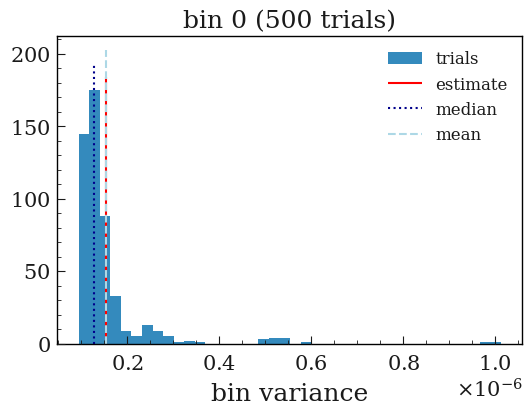

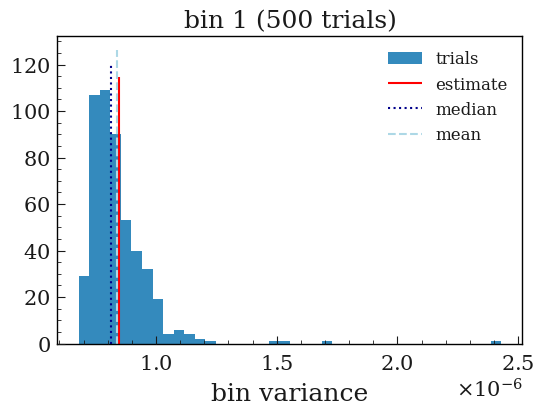

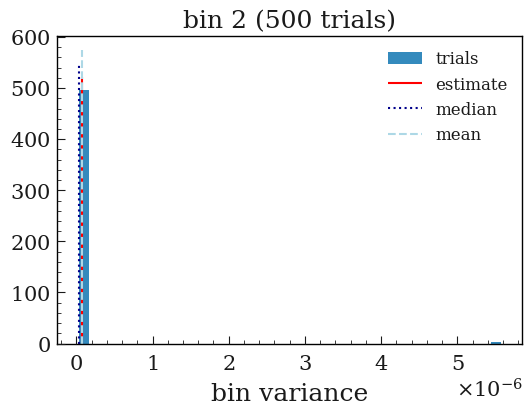

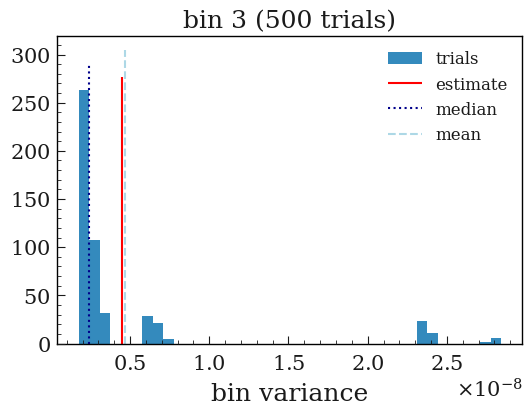

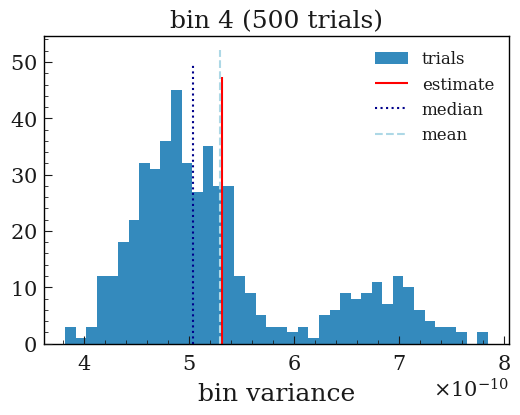

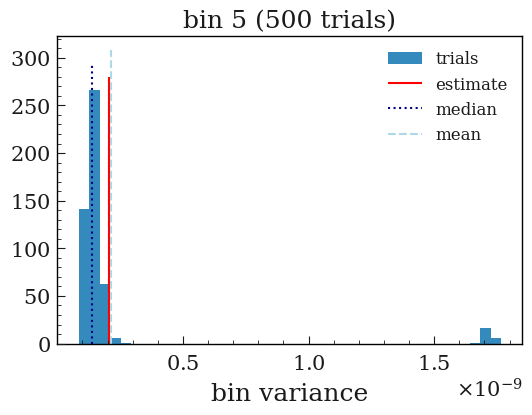

In [188]:


bc, bin_edges = np.histogram( df_corsika[var], bins=bins, weights=df_corsika['weights'] )
#bv, bin_edges = np.histogram( df_corsika[var], bins=bins, weights=df_corsika['weights']**2 * (1.0/df_corsika[pred_name]) ) 
bv, bin_edges = np.histogram( df_corsika[var], bins=bins, weights=df_corsika['weights']**2 * (1.0/df_corsika[pred_name]).astype('float128') )  

h = get_pred_hist(df_corsika, var, bins, pred_name, 'weights', )


# print(bv)

# population_variances = np.array(bv)
population_variances = np.array(h.variances())
# population_values = h.values()
# population_variances = errors**2

for iv, v in enumerate(np.array(variances).T):
    fig, ax = plt.subplots()
    # print(v)
    v = v
    ax.hist(v, bins=40, label='trials')
    ax.vlines(population_variances[iv], *ax.get_ylim(), color='red', label='estimate')
    ax.vlines(np.median(v), *ax.get_ylim(), color='darkblue', ls=':', label='median')
    ax.vlines(np.mean(v), *ax.get_ylim(), color='lightblue', ls='--', label='mean')
    ax.set_title(f'bin {iv} (500 trials)')
    ax.set_xlabel('bin variance')
    ax.legend()
    print( population_variances[iv] / np.median(v))
    
    

1.4276019152635899e-09
6.454984482089374e-10
2.9070788396065242e-08
1.2647089754906682e-09
6.978804401649111e-12
2.898471251263651e-11


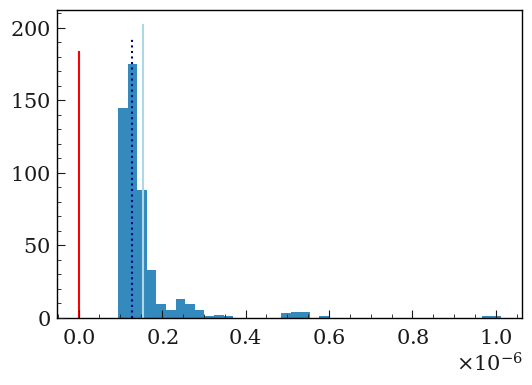

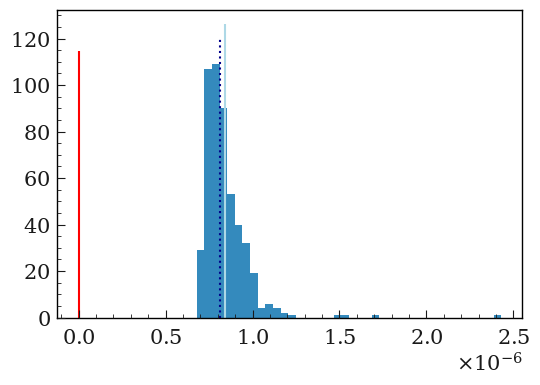

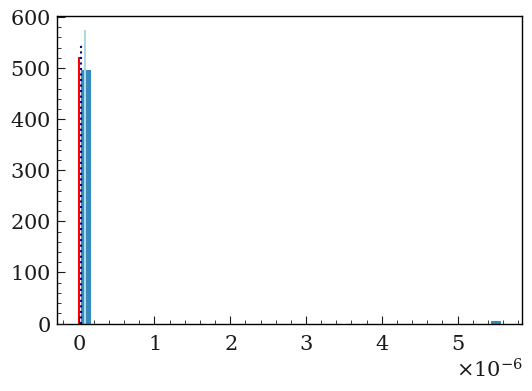

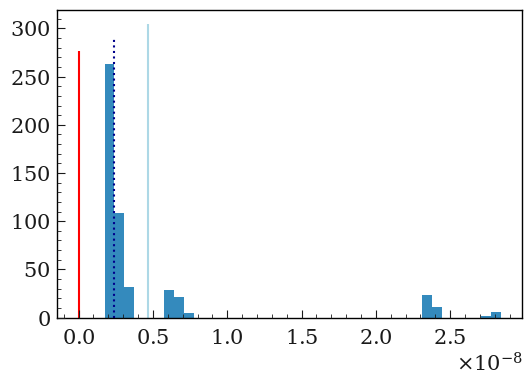

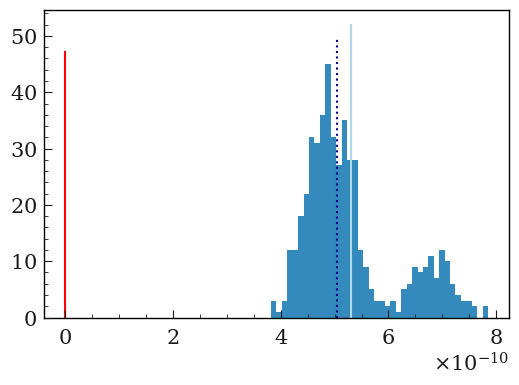

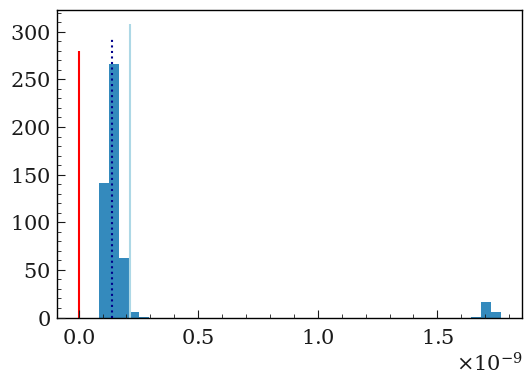

In [127]:
# pred_name = "nominal"
weights = df_corsika['weights'] # * pred_weights

wfrac = np.sum(df_corsika[pred_name]) / len(df_corsika)

# (w**2 * (1 - p)) / p
wfrac = np.sum(df_corsika[pred_name])/len(df_corsika)
# print(f"{wfrac = }")

h = utils.make_hist(df_corsika[var],
                    #weights = df_corsika['weights'] *  np.sqrt( df_corsika[pred_name]/(1-df_corsika[pred_name]) ),#,/ np.sqrt(wfrac),
                    # weights = df_corsika['weights']**2 *  1.0/(df_corsika[pred_name]),#,/ np.sqrt(wfrac),
                    weights = df_corsika['weights']**2 * (1.0/df_corsika[pred_name]),
                    bins=bins
                    )
population_variances = h.variances() 
population_values = h.values()
# population_variances = errors**2

for iv, v in enumerate(np.array(variances).T):
    fig, ax = plt.subplots()
    # print(v)
    v = v
    ax.hist(v, bins=40)
    ax.vlines(population_variances[iv], *ax.get_ylim(), color='red')
    ax.vlines(np.median(v), *ax.get_ylim(), color='darkblue', ls=':')
    ax.vlines(np.mean(v), *ax.get_ylim(), color='lightblue', ls='-')
    print( population_variances[iv] / np.median(v))
    # print( population_values[iv] / )

 

In [31]:
# Junk


In [140]:
    pred_weights, pred_mask = speedup_utils.get_weight_from_pred(pred)
    weights = df_corsika['weights'] # * pred_weights
    hrej = utils.make_hist(df_corsika[pred_mask & truth_mask][var], 
                        weights=weights[pred_mask & truth_mask] * pred_weights[pred_mask & truth_mask], 
                        bins=bins)


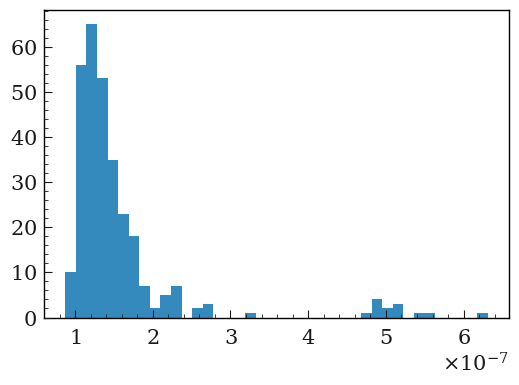

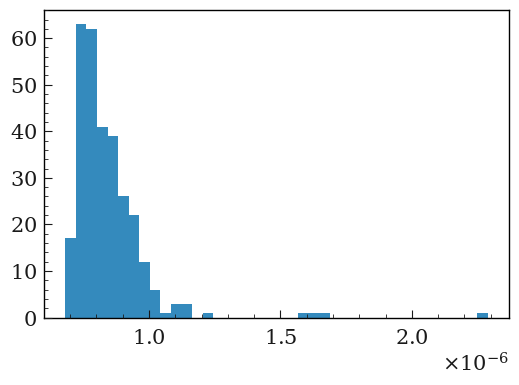

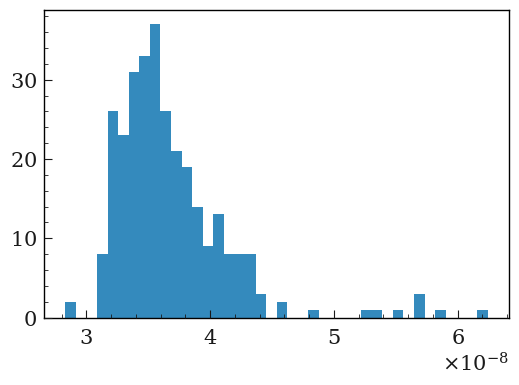

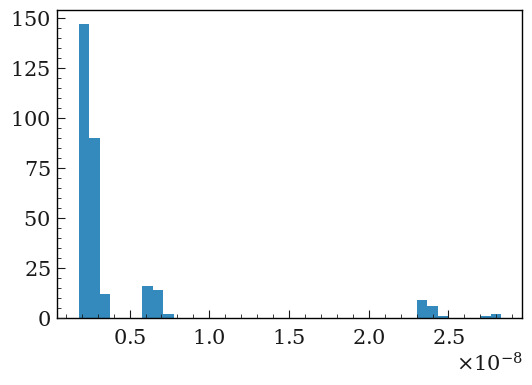

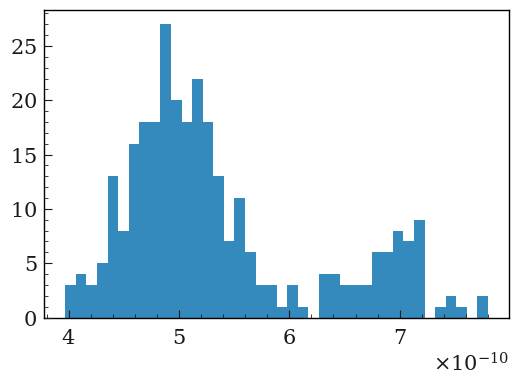

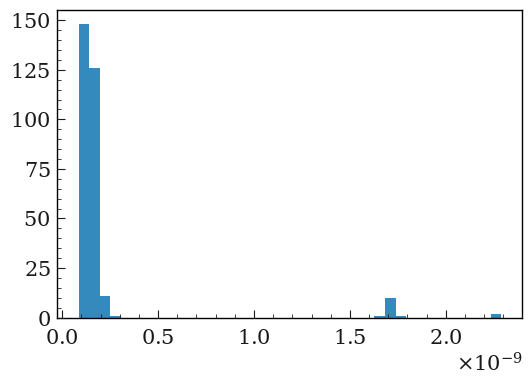

In [195]:
for v in np.array(variances).T:
    fig, ax = plt.subplots()
    # print(v)
    ax.hist(v, bins=40)


In [124]:
df_corsika['sel_flux_weights']-df_corsika['weights']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2688843    0.0
2688844    0.0
2688845    0.0
2688846    0.0
2688847    0.0
Length: 2688848, dtype: float64

In [191]:
np.min( df_corsika[pred_name] )


#df_corsika['MLP']
speedup_utils.get_weight_from_pred(df_corsika['MLP'])

(0          17.556991
 1           2.918383
 2           1.413983
 3           4.202518
 4           1.190102
              ...    
 2688843     1.666100
 2688844     3.632746
 2688845     1.510142
 2688846     2.105776
 2688847     1.829137
 Name: MLP, Length: 2688848, dtype: float64,
 0          False
 1          False
 2           True
 3           True
 4           True
            ...  
 2688843     True
 2688844    False
 2688845     True
 2688846     True
 2688847     True
 Name: MLP, Length: 2688848, dtype: bool)

0.41997894499223365


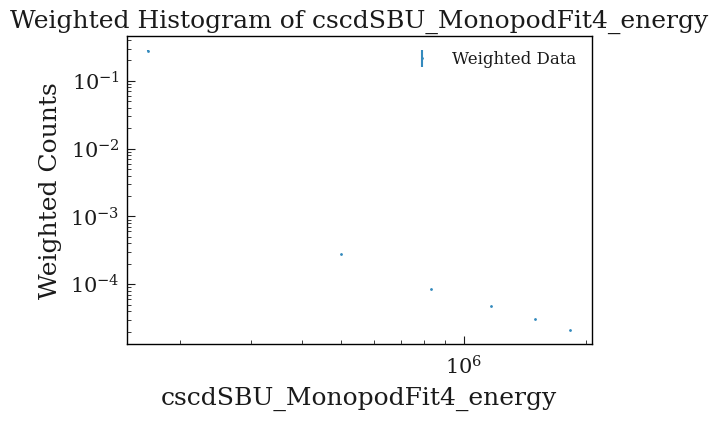

[0.00378221 0.         0.         0.         0.         0.        ]


In [219]:
import numpy as np
import matplotlib.pyplot as plt

def weighted_histogram(df, variable, bins=20, pred="pred", weights="weights", hist_range=None):
    """
    Creates a weighted histogram using the full dataset, 
    applying the correction weight of weights / pred.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the data.
        variable (str): Name of the column to histogram.
        bins (int or array-like): Number of bins or bin edges.
        hist_range (tuple, optional): The lower and upper range of the bins.
    
    Returns:
        bin_centers (np.array): The centers of the bins.
        counts (np.array): The weighted bin counts.
        errors (np.array): The bin errors computed as sqrt(sum(w^2)).
    """
    # Calculate the effective weight for each event
    effective_weights = df[weights] / df[pred]

    # Compute the weighted histogram counts
    counts, bin_edges = np.histogram(
        df[variable],
        bins=bins,
        range=hist_range,
        weights=effective_weights
    )
    
    # Compute the squared weights to estimate the variance per bin
    squared_weights = effective_weights**2
    counts_squared, _ = np.histogram(
        df[variable],
        bins=bin_edges,
        weights=squared_weights
    )
    # print(effective_weights)
    # The error on each bin is the square root of the summed squared weights
    errors = np.sqrt(counts_squared)
    
    # Calculate bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Plot the histogram with error bars
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label="Weighted Data", ms=1)
    plt.xlabel(variable)
    plt.ylabel("Weighted Counts")
    plt.title(f"Weighted Histogram of {variable}")
    plt.legend()
    plt.yscale('log')
    print(max(counts) * 1.5)
    plt.xscale('log')
    #plt.ylim(1E-10, 0.1)
    plt.show()
    # print(effective_weights)
    # print(squared_weights)
    print(errors)
    
    return bin_centers, counts, errors

# Example usage:
# Assuming your DataFrame is named `df` and you want to histogram the column 'my_variable':
# bin_centers, counts, errors = weighted_histogram(df, variable="my_variable", bins=30, hist_range=(min_val, max_val))
pred_name = 'MLP_0.001'
centers, counts, errors = weighted_histogram(df_corsika, variable=var, pred=pred_name, bins=len(bins)-1, hist_range=(60, 2E6))



In [214]:
errors

array([0.00378221, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [213]:
h.values()/counts

array([4.16704560e-02, 3.51843167e+02, 1.57682627e+02, 4.73678513e+01,
       2.29630301e+01, 1.20202015e+01])

In [211]:
var_info

{'var': 'cscdSBU_MonopodFit4_energy',
 'bins': array([6.00000000e+01, 3.40380267e+02, 1.93097877e+03, 1.09544512e+04,
        6.21446501e+04, 3.52546877e+05, 2.00000000e+06]),
 'label': 'MonopodFit4 Energy [GeV]',
 'xscale': 'log'}

In [235]:
np.sum(df_corsika[pred_name])/len(df_corsika)
frac

NameError: name 'frac' is not defined

[6.00000000e+01 3.40380267e+02 1.93097877e+03 1.09544512e+04
 6.21446501e+04 3.52546877e+05 2.00000000e+06]


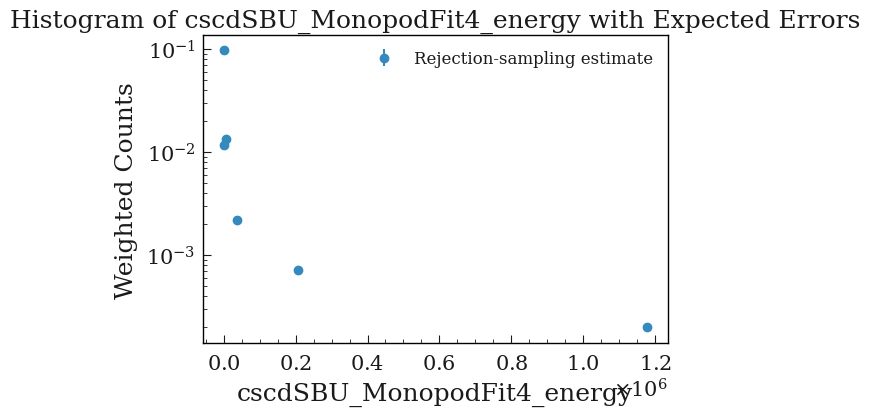

counts = ['1.18e-02', '9.91e-02', '1.34e-02', '2.19e-03', '7.16e-04', '1.99e-04']
counts = ['2.38e-04', '5.62e-04', '1.34e-04', '4.04e-05', '1.21e-05', '9.34e-06']


In [294]:
def make_hist_with_expected_errors(df, var, bins=20, hist_range=None):
    """
    Computes a histogram and its expected errors accounting for rejection sampling.
    
    Parameters:
        df (pandas.DataFrame): DataFrame with the data.
        var (str): Column name for the variable to histogram.
        bins (int or array-like): Number of bins or bin edges.
        hist_range (tuple, optional): Range for the histogram (min, max).
    
    Returns:
        bin_centers (np.array): Centers of the histogram bins.
        counts (np.array): Weighted bin counts.
        errors (np.array): Expected uncertainties for each bin.
    """
    # Extract the columns: 'weights' is the additional weight and 'pred' is the acceptance probability.
    w = df["weights"].values       # base weights (w_i)
    p = df[pred_name].values          # acceptance probabilities (p_i)
    x = df[var].values             # variable to histogram

    # Effective weight that the event would contribute if accepted.
    effective_weight = w 

    assert np.any(np.isnan(effective_weight))==False
    # Expected variance contribution from each event:
    # variance_i = w_i^2 * (1-p_i) / p_i.
    variance_contrib = (w**2 * (1 - p)) / p

    assert np.any(np.isnan(variance_contrib))==False

    # Build the histogram of weighted counts.
    counts, bin_edges = np.histogram(x, bins=bins, range=hist_range, weights=effective_weight)
    # Build the histogram of variance contributions.
    variance_hist, _ = np.histogram(x, bins=bin_edges, weights=variance_contrib)

    # The error on each bin is the square root of the summed variances.
    errors = np.sqrt(variance_hist)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    print(bin_edges)

    # Plot the histogram with error bars.
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label="Rejection-sampling estimate")
    plt.xlabel(var)
    plt.ylabel("Weighted Counts")
    plt.title(f"Histogram of {var} with Expected Errors")
    plt.legend()
    plt.yscale('log')
    plt.show()

    # print(f"{counts = :0.2e}")
    #print("{counts:0.2e}")
    #print(f"{errors = }")
    print(f"counts = {[f'{c:0.2e}' for c in counts]}")
    print(f"counts = {[f'{c:0.2e}' for c in errors]}")
    # print(errors)
    return bin_centers, counts, errors


bin_centers, counts, errors = make_hist_with_expected_errors(df_corsika, var=var, bins=bins, hist_range=None)

In [309]:
h.values()
h.values()/hrej.values()






array([0.95317245, 0.8312546 , 0.70206987, 0.50240355, 0.72370153,
       0.8227453 ])

In [340]:
model_names
pred_name

'MuEmbHP2_0.001'

IndentationError: unexpected indent (2865460864.py, line 5)

In [36]:
##


df_var_normed = df_variancees.apply(lambda col: col/df_variancees['nominal'])
ax = df_var_normed.plot(**plt_kwargs)
fix_ax(ax, yscale='linear')

NameError: name 'df_variancees' is not defined

MLP_0.001              0.373865
MuEmb3_0.001           0.234709
MuEmbHP2_0.001         0.293602
nominal                1.000000
pseudo_pred_uniform    0.499442
dtype: float64

MLP_0.001              0.373865
MuEmb3_0.001           0.234709
MuEmbHP2_0.001         0.293602
nominal                1.000000
pseudo_pred_uniform    0.499442
dtype: float64


<Axes: xlabel='monod energy bin', ylabel='FOM'>

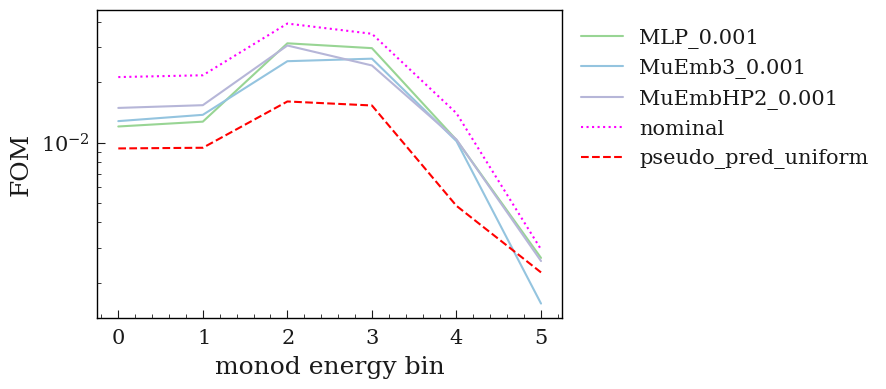

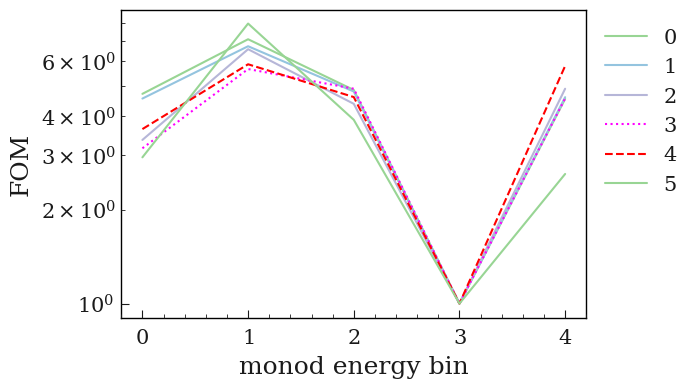

In [39]:


nom = reverse_cumsum(df_hists['astro']).apply(lambda x: x.nominal_value )
df_foms = reverse_cumsum(df_hists_pred).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )

ax = df_foms.plot(**plt_kwargs)
fix_ax(ax, ylabel="FOM")

df_foms_rel = df_foms.apply(lambda x: x['nominal']/x, axis=1)

df_n_sim_gamma_wrt_nominal = df_n_sim_gamma/df_n_sim_gamma['nominal']
print(df_n_sim_gamma_wrt_nominal)
df_foms_gain = df_foms_rel.div(df_n_sim_gamma_wrt_nominal.T).T
ax = df_foms_gain.plot(**plt_kwargs)
fix_ax(ax, ylabel="FOM")
# df_foms_rel

In [17]:
di = {hname: convert_hist_to_uarray(h) for hname, h in hists_pred_nom.items()}
df_hists_pred_nom = pd.DataFrame(di)
df_hists_pred_nom.head().style.format("{:.2e}")


In [18]:

df_hists_pred

MLP_0.001         MuEmb3_0.001       MuEmbHP2_0.001  \
0      0.0728+/-0.0010      0.0703+/-0.0008      0.0703+/-0.0007   
1      0.0529+/-0.0005      0.0541+/-0.0006      0.0537+/-0.0005   
2    0.00264+/-0.00005    0.00273+/-0.00010    0.00267+/-0.00006   
3  0.000462+/-0.000019  0.000442+/-0.000033  0.000450+/-0.000018   

               nominal  pseudo_pred_uniform  
0      0.0707+/-0.0005      0.0700+/-0.0011  
1      0.0536+/-0.0004      0.0541+/-0.0009  
2    0.00267+/-0.00004    0.00268+/-0.00008  
3  0.000439+/-0.000014  0.000408+/-0.000019

In [19]:
df_hists_pred_nom

MLP_0.001         MuEmb3_0.001       MuEmbHP2_0.001  \
0      0.0708+/-0.0009      0.0696+/-0.0011      0.0695+/-0.0009   
1      0.0544+/-0.0006      0.0543+/-0.0008      0.0532+/-0.0007   
2    0.00264+/-0.00007    0.00261+/-0.00010    0.00269+/-0.00007   
3  0.000445+/-0.000022  0.000468+/-0.000029  0.000447+/-0.000026   

               nominal  pseudo_pred_uniform  
0      0.0707+/-0.0005      0.0711+/-0.0007  
1      0.0536+/-0.0004      0.0530+/-0.0005  
2    0.00267+/-0.00004    0.00258+/-0.00006  
3  0.000439+/-0.000014  0.000438+/-0.000020

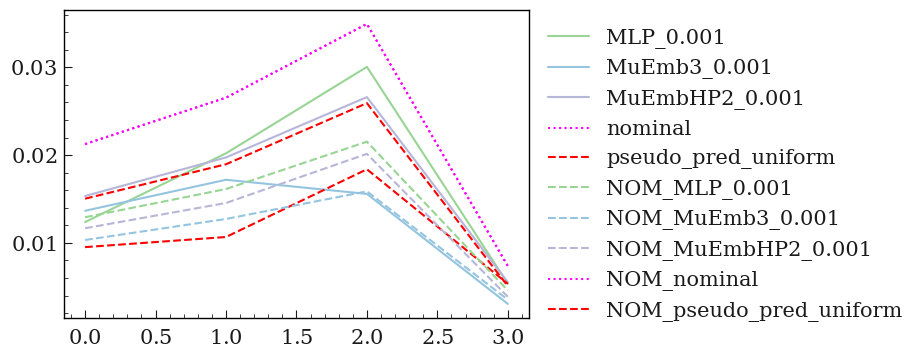

In [25]:


nom = reverse_cumsum(df_hists['astro']).apply(lambda x: x.nominal_value )
df_foms = reverse_cumsum(df_hists_pred).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )
# plt.plot(df_foms)

df_foms_nom = reverse_cumsum(df_hists_pred_nom).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )

df_foms_nom.rename(columns=renamefunc, inplace=True)

ax = df_foms.plot(**plt_kwargs)
df_foms_nom.plot(ax=ax, **plt_kwargs2)
ax.legend(**legend_kwargs)



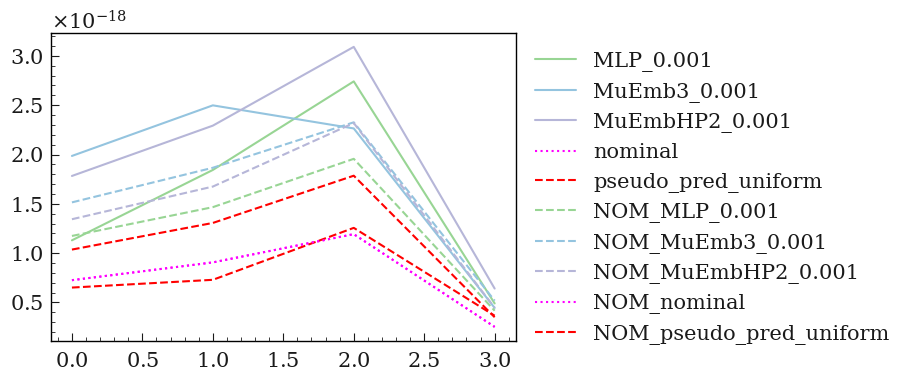

In [26]:

df_n_sim_gamma = pd.Series(n_simulated_photons)
df_foms_per_sim_gamma = df_foms/df_n_sim_gamma


df_n_sim_gamma_nom = pd.Series(n_simulated_photons_nom)
df_n_sim_gamma_nom.rename(lambda x: 'NOM_'+x, inplace=True)
df_foms_per_sim_gamma_nom = df_foms_nom/df_n_sim_gamma_nom


ax = df_foms_per_sim_gamma.plot(**plt_kwargs)
ax = df_foms_per_sim_gamma_nom.plot(ax=ax, **plt_kwargs2)
ax.legend(**legend_kwargs)


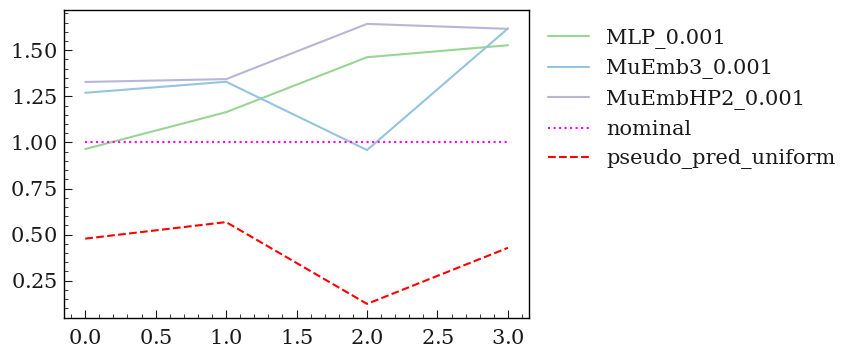

In [145]:
df_foms_per_sim_gamma_nom.rename(columns=lambda x: x.replace('NOM_', ''), inplace=True)
ax = (df_foms_per_sim_gamma/df_foms_per_sim_gamma_nom).plot(**plt_kwargs)
ax.legend(**legend_kwargs)

In [85]:
hists

#pd.DataFrame()

from uncertainties import unumpy




di = {hname: convert_hist_to_uarray(h) for hname, h in hists.items()}
#pd.DataFrame( )

df_hists = pd.DataFrame(di)
df_hists.head().style.format("{:.3e}")


In [60]:

di = {hname: convert_hist_to_uarray(h) for hname, h in hists_pred.items()}
df_hists_pred = pd.DataFrame(di)
df_hists_pred.head().style.format("{:.2e}")


#foms = df_hists_pred.div




In [61]:
def fom_func_naive_sig(s_uarray, b_uarray):
    return np.sum(s_uarray)/np.sum(b_uarray).std_dev


def calc_fom(h_sig, h_bkg, per_bin=False, fom_func=fom_func_naive_sig):
    
    sig_values = h_sig.values()
    bkg_uncerts = np.sqrt(h_bkg.variances())
    bkg_values = h_bkg.values()
    if per_bin:
        fom_values = sig_values/bkg_uncerts
        fom_values = fom_func(sig_values, bkg_values)
    else:
        from uncertainties import unumpy
        bkg = unumpy.uarray(bkg_values, bkg_uncerts )
        bkg = np.where(bkg==0, np.nan, bkg)

        fom_values = []
        for ibin in range(len(bkg)):
            # fom = np.sum(sig_values[ibin:])/np.sum(bkg[ibin:]).std_dev
            # print(sig_values[ibin:ibin], bkg[:ibin])
            fom = fom_func(sig_values[ibin:], bkg[ibin:])
            fom_values.append(fom)
            #fom_values
        
    return fom_values

calc_fom(hists['astro'], hists_pred['nominal'], per_bin=False)

[0.021258025082619574,
 0.02654339531135028,
 0.034948547208979795,
 0.007367505624811244]

In [23]:


reverse_cumsum(df_hists)




plt_kwargs = dict(color=[colors[h] for h in df_hists_pred.columns], 
             style=[line_styles.get(h, '') for h in df_hists_pred.columns])

legend_kwargs = dict(ncol=1, 
                     fontsize=15, 
                     loc='upper left', 
                     #bbox_to_anchor=(0.5, 1.15),
                     bbox_to_anchor=(1, 1),
                     )



In [63]:

cscd_utils.calc_fom(hists['astro'], hists_pred['nominal'], per_bin=False)


df_n_sim_gamma = pd.DataFrame(n_simulated_photons, index=[0])
# df_n_sim_gamma


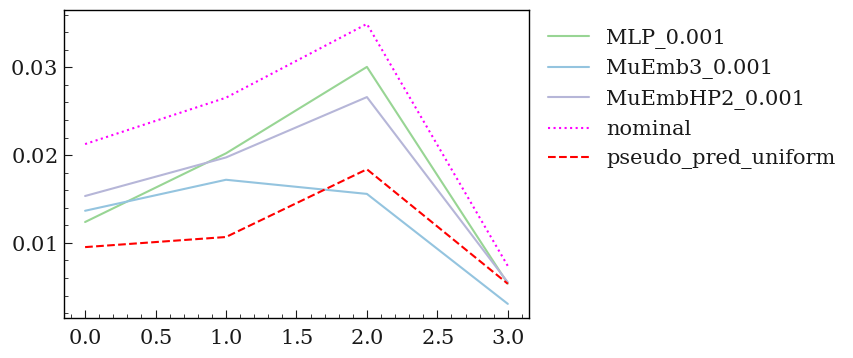

In [24]:
#df_hists_pred.apply(lambda x: x.apply(lambda y: y.std_dev)) 
#/ 

#df_hists['astro'].apply(lambda x: x.nominal_value ) / df_hists_pred.map(lambda y: y.std_dev) 

nom = reverse_cumsum(df_hists['astro']).apply(lambda x: x.nominal_value )
df_foms = reverse_cumsum(df_hists_pred).apply(lambda x: nom/x.apply(lambda y: y.std_dev)  )
# plt.plot(df_foms)

ax = df_foms.plot(**plt_kwargs)
ax.legend(**legend_kwargs)



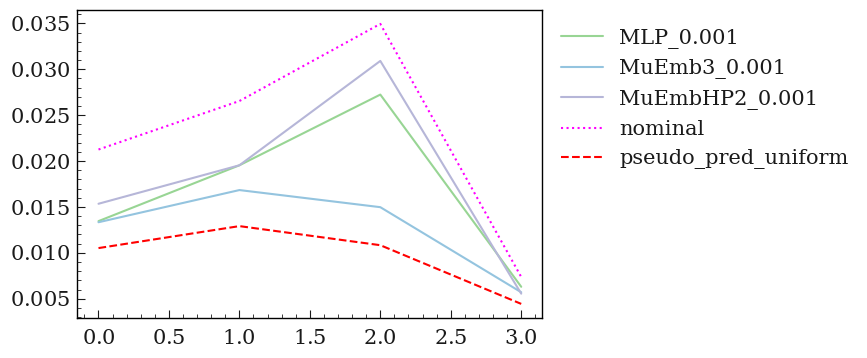

In [65]:


ax = df_foms.plot(**plt_kwargs)
ax.legend(**legend_kwargs)

#ax.set_xmargin(0.1)
#ax.

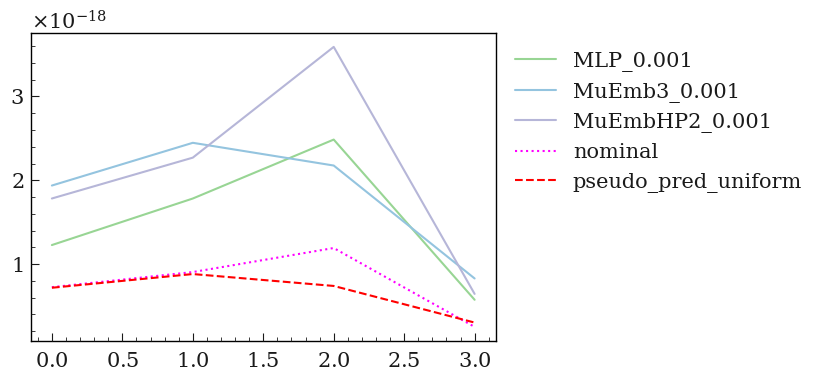

In [66]:
df_foms_per_sim_gamma = df_foms/df_n_sim_gamma.iloc[0]

ax = df_foms_per_sim_gamma.plot(**plt_kwargs)
ax.legend(**legend_kwargs)


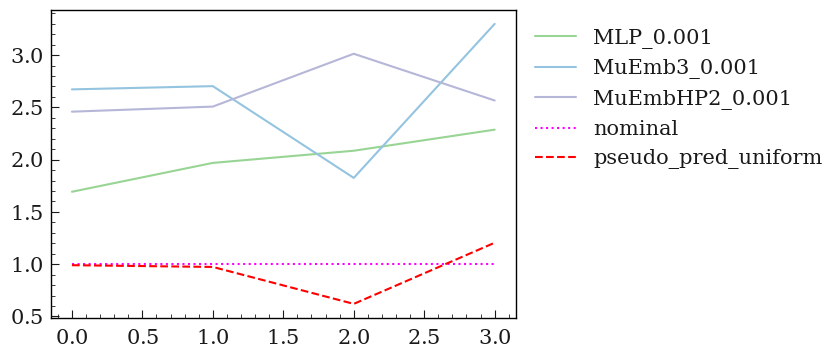

In [67]:
df_foms_per_sim_gamma_normed = (df_foms_per_sim_gamma.T / df_foms_per_sim_gamma['nominal']).T
ax = df_foms_per_sim_gamma_normed.plot(**plt_kwargs)
ax.legend(**legend_kwargs)


nominal_variance = 68423.43286933853


1.0

In [68]:
df_foms
n_gamma_factor = df_n_sim_gamma/df_n_sim_gamma['nominal'].iloc[0]

n_gamma_factor.iloc[0].to_dict()

{'MLP_0.001': 0.373865310156505,
 'MuEmb3_0.001': 0.23470946430580666,
 'MuEmbHP2_0.001': 0.2936017240704042,
 'nominal': 1.0,
 'pseudo_pred_uniform': 0.49944155493733217}

# Absolute Junk

In [221]:
df_ = df_corsika

w = df_['weights']

nominal_variance = np.sum(w**2)
print(f'{nominal_variance = }')

nominal_variance = 30262.850325504915


In [226]:
# np.sum(w**2 * (1-p) / p)
w = df_corsika.sample(frac=0.5)['weights']
np.sum( (w*1.0/np.sqrt(0.5) )**2 ) / nominal_variance
## reduce the sample by half... variance is also halved. checked!
## to keep the same variance, the weights should be multiplied by 1/sqrt(frac)
## too keep the same event rate the weights should be multiplied by 1/frac

np.sum( (w*1.0/np.sqrt(0.5) )**2 ) / nominal_variance


1.0020324989307525

In [204]:
w = df_['weights']

np.sum(w)**2/np.sum(w**2), np.sum(w[:100])**2/np.sum(w[:100]**2)

(14441.081213319554, 4.107582779257097)

In [211]:
speedup_utils.calc_livetime(w)

0.459406806662345

In [187]:
df = df_corsika

In [192]:
from utils import speedup_utils

df_ = df.sample(frac=1)
n_eff_orig = speedup_utils.calc_n_eff(df_['weights'])
print(n_eff_orig)

In [202]:
frac = 0.25
df_ = df.sample(frac=frac)
n_eff_2 = speedup_utils.calc_n_eff(df_['weights'])
print(n_eff_2/n_eff_orig)

# if I reduce the sample by factor of n

0.24900979488197267


ValueError: ['black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black'] is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

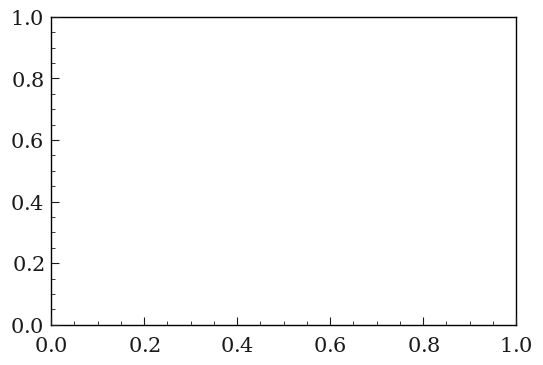

In [198]:

c = {'pseudo_pred_uniform': (0.0, 0.39277201076509033, 0.15816993464052287, 1.0), 'nominal': (0.0, 0.39277201076509033, 0.15816993464052287, 1.0), 'MLP_0.1': (0.596078431372549, 0.8345098039215686, 0.5788235294117646, 1.0), 'MLP_0.2': (0.0, 0.39277201076509033, 0.15816993464052287, 1.0), 'MuEmb2_0.1': (0.5796078431372549, 0.7701960784313725, 0.8737254901960784, 1.0), 'MuEmb2_0.2': (0.03137254901960784, 0.2897347174163783, 0.570319108035371, 1.0), 'MuEmb3_0.1': (0.7137254901960784, 0.7137254901960784, 0.8470588235294118, 1.0), 'MuEmb3_0.2': (0.3116493656286044, 0.11995386389850059, 0.5455594002306805, 1.0), 'MuEmbHP_0.1': (0.9921568627450981, 0.6564705882352941, 0.3827450980392157, 1.0), 'MuEmbHP_0.2': (0.6179930795847751, 0.19907727797001154, 0.012610534409842366, 1.0), 'MuEmbHP2_0.1': (0.7105882352941176, 0.7105882352941176, 0.7105882352941176, 1.0), 'MuEmbHP2_0.2': (0.11380238369857748, 0.11380238369857748, 0.11380238369857748, 1.0)}

c = {k: tuple(list(v)[:3]) for k,v in c.items()}

c = [c.get(None, 'black') for col in foms_per_sim_gamma.columns]

fig, ax = plt.subplots()
ax.plot(foms_per_sim_gamma, c=c)



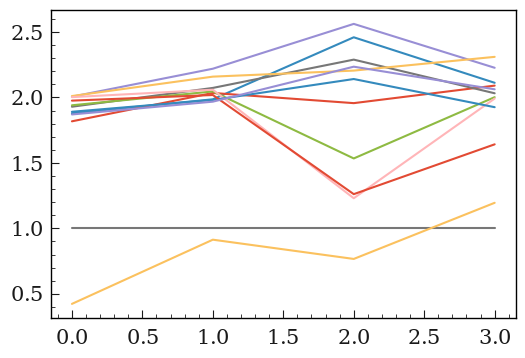

In [177]:
foms_per_sim_gamma_normed = foms_per_sim_gamma / foms_per_sim_gamma['nominal']

#plt.plot( foms_per_sim_gamma_normed )

foms_per_sim_gamma_normed
plt.plot( (foms_per_sim_gamma.T / foms_per_sim_gamma['nominal']).T )


In [15]:

fom_per_cpu = {k:v/(n_simulated_photons[k]*5E-9) for k,v in foms2.items()}

{k:v/fom_per_cpu['nominal'] for k,v in fom_per_cpu.items()}

NameError: name 'foms2' is not defined

{'figsize': (10, 8), 'nrows': 4, 'height_ratios': [3, 1, 1, 1], 'sharex': True, 'gridspec_kw': {'hspace': 0.05}, 'ncols': 1}


/tmp/ipykernel_299838/2896407670.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=3)
/tmp/ipykernel_299838/2896407670.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


(0.5, 3.5)

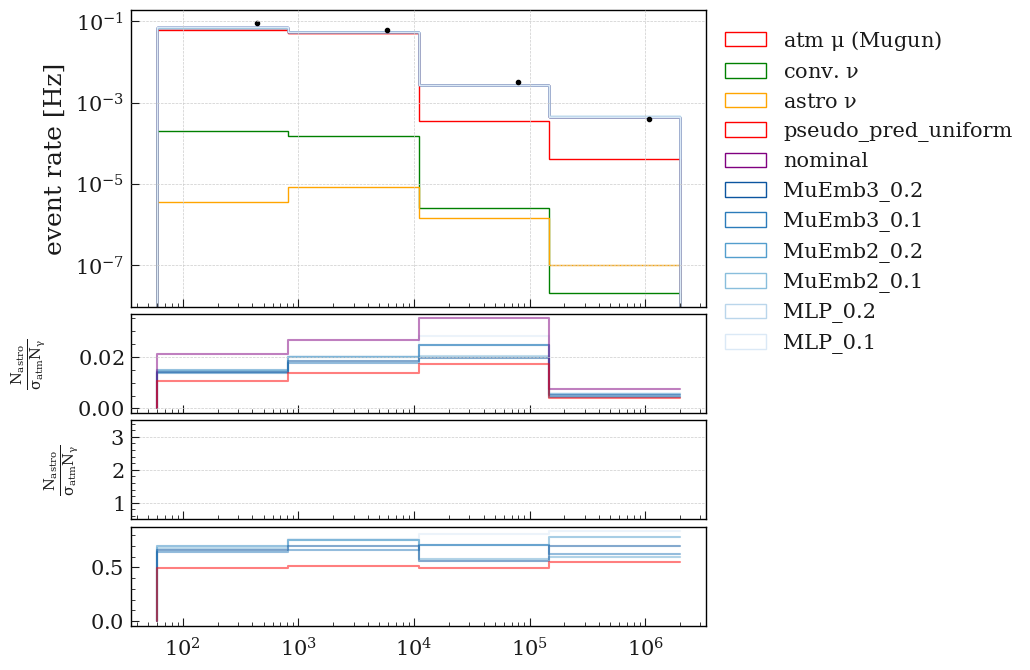

In [16]:
import textwrap
import matplotlib.pyplot as plt

def wraplabel(text, width=25):
    return "\n".join(textwrap.wrap(text, width=width))

def make_label(hname):
    if not 'pseudo' in hname:
        if "_" in hname:
            label = "_".join(hname.split("_")[3:-2])
        else:
            return hname
    else:
        label = hname
    return wraplabel(label, 15)

hists = get_hists(**var_info, samples=samples)


fig, axs = utils.plt_subplots(figsize=(10,8), nrows=4, height_ratios=[3,1,1,1] )
fig.tight_layout(pad=3)

ax_main = axs[0]
hkw = dict(ax=ax_main, histtype='step', lw=1.5)
snames = [ 'astro', 'atm_conv', 'mugun']


utils.plot_hist( [hists[sname] for sname in snames],
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

snames_comp = ['corsika', 'mugun']

# utils.plot_hist_uncertainties( hists['corsika'], ax=ax_main, 
#                             color=samples['corsika']['color'],
#                             hatch=None,
#                             alpha=0.3,
#                             fill=True,
#                             label='corsika'
#                            )

utils.plot_error_hist(hists['data'], 
                ax_main, color='black')


# ax_main.set_yscale('log')
# ax_main.set_xscale('log')
# ax_main.legend()

# assert False

cmap = plt.cm.get_cmap('Blues')

colors = {
    # 'pseudo_pred_gauss_0.2': 'green',
    'pseudo_pred_uniform': 'red',
}

_ = [h for h in  hists_pred if h not in colors]
for i, h in enumerate(_, 1):
    colors[h] = cmap(i/(len(_)))

colors['nominal'] = samples['corsika']['color']


utils.plot_hist([h for h in hists_pred.values()], 
                color=[colors[h] for h in hists_pred],
                #color=[]
                #label=[make_label(h) for h in hists_pred],
                label=[h for h in hists_pred],
                ax=ax_main,
                fill=False,
                histtype='step',                    
                )

# icolor = 0
# for hname, h in hists_pred.items():
#     icolor += 1
#     label = make_label(hname)
#     utils.plot_hist(h, ax=ax_main,
#                     color=colors[hname],
#                     fill=False                    
#                     #label=label,
#                     #**hkw,
#                     )
#     utils.plot_hist_uncertainties( h, ax=ax_main, 
#                                 #color=colors.get(hname ),
#                                 color=colors[hname],
#                                 hatch=None,
#                                 alpha=0.8,
#                                 # fill=True,
#                                 label=wraplabel(label, 20)
#                             )
#
# utils.plot_error_hist(hists['data'], 
#                 ax_main, color='black')

ax_r1 = axs[1]

foms = {}
for k,h in hists_pred.items():
    fom = cscd_utils.calc_fom(hists['astro'], h)
    fom = np.array(fom)

    label = make_label(k)
    label = wraplabel(label, 30)

    foms[k] = fom
    ax_r1.step(x=h.axes[0].edges[:], y=[0]+list(fom), label=label, color=colors[k], alpha=0.5)


ax_r2 = axs[2]

for k, fom in foms.items():
    # fom = cscd_utils.calc_fom(hists['astro'], h)
    fom = np.array(fom)/(n_simulated_photons[k] * 5E-9 )
    # fom /= 
    label = make_label(k)
    label = wraplabel(label, 30)

    ax_r2.step(x=h.axes[0].edges[:], y=[0]+list(fom), label=label, color=colors[k], alpha=0.5)



ax_r3 = axs[3]
for k,h in hists_pred.items():
    
    if k == 'nominal':
        continue

    fom = foms[k]
    fom /= foms['nominal']

    label = make_label(k)
    label = wraplabel(label, 30)

    #ax_r.scatter(x=h.axes[0].centers, y=fom, label=label, color=colors[k], alpha=0.5)
    ax_r3.step(x=h.axes[0].edges[:], y=[0]+list(fom), label=label, color=colors[k], alpha=0.5)



yscale = var_info.get('yscale', 'log')
xscale = var_info.get('xscale', 'linear')
ax_main.set_yscale(yscale)
ax_main.set_xscale(xscale)

legend_kwargs = dict(ncol=1, 
                     fontsize=15, 
                     loc='upper left', 
                     #bbox_to_anchor=(0.5, 1.15),
                     bbox_to_anchor=(1, 1),
                     )

leg = ax_main.legend(**legend_kwargs)


for artist in leg.legend_handles:
    artist.set_alpha(1)
    #artist.set_linewidth(2)


ax_main.set_ylabel("event rate [Hz]")
# ax_main.set_ylim(1E-8, 1E-1)

ax_r1.set_xlabel(var)
ax_r1.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} }$", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)
ax_r2.set_ylabel(r"$\frac{N_{astro}}{\sigma_{atm} {N_{\gamma}} } $", fontsize=15, rotation=90, position=(0, 0.5), labelpad=20)


plt.subplots_adjust(right=0.7)

# ax_r.set_ylim(0.5, 3.5)
ax_main.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
ax_r1.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)
ax_r2.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

ax_r2.set_ylim(0.5, 3.5)



In [132]:
foms


{'MLP_0.2': array([0.67599806, 0.71253856, 0.88255391, 0.72681932]),
 'MuEmb1_0.2': array([0.62973917, 0.66830509, 0.97885258, 0.80029004]),
 'MuEmb2_0.2': array([0.69157722, 0.71739348, 1.01117106, 0.91355734]),
 'MuEmb3_0.2': array([0.66673234, 0.67154747, 0.69532539, 0.8768908 ]),
 'nominal': array([0.00682042, 0.00833359, 0.01045106, 0.00224496]),
 'pseudo_pred_uniform': array([0.53608073, 0.49338859, 0.82520336, 0.72482562])}

In [86]:
# foms['pseudo_pred_uniform']/foms['nominal']
for k,l in foms.items():
    print(k, l/foms['nominal'])

base_large_v0.0_simple_v0.0_0.2 [2.01503613 2.19232885 2.98776107 2.78127538]
base_1028_v0.0_muemb_v0.0_0.2 [2.0796351  2.08318605 2.3367306  2.44528725]
nominal [1. 1. 1. 1.]
pseudo_pred_uniform [0.63594765 0.5033071  1.85989564 1.87006615]


In [162]:
[k for k in df_corsika.columns if 'muemb' in k]


[]

In [101]:

centers = h.axes[0].centers






MLP
MuEmb1
MuEmb2
nominal
pseudo_pred_uniform


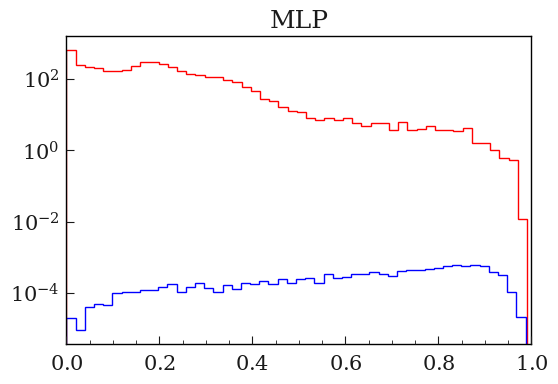

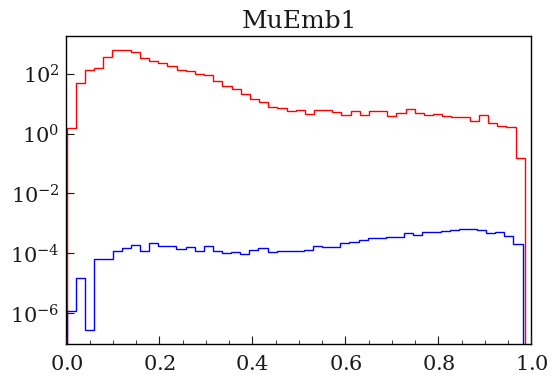

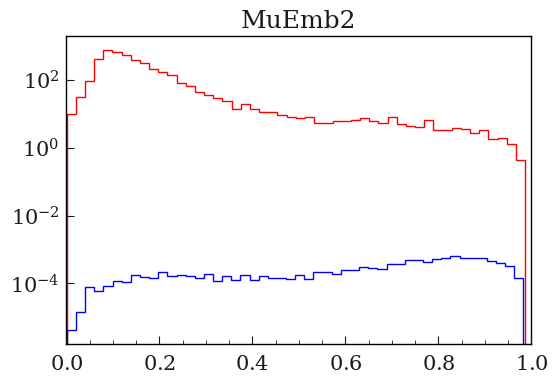

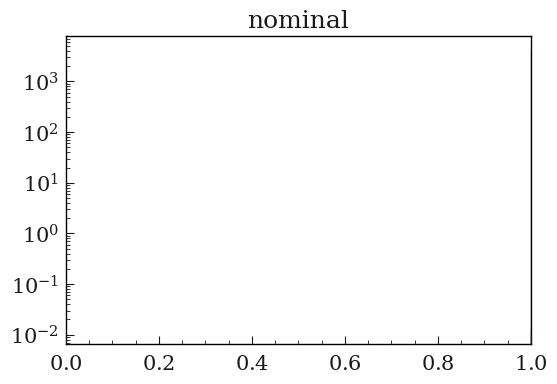

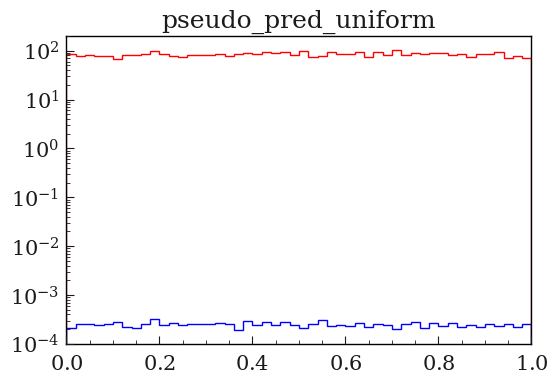

In [118]:


for pred_name in model_names + ['pseudo_pred_uniform']:
    print(pred_name)
    # for selection in selections:
    fig, ax = plt.subplots()
    # df = df_corsika.query(selection)
    df = df_corsika
    cls0 = df[mf.labels[0]]==0
    cls1 = df[mf.labels[0]]==1

    weights = df['sel_flux_weights']
    hkw = dict(bins=50, histtype='step')

    ax.hist(df[cls0][pred_name], weights=weights[cls0], color='red', **hkw)
    ax.hist(df[cls1][pred_name], weights=weights[cls1], color='blue', **hkw) 
    title = pred_name #+"\n"+selection
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xlim(0,1)

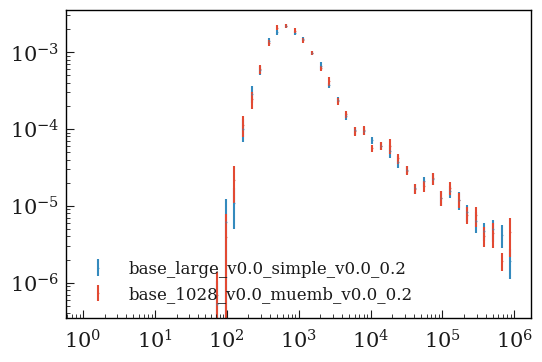

In [ ]:
hists_pred

for k, h in hists_pred.items():
    plt.errorbar(h.axes[0].centers, h.counts(), yerr=np.sqrt(h.variances()), fmt='o', markersize=0.3, label=k)
    
#h.variances()

h.variances(), h.axes[0].centers, h.counts()

plt.legend()
plt.xscale('log')
plt.yscale('log')



In [67]:


[k for k in df_corsika if 'pred' in k]
model_names

#df[]
pred_key = 'base_1028_v0.0_muemb_v0.0'
#pred = df[]

df[pred_key]

for pred_key in model_names:
    cpu = np.sum( df[pred_key]*df['n_photons']*df['selection_weights'] )
    print(pred_key, f"{cpu : 0.2e}")

base_large_v0.0_simple_v0.0  1.09e+15
base_1028_v0.0_muemb_v0.0  9.40e+14


In [ ]:

mf = ModelFactory.load_model(model_name="model_c0e773f6",   
                             #model_dir_base="",
                             # model_tag="newmuvars_v0.2_wproc2",
                             model_tag="test",
                             # version_tag="Cscd_v0.0.2_mupos",
                             version_tag="Cscd_v0.0.2_mupos",
                             model_dir_base="/cephfs/users/nrad/lustre/i3kiss/models/"
                             )

mf = ModelFactory.load_model(model_name="test_v0.1",   
                             #model_dir_base="",
                             model_tag="newmuvars_v0.2_wproc2",
                             version_tag="Cscd_v0.0.2_mupos",
                             model_dir_base="/cephfs/users/nrad/lustre/i3kiss/models/"
                             )

try:    
    mf._df_train = df_train
    mf._df_test = df_test
except NameError:
    df_train = mf.df_train
    df_test = mf.df_test
    
 

loading model from:  /cephfs/users/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/test/model_c0e773f6/model.keras
MODEL <Sequential name=sequential, built=True>
loading weights from:  /cephfs/users/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/test/model_c0e773f6/model_c0e773f6.weights.h5
loading model from:  /cephfs/users/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/newmuvars_v0.2_wproc2/test_v0.1/model.keras
MODEL <Sequential name=sequential, built=True>
loading weights from:  /cephfs/users/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/newmuvars_v0.2_wproc2/test_v0.1/test_v0.1.weights.h5
loading only 1 out of 1...
loading DF: ['/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/train.hdf5']:
       ['/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/train.hdf5']
loading only 1 out of 1...
loading DF: ['/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/C

<ufunc 'tanh'>

In [ ]:
from utils import tf_utils

# def remove_final_activation(model):
#     from tensorflow.keras.models import clone_model
#     from tensorflow.keras.layers import Activation    
#     """
#         based on the underrated answer of @carlos-bermudez in: 
#         https://stackoverflow.com/questions/45492318/keras-retrieve-value-of-node-before-activation-function
#     """

#     final_layer_name = model.layers[-1].name
#     def f(layer):
#         config = layer.get_config()
#         #if not isinstance(layer, Activation) and layer.name in model.output_names:
#         if not isinstance(layer, Activation) and layer.name in [final_layer_name]:
#             print(f'removing activation in {layer}')
#             config.pop('activation', None)
#         layer_copy = layer.__class__.from_config(config)
#         return layer_copy


#     copy_model = clone_model(model, clone_function=f)  
#     copy_model.build(model.input_shape)
#     copy_model.set_weights(model.get_weights())
#     return copy_model

model_preact = tf_utils.remove_final_activation(mf.model)

# model.weights[-4]
# mf.model.summary()

# model.summary()
# model.layers[-1].get_config().get('activation')

pred_preact = model_preact.predict(mf.X_test, batch_size=mf.batch_size).flatten()
pred = mf.model.predict(mf.X_test, batch_size=mf.batch_size).flatten()



removing activation in <Dense name=dense, built=True>

    X_train.shape = (2357209, 101) 
    y_train.shape = (2357209, 1) 
    ---
    X_test.shape  = (261037, 101) 
    y_test.shape  = (261037, 1)
    
    positive % (train) : CscdBDT    4.1
dtype: float64%
    positive % (test)  : CscdBDT    4.1
dtype: float64%
    
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

I0000 00:00:1735919229.881488 2953114 service.cc:146] XLA service 0x7f8b5408c3b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735919229.881528 2953114 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-01-03 16:47:09.887824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735919229.992818 2953114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [34]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


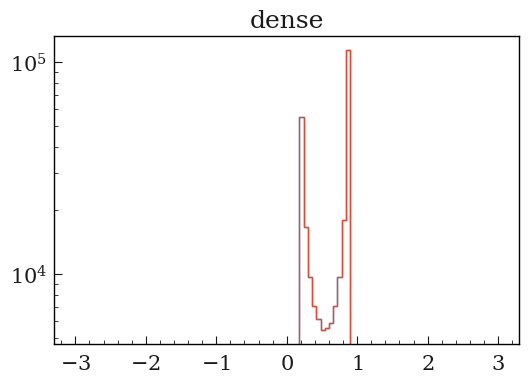

In [35]:
fig, ax = plt.subplots()
ax.hist(intermediate_output.flatten(), bins=100, range=(-3,3),histtype='step', label=layer_name)
ax.hist(sigmoid(intermediate_output_preact.flatten()) , bins=100, range=(-3,3),histtype='step', label=layer_name)
ax.set_title(layer_name)
ax.set_yscale('log')


removing activation in <Dense name=Dense_0_256_tanh, built=True>
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


removing activation in <Dense name=Dense_1_256_tanh, built=True>
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
removing activation in <Dense name=Dense_2_64_tanh, built=True>
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


removing activation in <Dense name=Dense_3_64_tanh, built=True>
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


removing activation in <Dense name=Dense_4_16_tanh, built=True>
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


removing activation in <Dense name=Dense_5_16_tanh, built=True>
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


removing activation in <Dense name=Dense_6_4_tanh, built=True>
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
removing activation in <Dense name=Dense_7_4_tanh, built=True>


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
removing activation in <Dense name=Dense_8_2_tanh, built=True>


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
removing activation in <Dense name=dense, built=True>


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


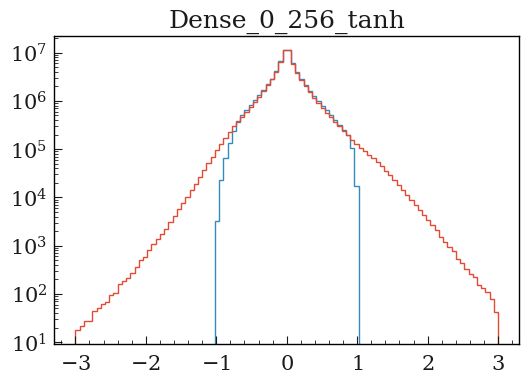

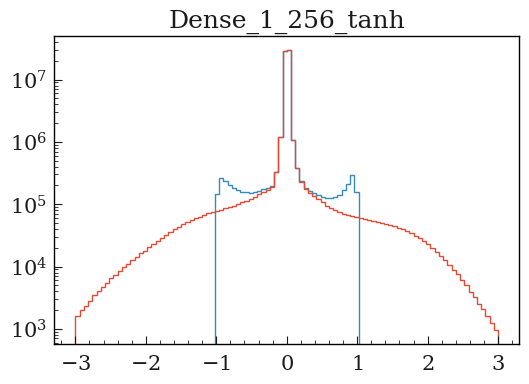

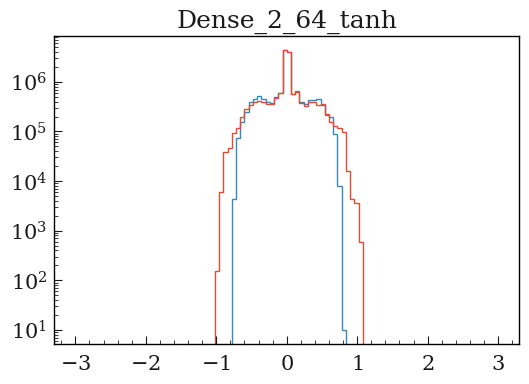

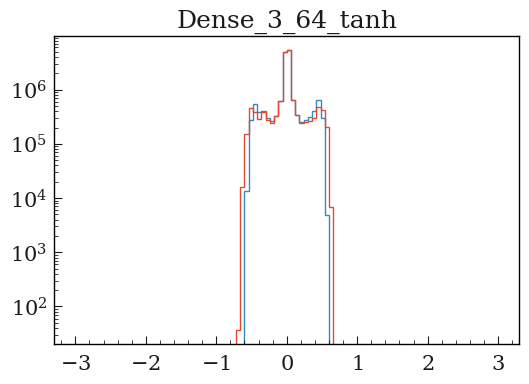

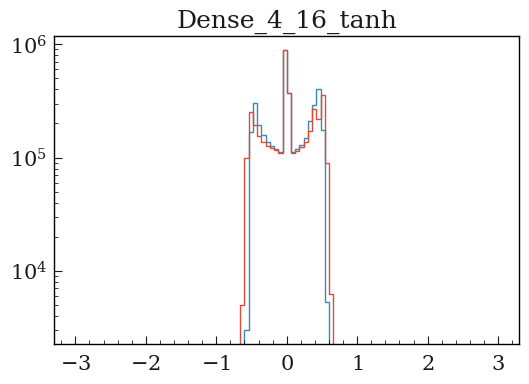

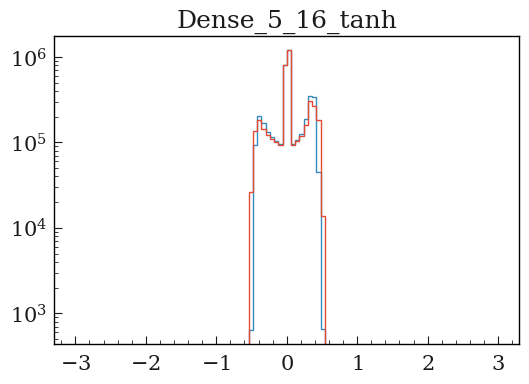

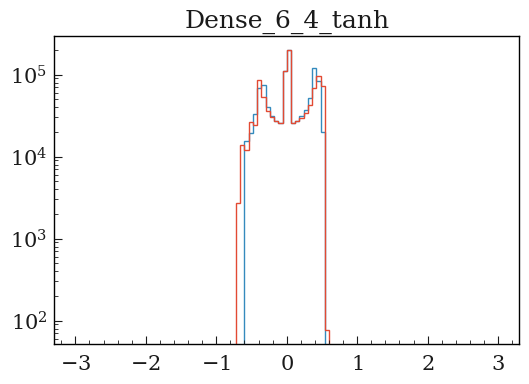

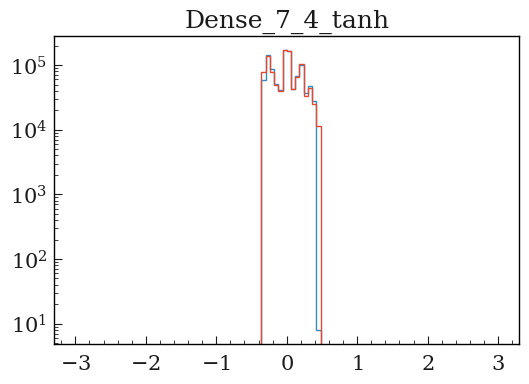

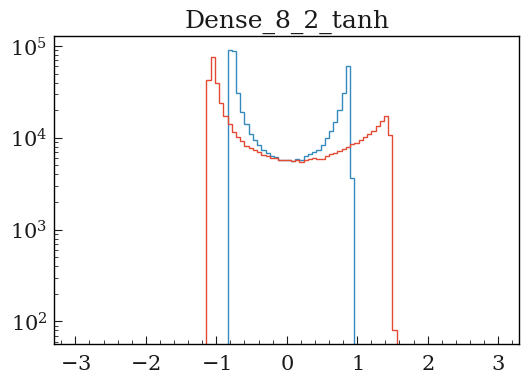

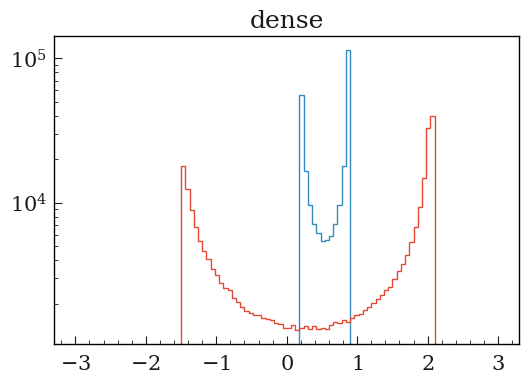

In [44]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
model = mf.model
# Create a sub-model up to a specific intermediate layer
model_layers = {}
for layer in mf.model.layers:
    layer_name = layer.name
    intermediate_layer_model = Model(inputs=[model.inputs], outputs=model.get_layer(layer_name).output)
    #intermediate_layer_model =
    if not intermediate_layer_model.layers[-1].get_config().get('activation'):
        continue
    m = tf_utils.remove_final_activation(intermediate_layer_model)
    # assert not intermediate_layer_model.layers[-1].get_config().get('activation') 
    intermediate_output = intermediate_layer_model.predict(mf.X_test, batch_size=mf.batch_size)
    intermediate_output_preact = m.predict(mf.X_test, batch_size=mf.batch_size)
    model_layers[layer_name] = {'model':intermediate_layer_model, 'model_preact':m, 'output':intermediate_output, 'output_preact':intermediate_output_preact}
    fig, ax = plt.subplots()
    ax.hist(intermediate_output.flatten(), bins=100, range=(-3,3),histtype='step', label=layer_name)
    ax.hist(intermediate_output_preact.flatten() , bins=100, range=(-3,3),histtype='step', label=layer_name)
    ax.set_title(layer_name)
    ax.set_yscale('log')
    #assert False

In [89]:
from keras import layers


def define_model(
    n_variables,
    n_labels=3,
    init_layer=64,
    final_layer=4,
    unit_step=2,
    layer_repeat=1,
    max_layers=20,
    name=None,
    hidden_activation="relu",
    dropout=0.8,
    batch_norm=True,
    kernel_regularizer=None,
    kernel_initializer=None,
    #l2_bias_reguali
):
    sequence = []
    if batch_norm:
        pass
        #sequence.append( layers.BatchNormalization(input_shape=(n_variables,)) )
        #assert False
        sequence.append( layers.BatchNormalization() )
    
    n_unit = init_layer
    hid_layers = 0
    hidden_kwargs = dict(kernel_regularizer=None if kernel_regularizer is None else tf.keras.regularizers.l2(kernel_regularizer),
                    kernel_initializer=kernel_initializer,
                    activation=hidden_activation)
    while n_unit > final_layer and hid_layers < max_layers:
        for i in range(layer_repeat):
            sequence.append(
                layers.Dense(
                    n_unit,
                    name=f"Dense_{hid_layers}_{n_unit}_{hidden_activation}",
                    **hidden_kwargs
                )
            )
            if hid_layers == 0 and dropout:
                sequence.append(layers.Dropout(dropout))
            hid_layers += 1
            print(hid_layers, f"Dense_{hid_layers}_{n_unit}_{hidden_activation}")
            if hid_layers >= max_layers:
                break
            
        n_unit = int(n_unit / unit_step)

    if final_layer:
        if final_layer:
            sequence.append(
                layers.Dense(
                    final_layer,
                    name=f"Dense_{hid_layers}_{final_layer}_{hidden_activation}",
                    **hidden_kwargs
                ),
            )
    sequence.append(layers.Dense(n_labels, activation="sigmoid"))
    model = tf.keras.Sequential(sequence)
    model.build(input_shape=(None, n_variables))
    return model


import tensorflow as tf
define_model(10,
    n_labels=1,
    init_layer=101,
    final_layer=0,
    unit_step=0.75,
    max_layers=10,
             ).summary()



1 Dense_1_101_relu
2 Dense_2_134_relu
3 Dense_3_178_relu
4 Dense_4_237_relu
5 Dense_5_316_relu
6 Dense_6_421_relu
7 Dense_7_561_relu
8 Dense_8_748_relu
9 Dense_9_997_relu
10 Dense_10_1329_relu


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_39          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_0_101_relu (Dense)        │ (None, 101)            │         1,111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1_134_relu (Dense)        │ (None, 134)            │        13,668 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2_178_relu (Dense)        │ (None, 178)            │        24,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3_237_relu (Dense)        │ (None, 237)            │        42,423 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4_316_relu (Dense)        │ (None, 316)            │        75,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_5_421_relu (Dense)        │ (None, 421)            │       133,457 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_6_561_relu (Dense)        │ (None, 561)            │       236,742 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_7_748_relu (Dense)        │ (None, 748)            │       420,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_8_997_relu (Dense)        │ (None, 997)            │       746,753 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_9_1329_relu (Dense)       │ (None, 1329)           │     1,326,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │         1,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,021,480 (11.53 MB)

 Trainable params: 3,021,460 (11.53 MB)

 Non-trainable params: 20 (80.00 B)

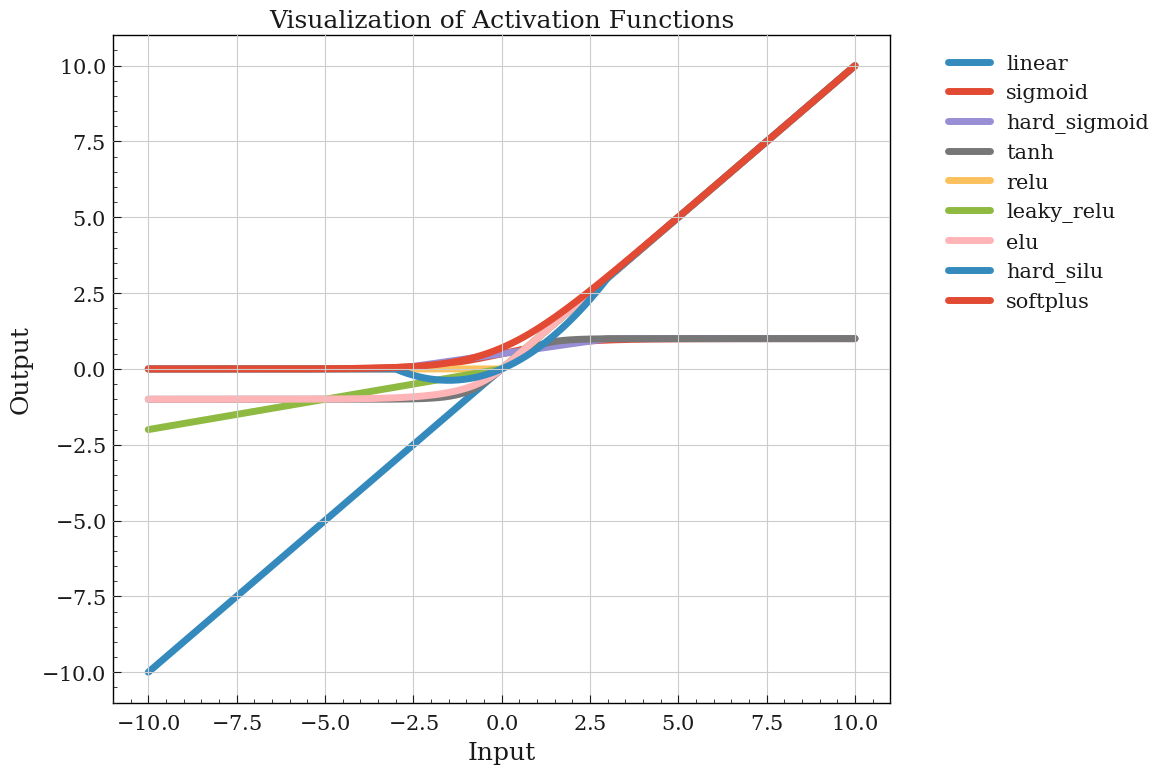

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

# Define a range of inputs
x = np.linspace(-10, 10, 500)

# List of activation functions to visualize
activations = ['linear', 'sigmoid', 'hard_sigmoid', 'tanh', 'relu', 'leaky_relu', 'elu', 'hard_silu', 'softplus']

# Initialize the plot
plt.figure(figsize=(12, 8))

# Loop through each activation function
for act in activations:
    y = K.eval(Activation(act)(K.constant(x)))  # Compute activation
    
    plt.plot(x, y, label=act, linewidth=5)

# Add legend, labels, and grid
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=15)  # Adjust legend position
plt.title('Visualization of Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

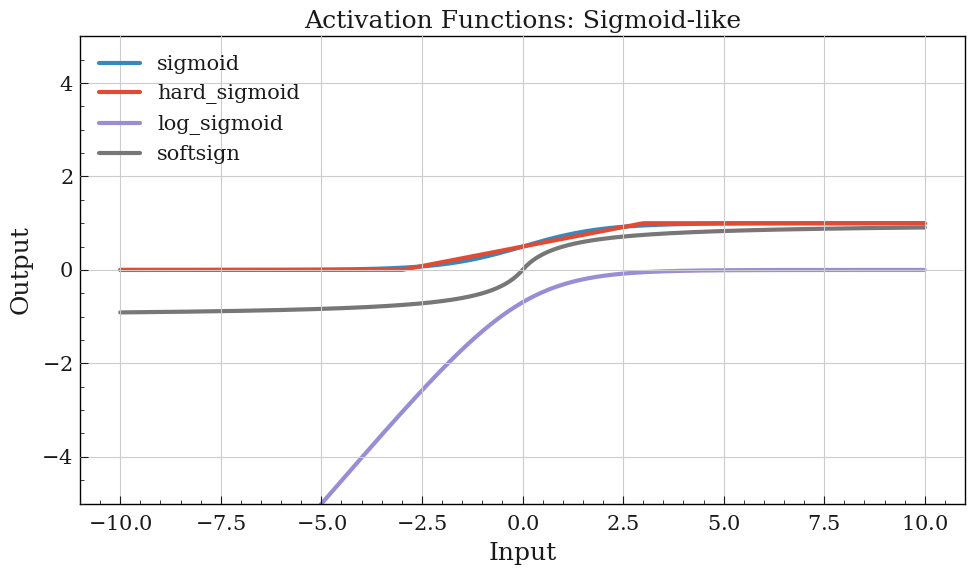

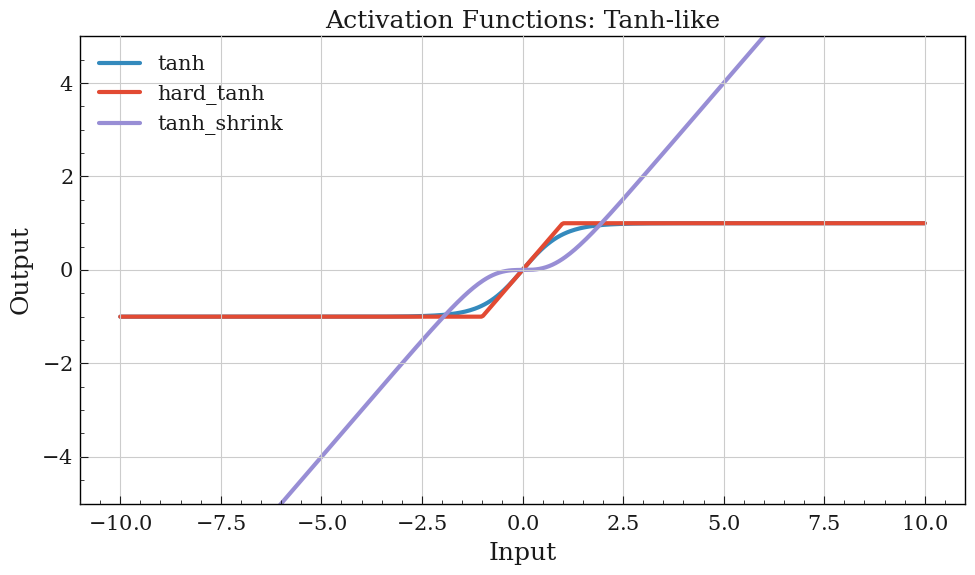

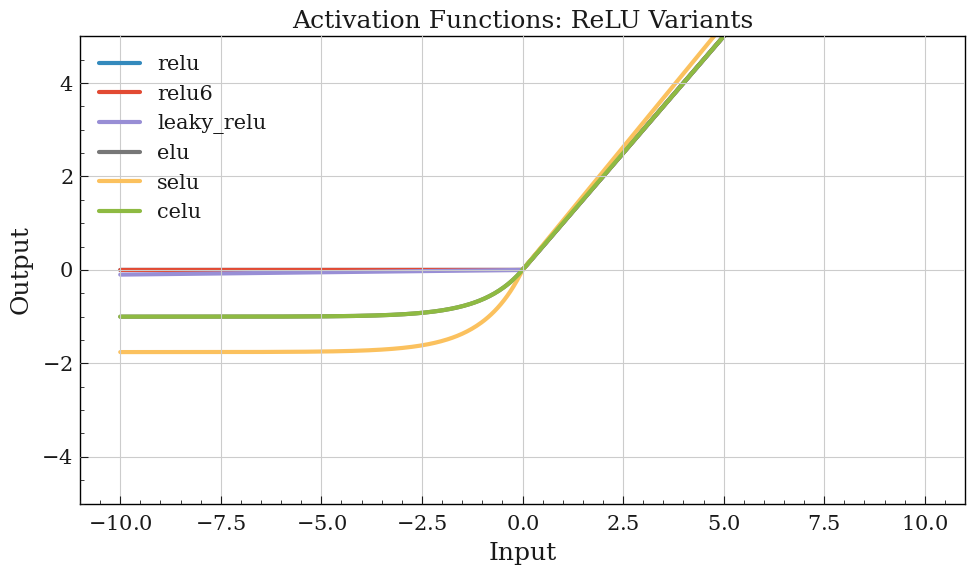

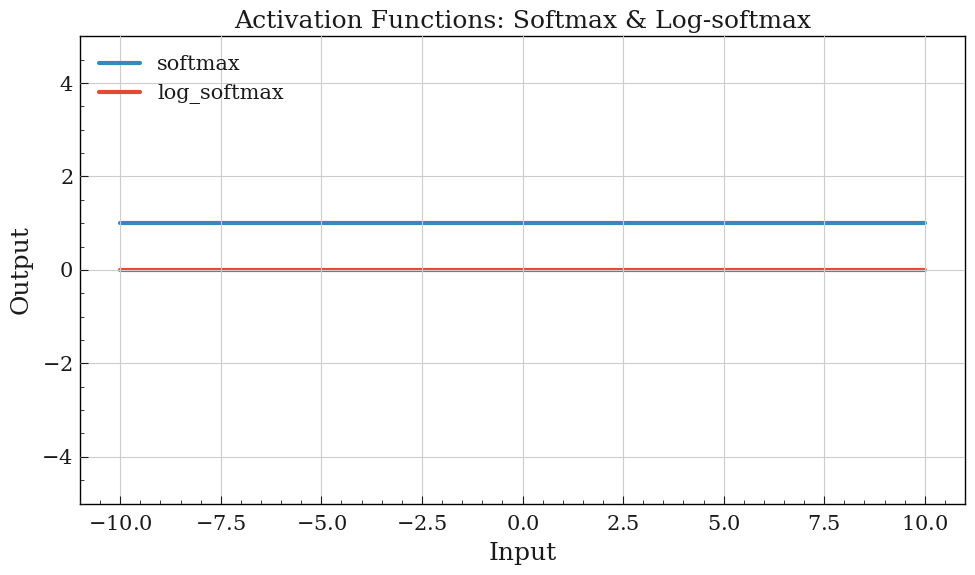

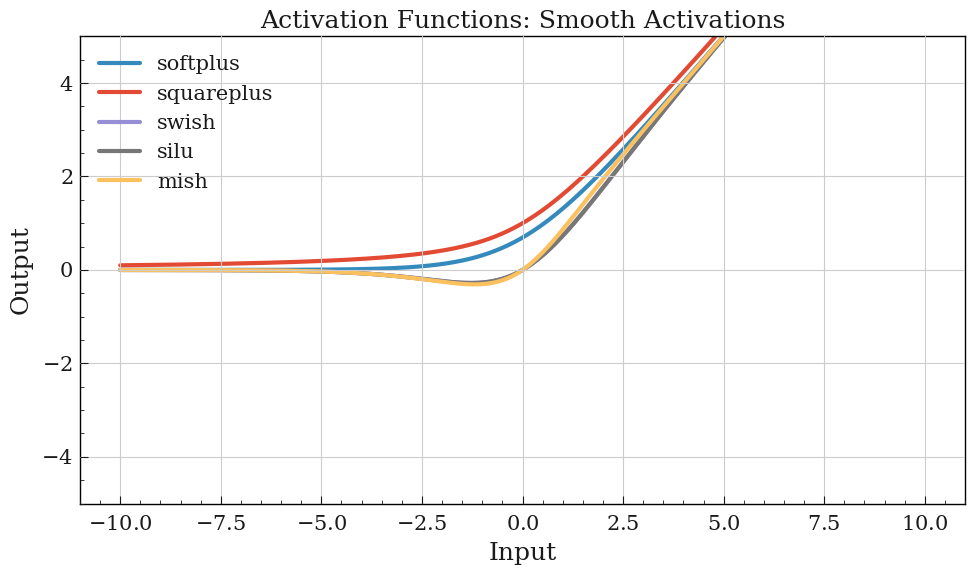

Error with activation glu: x and y must have same first dimension, but have shapes (500,) and (250,)


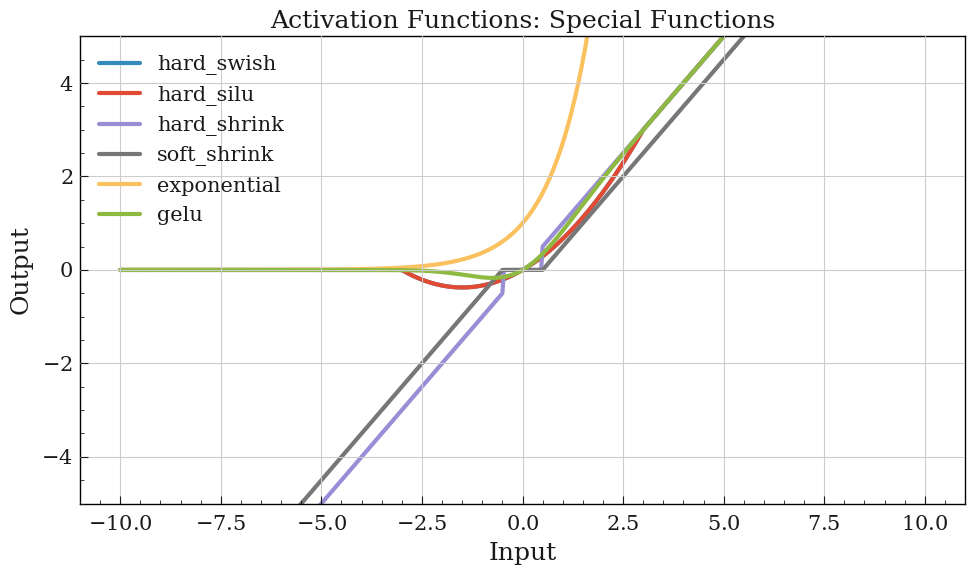

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

# Define input range
x = np.linspace(-10, 10, 500)

# Group activation functions by similarity
groups = {
    "Sigmoid-like": ['sigmoid', 'hard_sigmoid', 'log_sigmoid', 'softsign'],
    "Tanh-like": ['tanh', 'hard_tanh', 'tanh_shrink'],
    "ReLU Variants": ['relu', 'relu6', 'leaky_relu', 'elu', 'selu', 'celu'],
    "Softmax & Log-softmax": ['softmax', 'log_softmax'],
    "Smooth Activations": ['softplus', 'squareplus', 'swish', 'silu', 'mish'],
    "Special Functions": ['hard_swish', 'hard_silu', 'hard_shrink', 'soft_shrink', 'exponential', 'gelu', 'glu']
}

# Plot each group
for group_name, activations in groups.items():
    plt.figure(figsize=(10, 6))
    for act in activations:
        try:
            if act == 'leaky_relu':
                y = np.maximum(0.01 * x, x)  # Manually implement leaky_relu
            elif act in ['softmax', 'log_softmax']:  
                y = K.eval(Activation(act)(K.constant(x.reshape(-1, 1))))[:, 0]  # Softmax requires 2D input
            else:
                y = K.eval(Activation(act)(K.constant(x)))  # Compute activation
            plt.plot(x, y, label=act, lw=3)
        except Exception as e:
            print(f"Error with activation {act}: {e}")
    
    # Add legend and labels
    plt.legend(loc='upper left', fontsize=15)
    plt.ylim(-5,5)
    plt.title(f"Activation Functions: {group_name}")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [108]:
import keras
acts = [k for k in dir(keras.activations) if not k.startswith('_') and k not in ['deserialize', 'get', 'serialize']]
print(acts)

['celu', 'elu', 'exponential', 'gelu', 'glu', 'hard_shrink', 'hard_sigmoid', 'hard_silu', 'hard_swish', 'hard_tanh', 'leaky_relu', 'linear', 'log_sigmoid', 'log_softmax', 'mish', 'relu', 'relu6', 'selu', 'sigmoid', 'silu', 'soft_shrink', 'softmax', 'softplus', 'softsign', 'squareplus', 'swish', 'tanh', 'tanh_shrink']


In [64]:
mf.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 101)            │           404 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_0_256_tanh (Dense)        │ (None, 256)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1_256_tanh (Dense)        │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2_64_tanh (Dense)         │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3_64_tanh (Dense)         │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4_16_tanh (Dense)         │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_5_16_tanh (Dense)         │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_6_4_tanh (Dense)          │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_7_4_tanh (Dense)          │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_8_2_tanh (Dense)          │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,584 (1.31 MB)

 Trainable params: 114,127 (445.81 KB)

 Non-trainable params: 202 (808.00 B)

 Optimizer params: 228,255 (891.62 KB)

In [ ]:
tf_utils.define_model(10,
                      1,
                      100,
                      3000,
                      0.1).summary()
"GlorotNormal"

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_0_3000_relu (Dense)       │ (None, 3000)           │        33,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         3,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,041 (140.79 KB)

 Trainable params: 36,021 (140.71 KB)

 Non-trainable params: 20 (80.00 B)

In [43]:
np.tanh(10)

0.9999999958776927


    X_train.shape = (2357209, 101) 
    y_train.shape = (2357209, 1) 
    ---
    X_test.shape  = (261037, 101) 
    y_test.shape  = (261037, 1)
    
    positive % (train) : CscdBDT    4.1
dtype: float64%
    positive % (test)  : CscdBDT    4.1
dtype: float64%
    
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)
/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(8192, 101))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/afs/ifh.de/user/n/nrad/scratch/venvs/py3.11_tf2.17/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(None, 101))
  warnings.warn(msg)


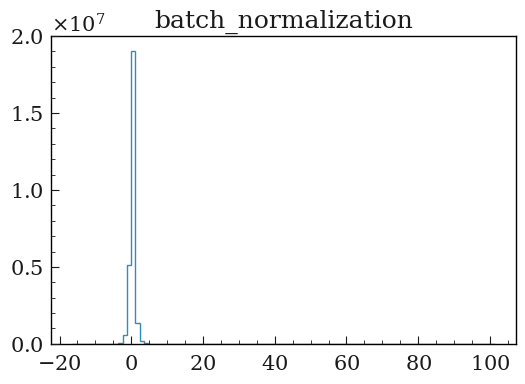

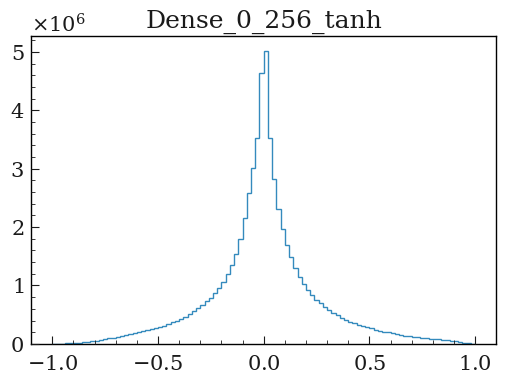

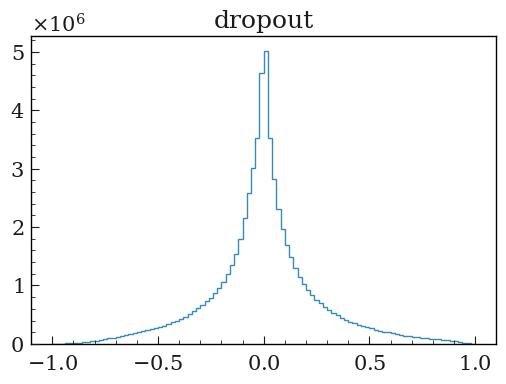

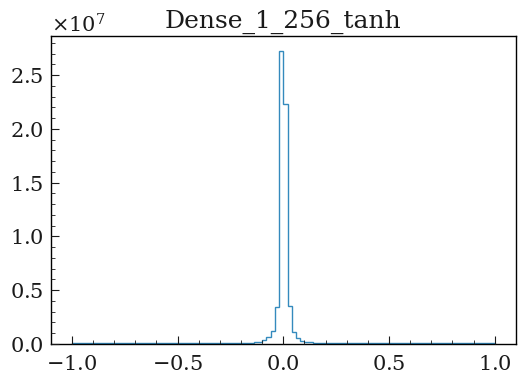

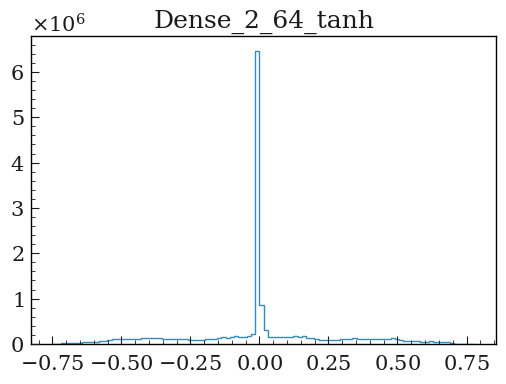

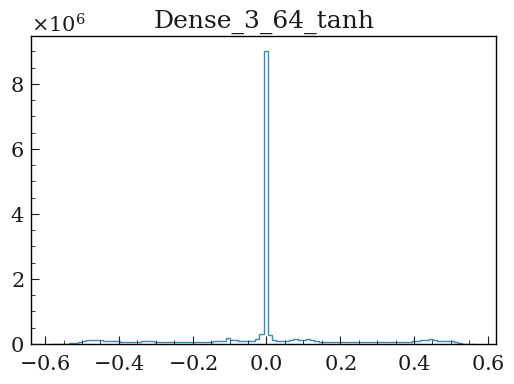

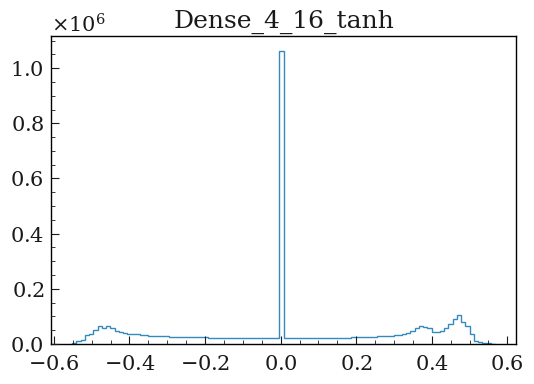

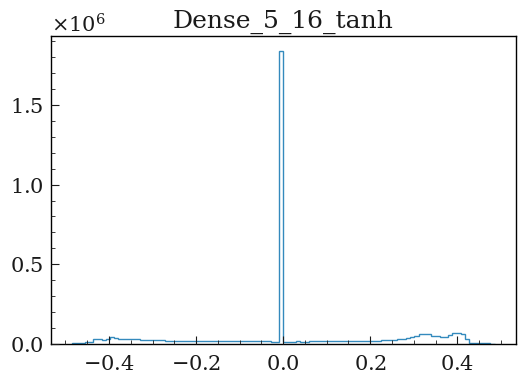

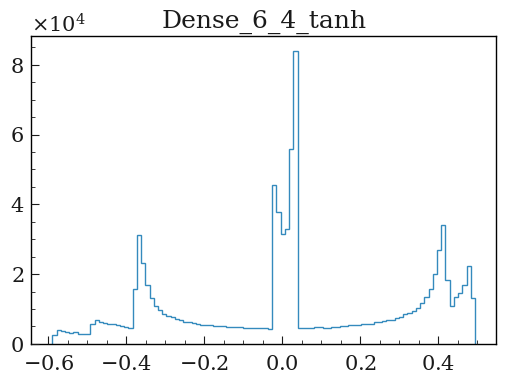

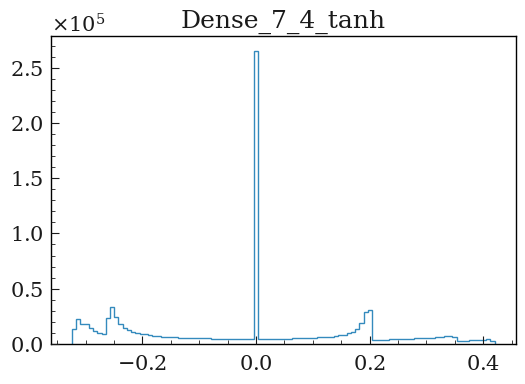

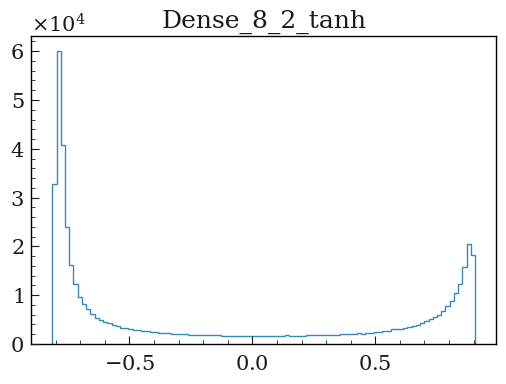

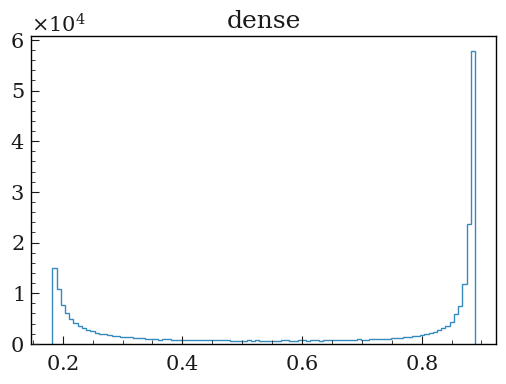

In [87]:
from tensorflow.keras.models import Model
model = mf.model
# Create a sub-model up to a specific intermediate layer
for layer in mf.model.layers:
    layer_name = layer.name
    intermediate_layer_model = Model(inputs=[model.inputs], outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(mf.X_test, batch_size=mf.batch_size)
    fig, ax = plt.subplots()
    ax.hist(intermediate_output.flatten(), bins=100, range=(-2,2),histtype='step', label=layer_name)
    ax.set_title(layer_name)

In [82]:
intermediate_layer_model.summary()

Model: "functional_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 101)            │           404 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_0_256_relu (Dense)        │ (None, 256)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1_256_relu (Dense)        │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2_64_relu (Dense)         │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3_64_relu (Dense)         │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4_16_relu (Dense)         │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,956 (445.14 KB)

 Trainable params: 113,754 (444.35 KB)

 Non-trainable params: 202 (808.00 B)

In [77]:
# model.get_layer('layer_name')
model.inputs

[<KerasTensor shape=(None, 101), dtype=float32, sparse=False, name=input_layer>]

In [75]:
[k.name for k in mf.model.layers]

['batch_normalization',
 'Dense_0_256_relu',
 'dropout',
 'Dense_1_256_relu',
 'Dense_2_64_relu',
 'Dense_3_64_relu',
 'Dense_4_16_relu',
 'Dense_5_16_relu',
 'Dense_6_4_relu',
 'Dense_7_4_relu',
 'Dense_8_2_relu',
 'dense']

In [ ]:
import keras
grad_model = keras.models.Model(
[model.inputs],
[model.get_layer('Dense_8_2_relu').output,
model.get_layer('dense').output])

In [54]:
for layer in model.layers:
    weights = layer.get_weights()
    if weights:
        print(f"{layer.name:<20} | Weight range: {weights[0].min():.4f} to {weights[0].max():.4f} | Bias range: {weights[1].min():.4f} to {weights[1].max():.4f}")

batch_normalization  | Weight range: -0.0000 to 3.1450 | Bias range: -0.8606 to 0.9020
Dense_0_256_tanh     | Weight range: -0.2242 to 0.1852 | Bias range: -0.1430 to 0.0937
Dense_1_256_tanh     | Weight range: -0.0905 to 0.0831 | Bias range: -0.0842 to 0.0762
Dense_2_64_tanh      | Weight range: -0.0714 to 0.0758 | Bias range: -0.0444 to 0.0626
Dense_3_64_tanh      | Weight range: -0.0594 to 0.0576 | Bias range: -0.0072 to 0.0087
Dense_4_16_tanh      | Weight range: -0.0652 to 0.0635 | Bias range: -0.0205 to 0.0122
Dense_5_16_tanh      | Weight range: -0.0933 to 0.0946 | Bias range: -0.0193 to 0.0145
Dense_6_4_tanh       | Weight range: -0.1832 to 0.1802 | Bias range: -0.0365 to 0.0252
Dense_7_4_tanh       | Weight range: -0.3382 to 0.2226 | Bias range: -0.0314 to 0.0226
Dense_8_2_tanh       | Weight range: -1.3852 to 1.6996 | Bias range: -0.0084 to -0.0079
dense                | Weight range: -1.1163 to -0.9808 | Bias range: 0.3936 to 0.3936


In [45]:
for l in mf.model.layers:
    print(l.get_config())

{'name': 'batch_normalization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}
{'name': 'Dense_0_256_tanh', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registere

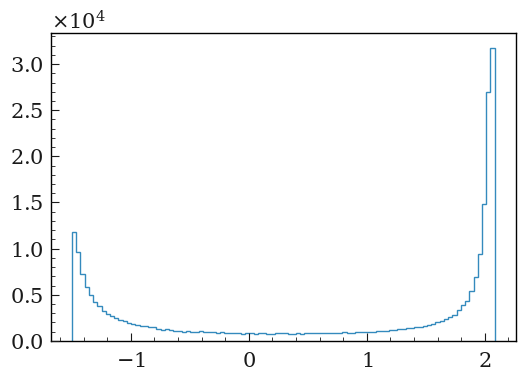

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# _ = plt.hist(sigmoid(pred_preact), bins=100, histtype='step', label='preact')
_ = plt.hist((pred_preact), bins=100, histtype='step', label='preact', )

# _ = plt.hist(pred, bins=100, histtype='step', label='postact')

#sigmoid(pred_preact)
#pred_preact

In [47]:
mf.df_test['balanced_weights_CscdBDT']


0         0.378394
1         4.926544
2         0.182280
3         0.015518
4         8.561246
            ...   
261032    0.993643
261033    0.773638
261034    0.482407
261035    0.069966
261036    0.084347
Name: balanced_weights_CscdBDT, Length: 261037, dtype: float64

In [43]:
np.max(pred_preact)

2.083963